In [1]:
library(ggplot2)
library(ComplexHeatmap)

Loading required package: grid

ComplexHeatmap version 2.6.2
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite:
Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
  genomic data. Bioinformatics 2016.

This message can be suppressed by:
  suppressPackageStartupMessages(library(ComplexHeatmap))




In [2]:
datasets = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_with_therapy.rds")
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
ref_path_OS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival_pm.rds")
ref_path_PFS = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_PFS_total_survival_pm.rds")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)

In [3]:
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)

In [4]:
datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(datasets[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(datasets[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(datasets[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

datasets_overview[c("dataset2","dataset6","dataset8","dataset10","dataset11","dataset12","dataset13","dataset14","dataset20"),"RNA"] = TRUE

In [6]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = datasets_names$Cohort_name

In [7]:
pathway_list = readRDS("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/all_pathway.rds")

In [8]:
ref_single = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/result_data/ref_OS_total_survival.rds")

In [9]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1
dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

In [10]:
TCGA = readRDS("/srv/shiny-server/SNVIO_V10/data/TCGA/panacanlt_TCGA_log2.rds")

### OS

In [11]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_OS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_OS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.3) # 
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [12]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset5","dataset7","dataset13","dataset16","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [13]:
tmp$RS = -log(x = tmp$`Wald_test(OS)`,20) * log10(tmp$`HR(OS)`)

In [14]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [15]:
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}

In [16]:
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

In [17]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [19]:
OS_RS_matrix = RS_matrix

### PFS

In [20]:
ref_single_significant = list()

for(i in rownames(datasets_overview)[datasets_overview$Sequencing == "WES"]){
        
        tmp2 = ref_path_PFS[[i]]
        tmp2["top_3_gene(mutation)"] = NULL
        tmp2 = as.data.frame(apply(tmp2,2,as.numeric))
        rownames(tmp2) = rownames(ref_path_PFS[[i]])
        tmp2 = tmp2[!is.na(tmp2$`Patient(Mutation)`) & !is.na(tmp2$`Patient(Wildtype)`),]
        less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.3) 
        if(less_num <3){less_num = 3}
        tmp = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
        if(nrow(tmp) != 0){
            tmp$dataset = i
            tmp$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp$gene = rownames(tmp)
        }  
        ref_single_significant[[i]] = tmp
}

In [21]:
tmp = vector()
for(i in names(ref_single_significant)){
    if(!i %in%  c("dataset1.1","dataset1.2","dataset1.3","dataset1.4","dataset1.5","dataset1.6","dataset1.7","dataset1.8","dataset1.9",
                        "dataset1","dataset8","dataset10","dataset11","dataset1","dataset3","dataset6") & nrow(ref_single_significant[[i]]) != 0){
        tmp = rbind(tmp,ref_single_significant[[i]])
    }
    
}

In [22]:
tmp$RS = -log(x = tmp$`Wald_test(PFS)`,20) * log10(tmp$`HR(PFS)`)

In [23]:
RS_matrix = reshape2::dcast(data = tmp[,c("dataset","RS","gene")],formula = gene~dataset,value.var = "RS",fill = 0)
rownames(RS_matrix) = RS_matrix$gene
RS_matrix$gene = NULL

In [24]:
for(i in unique(datasets_overview$Cancer_type2)){
    tmp_datasets = rownames(datasets_overview)[ datasets_overview$Cancer_type2 %in% i]
    tmp_datasets = intersect(tmp_datasets,colnames(RS_matrix))
    RS_matrix[[i]] = apply(X = RS_matrix[tmp_datasets],1,function(x){
        meanscore = mean(x[x !=0 ])
        meanscore2 = ifelse(sign(meanscore) == 1, meanscore*sum(x > 0 ),
                          ifelse(sign(meanscore) == -1,meanscore*sum(x < 0 ),0))
        
        return(meanscore2)
    })
    RS_matrix[[i]][is.na(RS_matrix[[i]])] = 0
}


In [25]:
RS_matrix$MultiTumor_ALL_pan = apply(RS_matrix[,unique(datasets_overview$Cancer_type2)],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})

RS_matrix$MultiTumor_ALL_pan_clean = apply(RS_matrix[,setdiff(unique(datasets_overview$Cancer_type2),c("Pan-cancer","Microsatellite-stable solid tumors"))],1,function(x){
    meanscore = mean(x)
    ifelse(sign(meanscore) == 1,meanscore*sum(x>0),meanscore*sum(x<0))
})


In [26]:
RS_matrix = RS_matrix[ order(RS_matrix$MultiTumor_ALL_pan_clean,decreasing = F),]

In [28]:
PFS_RS_matrix = RS_matrix

### 合并

In [29]:
share_pathway = intersect(rownames(OS_RS_matrix),rownames(PFS_RS_matrix))

In [30]:
OS_RS_matrix2 = OS_RS_matrix[share_pathway,]

In [31]:
OS_RS_matrix2$Overview = OS_RS_matrix[share_pathway,]$MultiTumor_ALL_pan_clean + PFS_RS_matrix[share_pathway,c("MultiTumor_ALL_pan_clean")]

In [32]:
OS_RS_matrix2 = OS_RS_matrix2[ order(OS_RS_matrix2$Overview),]

In [34]:
color = c(colorRampPalette(rev(RColorBrewer::brewer.pal(n =9,name = "Blues")))(11)[1:10],
  colorRampPalette(RColorBrewer::brewer.pal(n =9,name = "Reds"))(11)[2:11])

Warning message:
“The `size` argument of `element_line()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


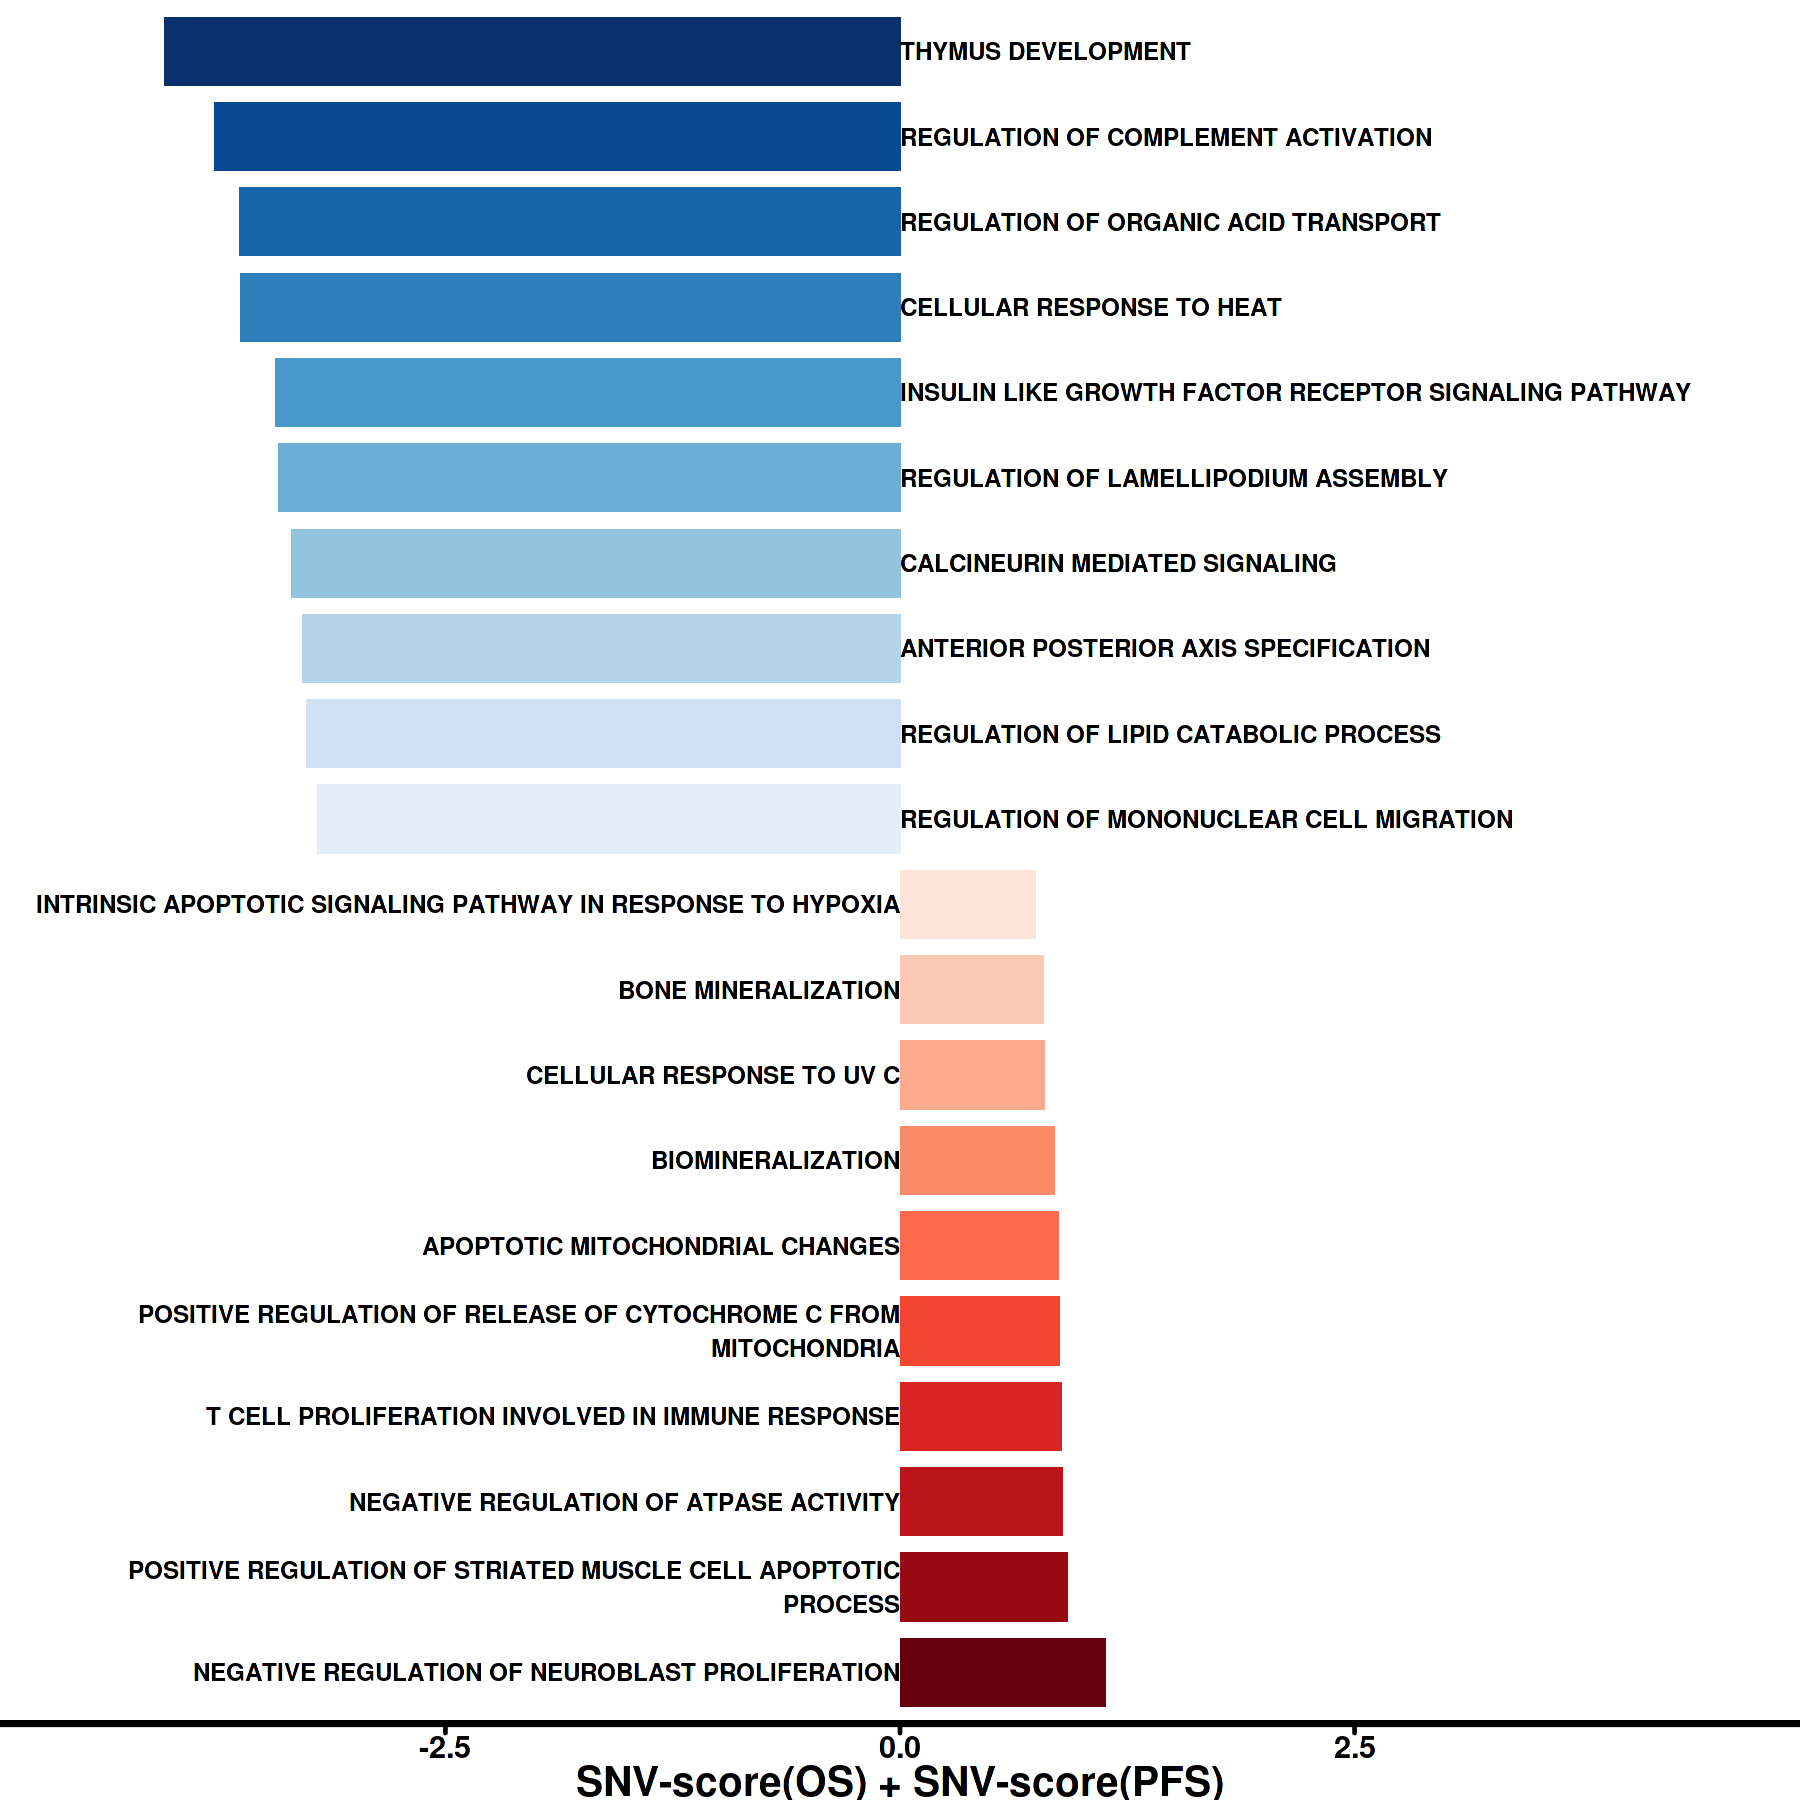

In [35]:
OS_RS_matrix3 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),] 

OS_RS_matrix3 = OS_RS_matrix3[ order(OS_RS_matrix3$Overview,decreasing = T),]
OS_RS_matrix3$gene = rownames(OS_RS_matrix3)

tmp_matrix = OS_RS_matrix3[c(rownames(OS_RS_matrix3)[1:10],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)]),]
tmp_matrix$color = c(rep("unfavor",10),rep("favor",10))

library(stringr)
tmp_matrix$gene = str_wrap(sapply(strsplit(as.character(tmp_matrix$gene),split = "_"),function(x) paste(x[2:length(x)],collapse = " ")),width = 60)
tmp_matrix$gene = factor(tmp_matrix$gene,levels = tmp_matrix$gene)

tmp_matrix$hjust = NA
tmp_matrix$hjust[1:10] = 1
tmp_matrix$hjust[(11):(20)] = 0


options(repr.plot.height = 15, repr.plot.width = 15)
p = ggplot(data = tmp_matrix)+
        geom_bar(aes(x = gene,y = Overview,fill=gene),stat = "identity",width=0.8,show.legend = F)+
        coord_flip()+
    geom_text(aes(x = gene,y = 0,label = gene,hjust = hjust),fontface ="bold",size = 5)+
      scale_fill_manual(values = rev(color))+
        theme_void()+
    ylim(c(-4.5,4.5))+
#         guides(fill=guide_legend(override.aes = list(size=15)))+
        theme(axis.line.x = element_line(colour = "black",linetype = "solid",size = 1.5),
              axis.ticks.length.x = unit(2,"mm"),
              axis.ticks.x = element_line(colour = "black",linetype = "solid",size = 1 ),
              axis.text.x = element_text(angle = 0,hjust = 0.5,size=18,face = "bold"),
              axis.title.y = element_blank(),
              axis.text.y = element_blank(),
              legend.title = element_blank(),
              legend.text = element_text(size = 24,face = "bold"),
              axis.title.x = element_text(face="bold",size = 24),
              legend.position = c(0.9,0.2))+
        ylab("SNV-score(OS) + SNV-score(PFS)")
p

In [36]:
pdf("Artical_Figure2/Figure 2/Complement1.pdf",width = 20,height = 15)
p
dev.off()

png 
  2

In [36]:
TMB_f = tmp_matrix[1,]
rownames(TMB_f) = "TMB"
TMB_f$Overview = 0
TMB_f$gene = "TMB"
tmp_matrix = rbind(TMB_f,tmp_matrix)

Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”
Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


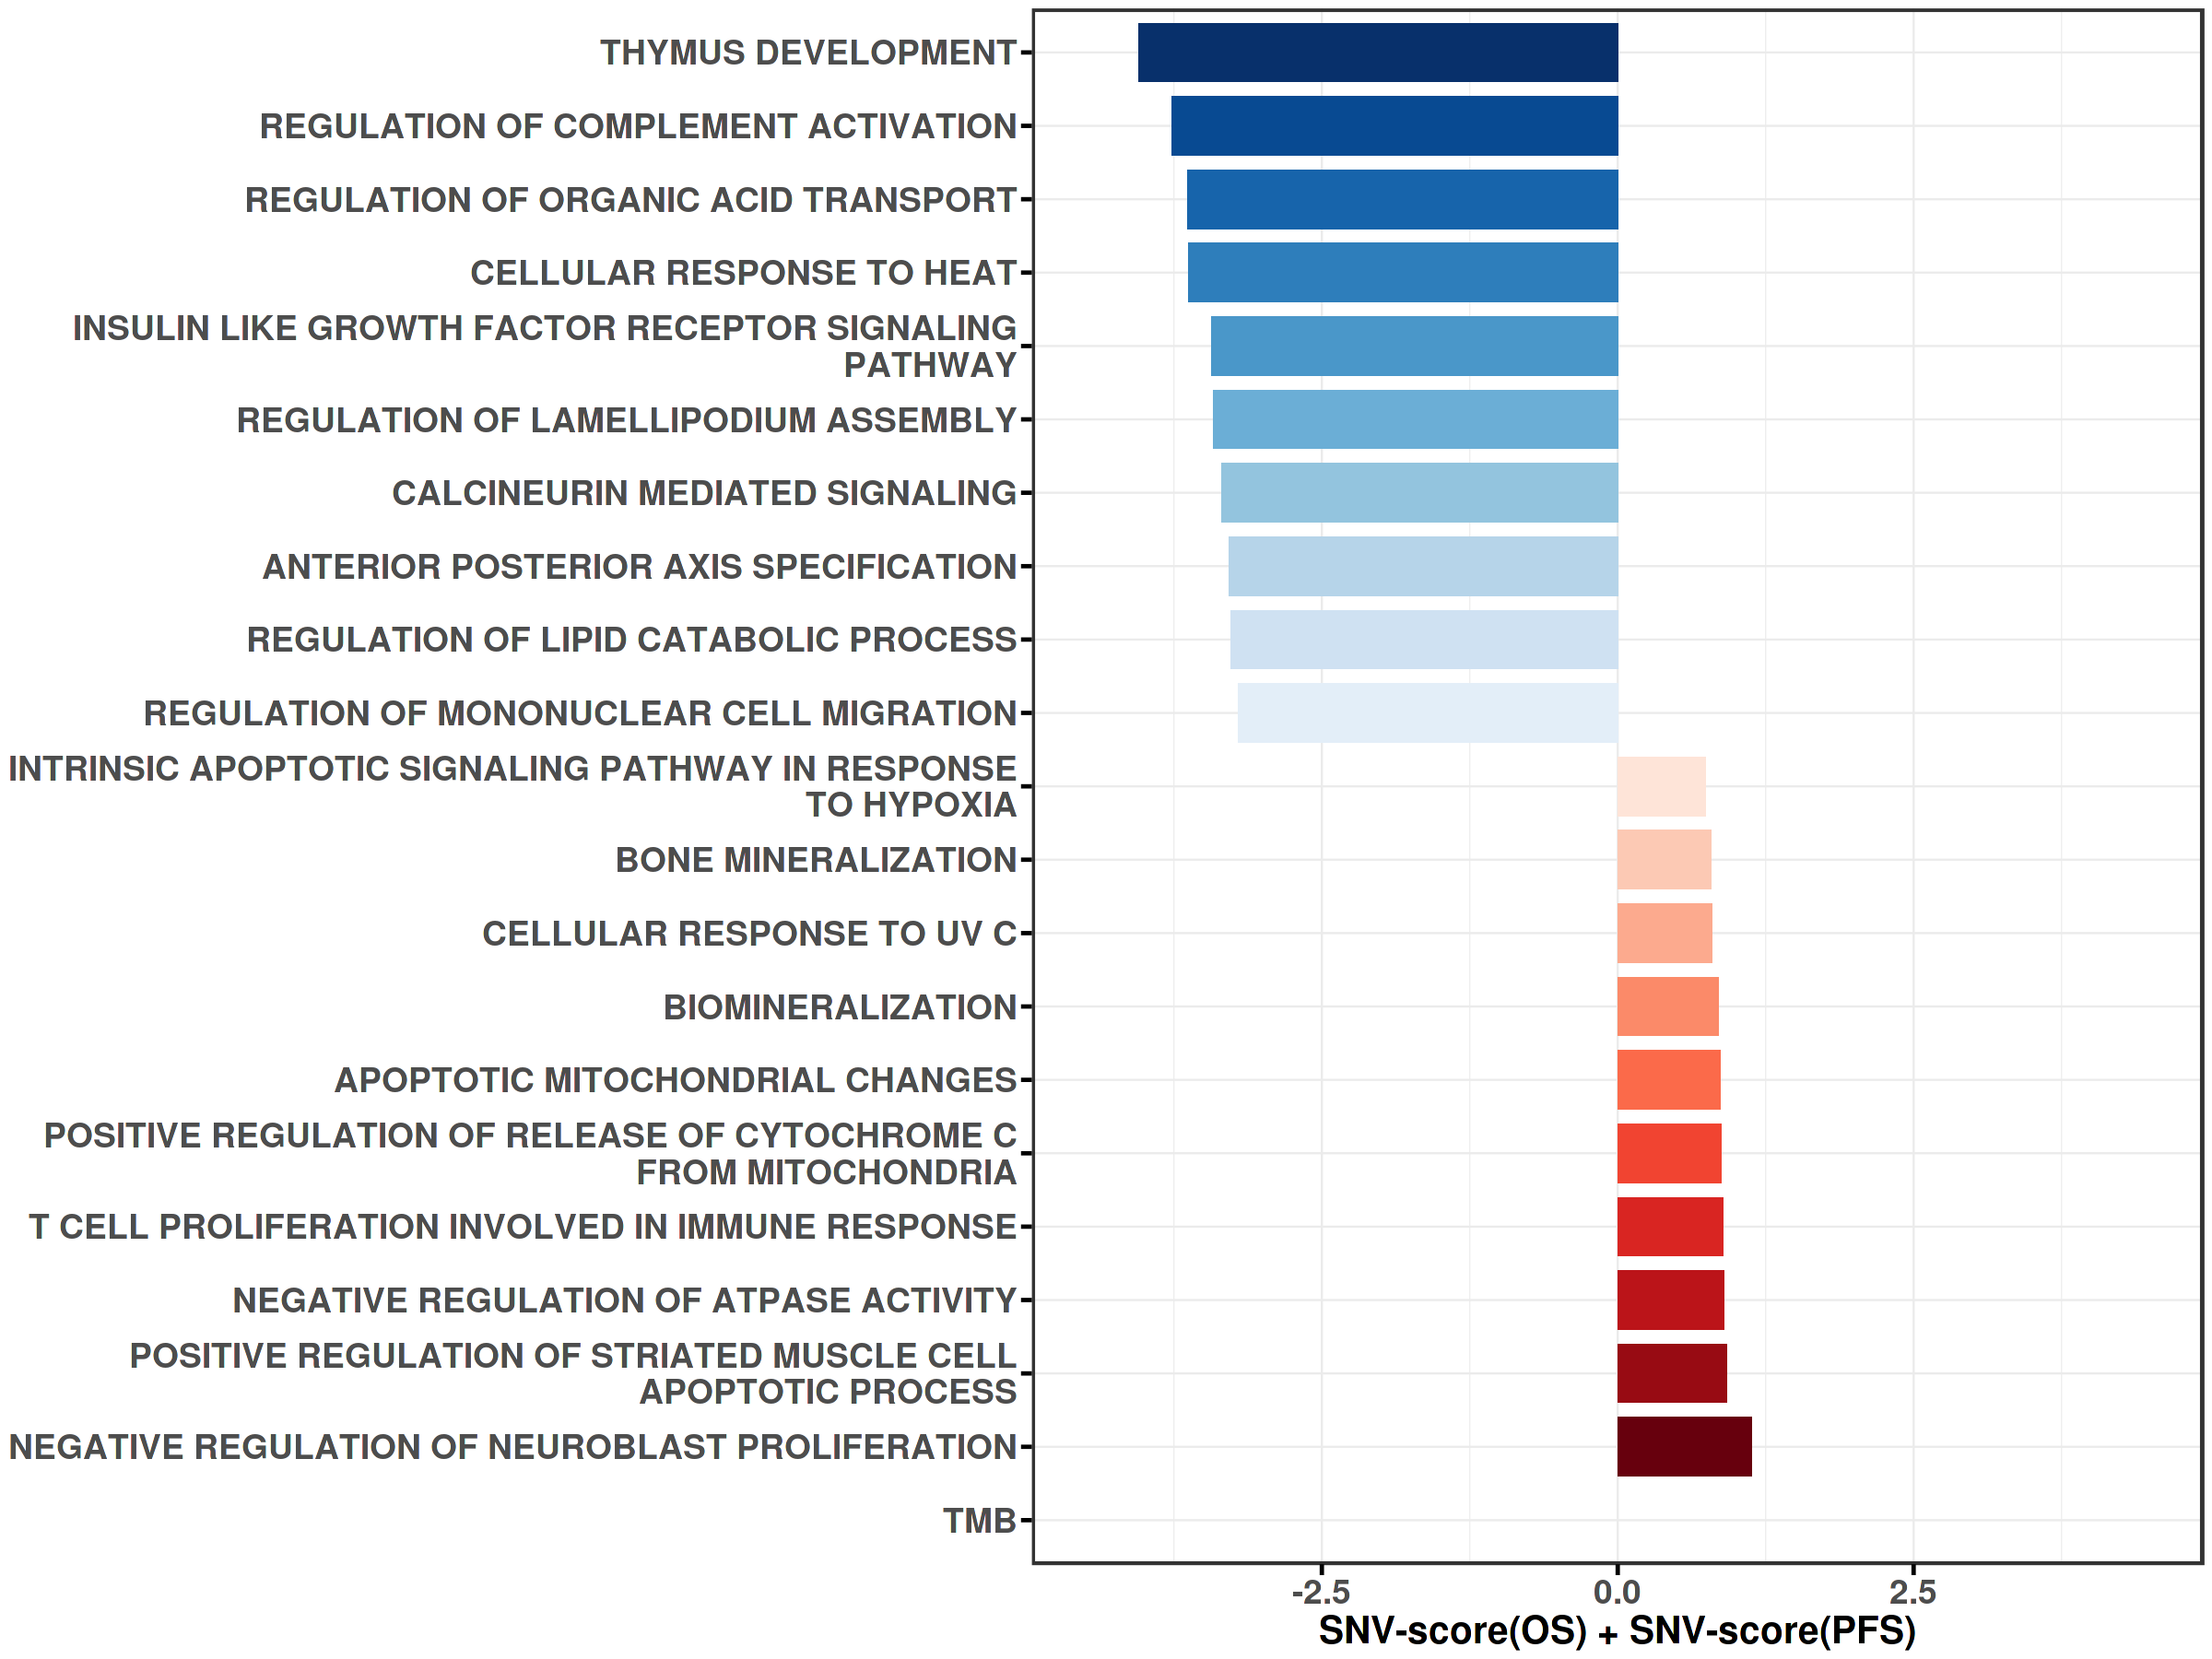

In [37]:
color = c(colorRampPalette(rev(RColorBrewer::brewer.pal(n =9,name = "Blues")))(11)[1:10],
  colorRampPalette(RColorBrewer::brewer.pal(n =9,name = "Reds"))(11)[2:11])

OS_RS_matrix3 = OS_RS_matrix2[grepl("GOBP",rownames(OS_RS_matrix2)),] 

OS_RS_matrix3 = OS_RS_matrix3[ order(OS_RS_matrix3$Overview,decreasing = T),]
OS_RS_matrix3$gene = rownames(OS_RS_matrix3)

tmp_matrix = OS_RS_matrix3[c(rownames(OS_RS_matrix3)[1:10],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)]),]

TMB_f = tmp_matrix[1,]
rownames(TMB_f) = "TMB"
TMB_f$Overview = NA
TMB_f$gene = "G_TMB"
tmp_matrix = rbind(TMB_f,tmp_matrix)

tmp_matrix$color = c(rep("unfavor",11),rep("favor",10))

library(stringr)
tmp_matrix$gene = str_wrap(sapply(strsplit(as.character(tmp_matrix$gene),split = "_"),function(x) paste(x[2:length(x)],collapse = " ")),width = 50)
tmp_matrix$gene = factor(tmp_matrix$gene,levels = tmp_matrix$gene)

tmp_matrix$hjust = NA
tmp_matrix$hjust[1:11] = 1
tmp_matrix$hjust[(12):(21)] = 0


options(repr.plot.height = 15, repr.plot.width = 20)
p = ggplot(data = tmp_matrix)+
        geom_bar(aes(x = gene,y = Overview,fill=gene),stat = "identity",width=0.8,show.legend = F)+
        coord_flip()+
#     geom_text(aes(x = gene,y = -3,label = gene),hjust = 1,fontface ="bold",size = 5)+
      scale_fill_manual(values = rev(color))+
#         theme_void()+
theme_bw()+
    ylim(c(-4.5,4.5))+
#         guides(fill=guide_legend(override.aes = list(size=15)))+
        theme(
            panel.border = element_rect(size = 1.5),
#             axis.line = element_line(colour = "black",linetype = "solid",size = 1),
              axis.ticks.length = unit(2.5,"mm"),
              axis.ticks = element_line(colour = "black",linetype = "solid",size = 1 ),
              axis.text.x = element_text(angle = 0,hjust = 0.5,size=22,face = "bold"),
              axis.title.y = element_blank(),
              axis.text.y = element_text(face = "bold",size = 22),
              legend.title = element_blank(),
              legend.text = element_text(size = 24,face = "bold"),
              axis.title.x = element_text(face="bold",size = 24),
              legend.position = c(0.9,0.2))+
        ylab("SNV-score(OS) + SNV-score(PFS)")
p

In [38]:
p_bar = p

### mutation frequencis -- complement

Loading required package: viridisLite



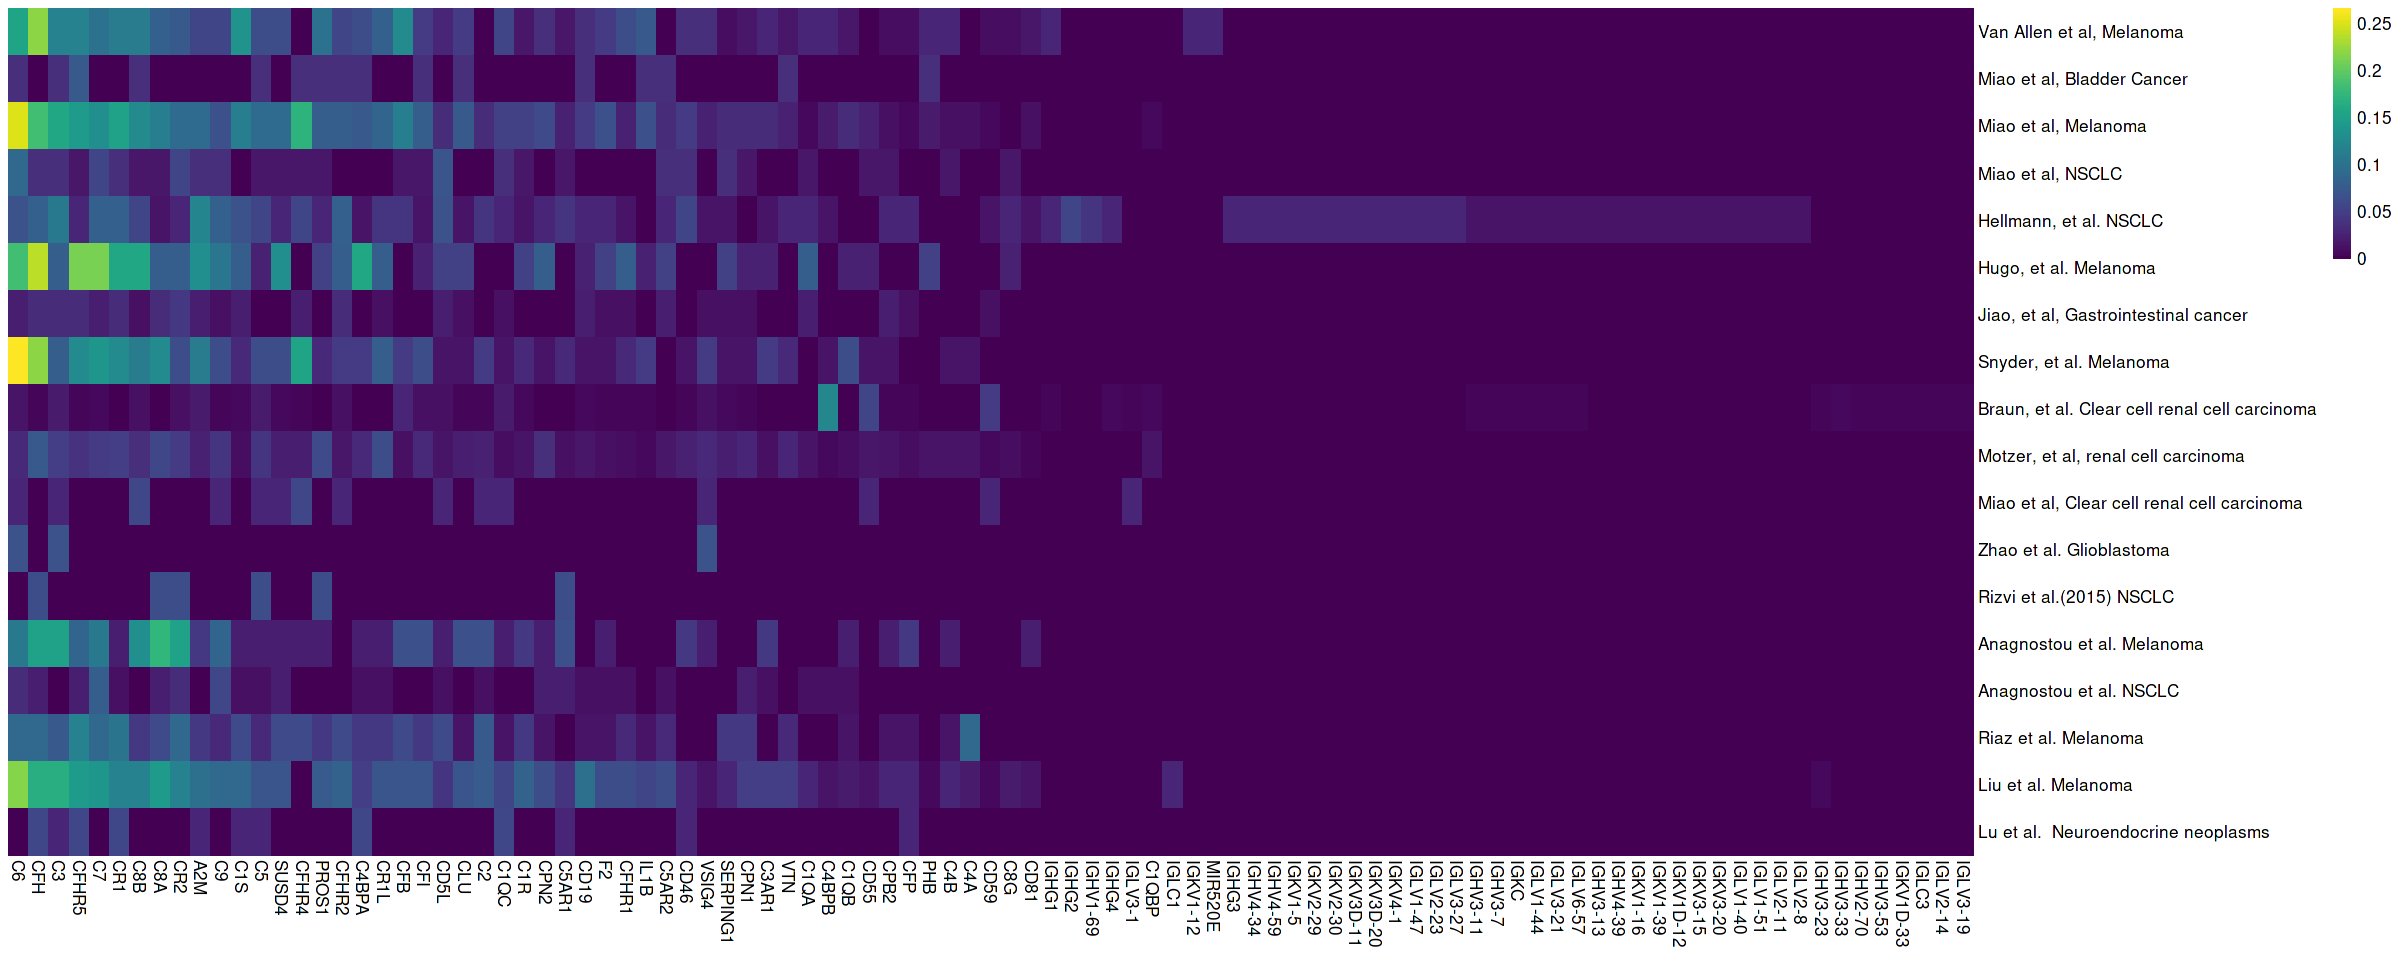

In [39]:
ref_single_significant2 = list()

for(i in rownames(datasets_overview)[ datasets_overview$Sequencing == "WES"]){
        tmp2 = ref_single[[i]]
#         less_num = floor(unique(rowSums(tmp2[,c("Patient(Mutation)","Patient(Wildtype)")])) * 0.05) # 两个组至少包含的患者数是总人数的5%
#         if(less_num <3){less_num = 3}
#         tmp2 = tmp2[ tmp2$`Patient(Mutation)` >= less_num & tmp2$`Patient(Wildtype)` >= less_num,]
#         tmp = tmp[ tmp$`Log_rank_test(OS)`<0.05 | tmp$`Wald_test(OS)` < 0.05,]  # 筛选P值小于0.05
        if(nrow(tmp2) != 0){
            tmp2$dataset = i
            tmp2$Cancer_type = datasets_overview[i,"Cancer_type"]
            tmp2$Cancer_type2 = datasets_overview[i,"Cancer_type2"]
            tmp2$gene = rownames(tmp2)
        }  
        ref_single_significant2[[i]] = tmp2
}

# 这里已经将dataset1 和 dataset3 去除了
tmp2 = vector()
for(i in names(ref_single_significant2)){
    if(!i %in%  c("dataset1","dataset3","dataset6") & nrow(ref_single_significant2[[i]]) != 0){
        tmp2 = rbind(tmp2,ref_single_significant2[[i]])
    }
    
}

pat_mut_num = reshape2::dcast(tmp2,dataset~gene,value.var = "Patient(Mutation)",fill = 0)
rownames(pat_mut_num) = pat_mut_num$dataset
pat_mut_num$dataset = NULL
pat_mut_num = pat_mut_num[rownames(datasets_overview)[ rownames(datasets_overview) %in% rownames(pat_mut_num)],]
pat_mut_num$Cohort_size = datasets_overview[rownames(pat_mut_num),"Cohort_size"]
pat_mut_num$Sequencing = datasets_overview[rownames(pat_mut_num),"Sequencing"]
rownames(pat_mut_num) = datasets_overview[rownames(pat_mut_num),"Cohort_name"]

pat_mut_pro = pat_mut_num[,1:(ncol(pat_mut_num)-2)]/pat_mut_num$Cohort_size
pat_mut_pro = pat_mut_pro[,intersect(colnames(pat_mut_num),pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])]

WES_names = dataset_name[setdiff(rownames(datasets_overview)[ datasets_overview$Sequencing == "WES"],c("dataset1","dataset3","dataset6"))]

pat_mut_pro = pat_mut_pro[WES_names,]
pat_mut_pro = pat_mut_pro[,order(colSums(pat_mut_pro),decreasing = T)]

library(viridis )
options(repr.plot.height = 8, repr.plot.width = 20)
pheatmap::pheatmap(pat_mut_pro,clustering_method = "ward.D",
                   cluster_rows = F,
                   cluster_cols = F,
                   color = viridis::viridis(100),
#                    cellwidth = 16,
#                    cellheight = 20,
                   border_color = "white")

In [40]:
meta = datasets_overview[ datasets_overview$Cohort_name %in% rownames(pat_mut_pro),]
rownames(meta) = meta$Cohort_name
meta = meta[,c("Cancer_type","Immune_checkpoint_blockade","Sequencing","Cancer_type2")]

circlize version 0.4.14
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




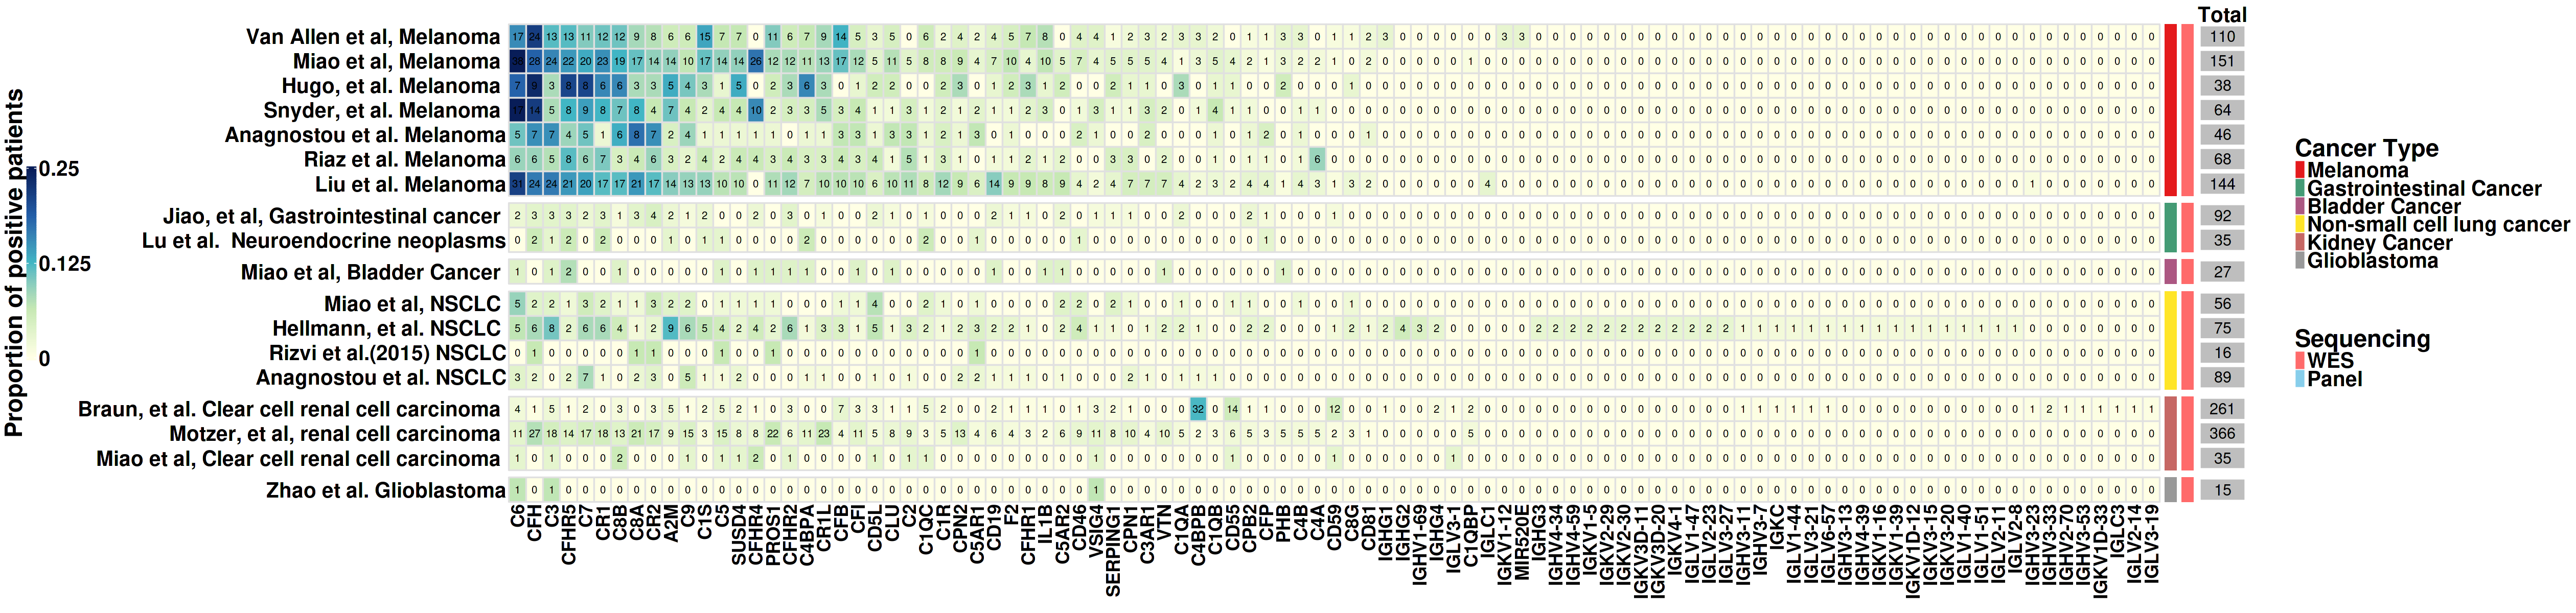

In [41]:
library(circlize)
cancer_type =  c("Melanoma","Gastrointestinal Cancer","Bladder Cancer",
                     "Non-small cell lung cancer","Kidney Cancer","Glioblastoma"
                    )
# a = colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))(10)
a = colorRampPalette(RColorBrewer::brewer.pal(9,"Set1"))(6)
names(a) = cancer_type

row_ha1 = HeatmapAnnotation(
        show_legend = F,
        which = "row",
        CancerType=meta[WES_names,"Cancer_type2"],
        col = list(CancerType = a),
        show_annotation_name = F,
        annotation_legend_param  = list(
                                            title = "Cancer_Type", legend_height = unit(8, "cm"),
                                            title_gp = gpar(fontsize = 18,fontface = "bold"),
                                            labels_gp = gpar(fontsize = 18,fontface = "bold"),
                                            title_position = "leftcenter-rot"
                                       )

    )

row_ha2 = HeatmapAnnotation(
        show_legend = F,
        which = "row",
        Sequencing=factor(meta[WES_names,"Sequencing"],levels = c("WES","Panel")),
        col = list(Sequencing = c("WES"="indianred1","Panel"="skyblue")),
        show_annotation_name = F,
        annotation_legend_param  = list(
                                            title = "Sequencing", legend_height = unit(8, "cm"),
                                            title_gp = gpar(fontsize = 18,fontface = "bold"),
                                            labels_gp = gpar(fontsize = 18,fontface = "bold"),
                                            title_position = "leftcenter-rot"
                                       )

    )

ht = Heatmap(as.matrix(pat_mut_pro),
#              width = ncol(pat_mut_pro)*unit(7, "mm"),height = length(WES_names)*unit(10, "mm"),
#              heatmap_height = unit(20,"cm"),
#              heatmap_width = unit(50,"cm"),
             row_names_side = "left",
             column_names_side = "bottom",
#              row_split = factor(meta[rownames(hm),"Cancer_type2"],levels = c("Melanoma","Gastrointestinal Cancer","Urothelial Cancer","Renal Cell Carcinoma",
#                                                                                 "Non-small cell lung cancer","Glioblastoma","Hepatocellular carcinoma","Head and Neck Cancer","Breast Cancer","Pan-cancer")),
             row_split = factor(meta[WES_names,"Cancer_type2"],levels = c("Melanoma","Gastrointestinal Cancer","Bladder Cancer",
                                                                                "Non-small cell lung cancer","Kidney Cancer","Glioblastoma")),
#              row_split = factor(pat_mut_num$Sequencing,levels = c("WES","Panel")),
             row_title = NULL,
             row_gap = unit(3, "mm"),
             row_names_max_width = max_text_width(WES_names,gp = gpar(fontsize = 12)),
             column_names_max_height = max_text_width(colnames(pat_mut_pro),gp = gpar(cex = 22)),
             row_names_gp = gpar(fontface = "bold",cex = 2),
             column_names_gp = gpar(fontface = "bold",cex = 1.8),
        heatmap_legend_param = list(title = "Proportion of positive patients", legend_height = unit(8, "cm"),
                                    title_gp = gpar(fontsize = 28,fontface = "bold"),
                                    labels_gp = gpar(fontsize = 24,fontface = "bold"),
                                    title_position = "leftcenter-rot",
                                    at = c( 0,0.125,0.25)),
        col = colorRamp2(c( 0,0.125/2,0.125,0.125+0.125/2, 0.25), c("#FFFFE5","#C7E9B4", "#41B6C4","#225EA8","#081D58")),
        cluster_rows = F,
        cluster_columns = F,
        rect_gp = gpar(col = "grey88", lwd = 2),
        layer_fun = function(j, i, x, y, w, h, fill){
            v = pindex(as.matrix(pat_mut_num[WES_names,colnames(pat_mut_pro)]), i, j)
            grid.text(v,x, y,gp = gpar(fontsize = 12,col="black"))
        }
       )

tn = pat_mut_num$Cohort_size
names(tn) = rownames(pat_mut_num)
n = nrow(pat_mut_pro)

ha = Heatmap(tn[ WES_names ],
             row_names_side = "left",
#              row_names_gp = gpar(fontface = "bold",cex = 1.5),
#              row_names_max_width = max_text_width(rownames(hm),gp = gpar(fontsize = 12)),
             column_names_centered = T,
             show_heatmap_legend = F,
             width = unit(2, "cm"),
             column_names_gp = gpar(fontface = "bold",cex = 2,angle = 45),
             rect_gp = gpar(col = "white", lwd = 5),
             name = "Total",
             col = rep("gray",n),
             column_names_rot =0,
             cluster_rows = F,
             column_names_side = "top",
             cell_fun = function(j, i, x, y, width, height, fill){
               
               grid.text( as.matrix(tn)[i, j], x, y, gp = gpar(fontsize =18))
               
             }
            )

    l1 =  Legend(
            labels = cancer_type,
            title = "Cancer Type",
            legend_gp = gpar(fill = a,fontsize = 20),
            title_gp = gpar(col = "black", fontsize = 28,fontface="bold"),
            labels_gp = gpar(col = "black", fontsize = 24,fontface="bold")
        )
    l2 = Legend(
            labels = c("WES","Panel"),
            title = "Sequencing",
            legend_gp = gpar(fill = c("indianred1","skyblue"),fontsize = 20),
            title_gp = gpar(col = "black", fontsize = 28,fontface="bold"),
            labels_gp = gpar(col = "black", fontsize = 24,fontface="bold")
        )

    options(repr.plot.height = 10, repr.plot.width = 42)

    ht_opt$HEATMAP_LEGEND_PADDING = unit(9, "cm")
    ht_opt$ANNOTATION_LEGEND_PADDING = unit(2, "cm")
    draw(ht+row_ha1+row_ha2+ha,
         heatmap_legend_side ="left",
         annotation_legend_side = "right",
         annotation_legend_list = packLegend(l1,l2,row_gap = unit(2.5,"cm"),gap = unit(2.5,"cm"))
        )

In [42]:
pdf("Artical_Figure2/Figure 2/Complement2.pdf",width = 45,height = 15)
    ht_opt$HEATMAP_LEGEND_PADDING = unit(9, "cm")
    ht_opt$ANNOTATION_LEGEND_PADDING = unit(2, "cm")
    draw(ht+row_ha1+row_ha2+ha,
         heatmap_legend_side ="left",
         annotation_legend_side = "right",
         annotation_legend_list = packLegend(l1,l2,row_gap = unit(2.5,"cm"),gap = unit(2.5,"cm"))
        )
dev.off()

png 
  2

##### TCGA -- mutation frequencies

In [42]:
TCGA_names = setdiff(names(TCGA),c("DLBC","LAML"))
library(RColorBrewer)
res = vector()
for(i in TCGA_names){
  res2 = vector()
  tmp = as.data.frame(TCGA[[i]]$maf@data)
  for(j in unique(pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])){
    res2 = c(res2,length(unique(tmp[tmp$Hugo_Symbol %in% j,"Tumor_Sample_Barcode"])))
    
  }
  res = rbind(res,res2)
}

rownames(res) = TCGA_names
colnames(res) = unique(pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])
res = t(res)

res2 = vector()
for(i in TCGA_names){
  tmp = as.data.frame(TCGA[[i]]$maf@data)
  mut_p_n = length(unique(tmp$Tumor_Sample_Barcode[tmp$Hugo_Symbol %in% unique(pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]])]))
  res2 = c(res2,mut_p_n)
}

names(res2) = TCGA_names

cts = as.data.frame(matrix(rep(0,33*9),nrow = 9))
colnames(cts) = TCGA_names
rownames(cts) = levels(TCGA$ACC$maf@data$Variant_Classification)

for(i in TCGA_names){
  tmp = table(TCGA[[i]]$maf@data$Variant_Classification[TCGA[[i]]$maf@data$Hugo_Symbol %in% rownames(res)])
#   message(i,length(tmp))
  cts[names(tmp),i] = tmp
}



gts = as.data.frame(matrix(rep(0,nrow(res)*9),nrow = 9))
colnames(gts) = rownames(res)
rownames(gts) = levels(TCGA$ACC$maf@data$Variant_Classification)

for(i in rownames(res)){
  for(j in TCGA_names){
    tmp = table(TCGA[[j]]$maf@data$Variant_Classification[TCGA[[j]]$maf@data$Hugo_Symbol %in% i])
    if(length(tmp) != 0){
      gts[names(tmp),i] = gts[names(tmp),i] + tmp
    }
  }
  
}


cts = t(cts)
cts = as.data.frame(cts)
gts = t(gts)
gts = as.data.frame(gts)
gts = gts/rowSums(gts)
gts[is.na(gts)] = 0
cts = cts/rowSums(cts)
cts[is.na(cts)] = 0

In [43]:
tp = vector()
for(i in names(res2)){
   tp = c(tp,as.numeric(TCGA[[i]]$maf@summary[TCGA[[i]]$maf@summary$ID =="Samples",][["summary"]]))
}
names(tp) = names(res2)

In [44]:
dm = t(res[,names(sort(res2/tp,decreasing = T))])

mf = dm/tp[rownames(dm)]


dm = dm[,names(sort(colSums(mf),decreasing = T))]

gts = gts[colnames(dm),]
cts = cts[rownames(dm),]

In [45]:
mf = round(mf[rownames(dm),colnames(dm)],2)

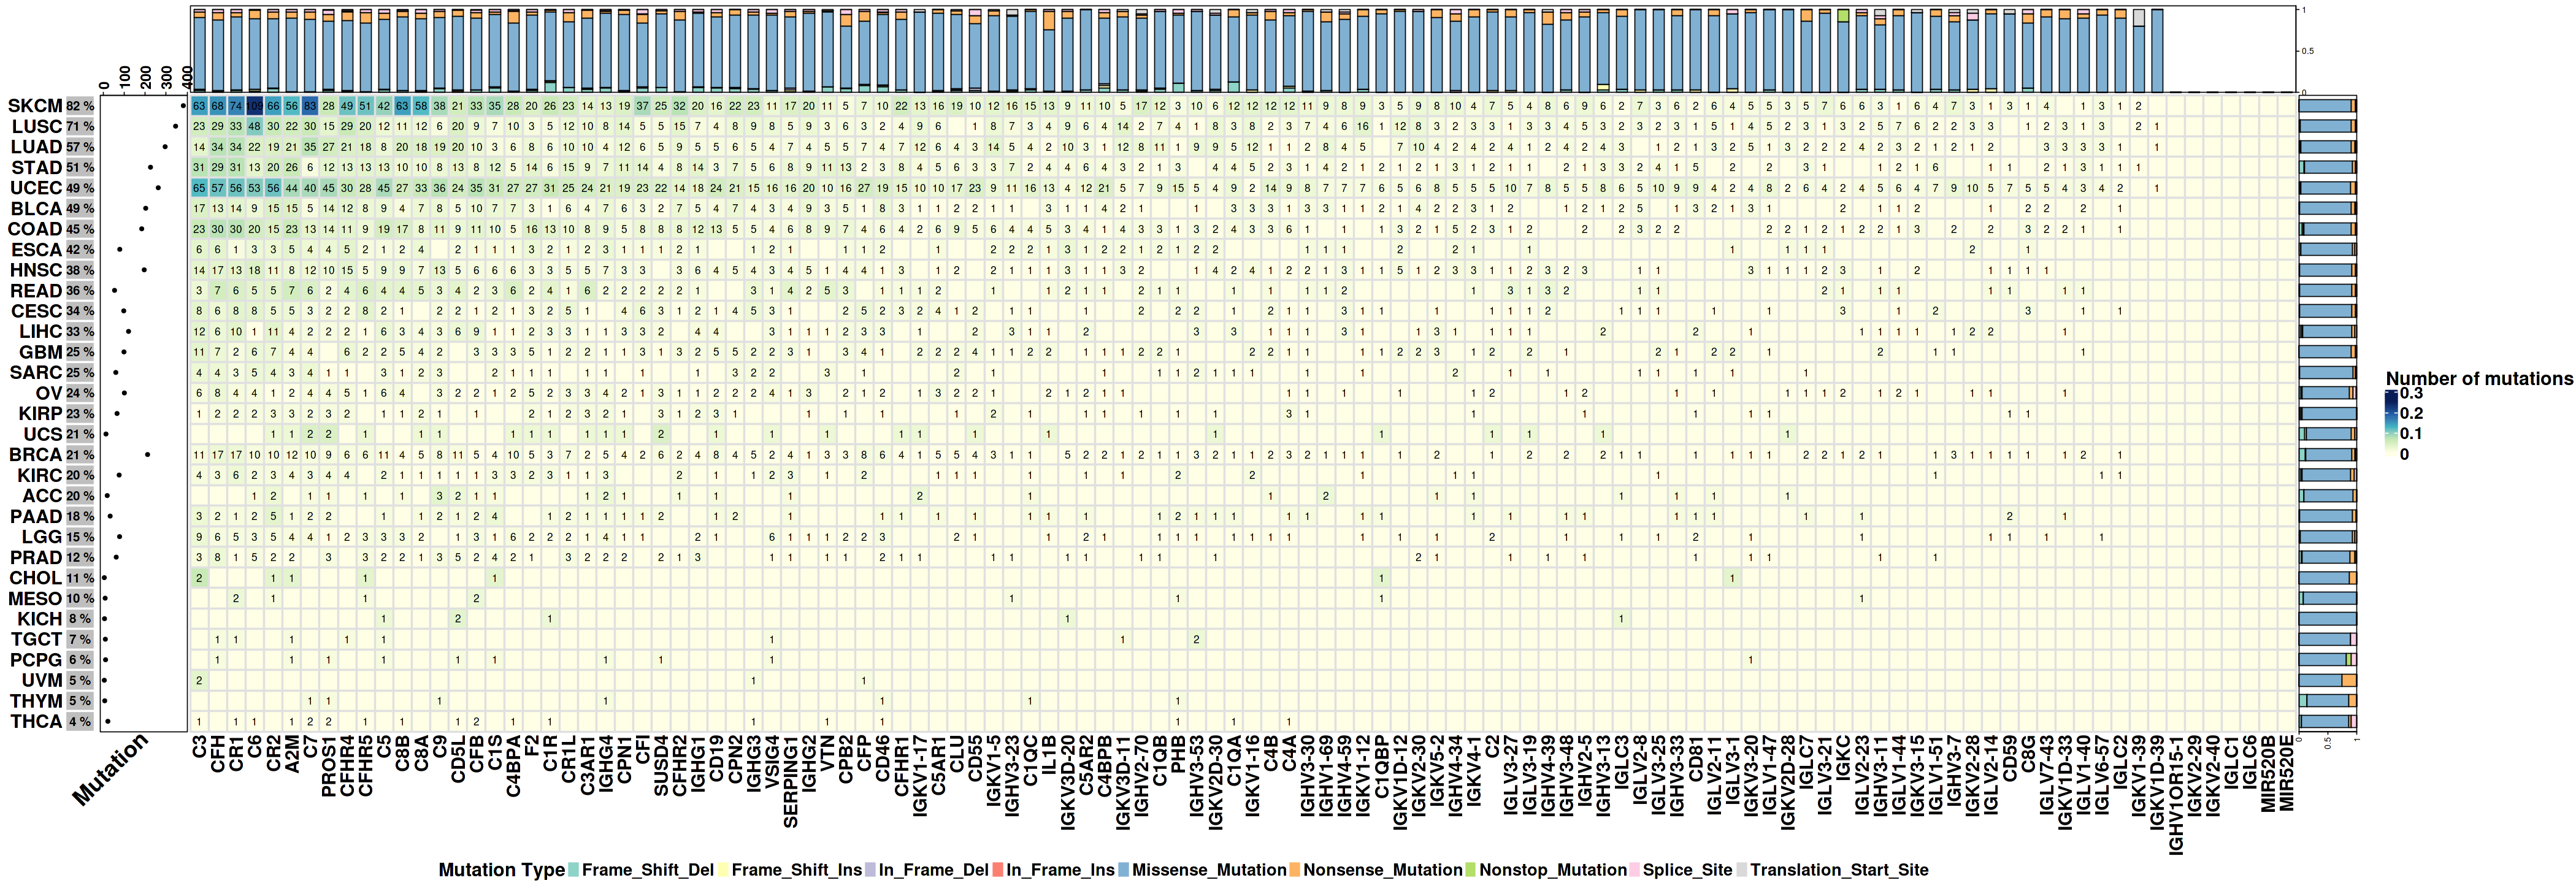

In [46]:
options(repr.plot.height = 12, repr.plot.width = 35)

col_fun = colorRamp2(c(0,45,150), c( "white","red2", "red3"))
h1 = Heatmap(mf,
             cluster_columns = F,
             
             cluster_rows = F,
             col = colorRamp2(c( 0,0.125/2,0.125,0.125+0.125/2, 0.25), c("#FFFFE5","#C7E9B4", "#41B6C4","#225EA8","#081D58")),
             row_names_side = "left",
             row_dend_side = "right",
             row_names_gp = gpar(fontsize = 18,fontface = "bold"),
             column_names_rot = 90,
             column_names_gp = gpar(fontsize = 18,fontface = "bold"),
             show_heatmap_legend = T,
             rect_gp = gpar(col = "grey88", lwd = 2),
             name = "Number of mutations",
             top_annotation = HeatmapAnnotation(Mutation_type = anno_barplot(gts,gp = gpar(fill = brewer.pal(9,"Set3")),axis_param = list(side = "right")),
                                                height = unit(3, "cm"),
                                                show_annotation_name = F),
             right_annotation = rowAnnotation(foo = anno_barplot(cts,gp = gpar(fill = brewer.pal(9,"Set3"))),
                                              width = unit(2, "cm"),
                                              show_annotation_name = F),
             left_annotation = HeatmapAnnotation(which = "row",
                                                 width = unit(3,"cm"),
                                                 `Mutation` = anno_points(
                                                                                    axis_param = list(side = "top",
                                                                                               gp = gpar(fontsize = 14,fontface = "bold")),
#                                                                                     gp = gpar(col = c(rep("red",9),rep("black",33-9))),
                                                                                    res2[rownames(dm)]
                                                     
                                                                                   
                                                                  ),
                                                 annotation_name_gp = gpar(fontsize = 22,fontface = "bold"),
                                                 annotation_name_rot = 45
                                                ),
             cell_fun =  function(j, i, x, y, width, height, fill) {
               if(dm[i, j] != 0){
                 grid.text(dm[i, j], x, y, gp = gpar(fontsize = 10))
               }
             },
             heatmap_legend_param = list(
               legend_direction = "vertical",
               labels_gp = gpar(fontsize = 16,fontface = "bold"), 
               title_gp = gpar(fontsize = 18,fontface = "bold")
             )
)

res3 = names(res2[rownames(dm)])
names(res3) = names(res2[rownames(dm)])
h2 = Heatmap(res3,cluster_rows = F,
             row_names_side = "left",
             row_names_gp = gpar(fontsize = 18,fontface = "bold"),
             show_heatmap_legend = F,
             name = " ",
             width = unit(1, "cm"), 
             rect_gp = gpar(col = "white", lwd = 2),
             col = rep("gray",length(TCGA_names)),
             cell_fun = function(j, i, x, y, width, height, fill){
               
               grid.text( as.matrix(paste(round(res2[rownames(dm)]/tp[rownames(dm)],2)*100,"%"))[i, j], x, y, gp = gpar(fontsize = 12,fontface = "bold"))
               
             })

ht_opt$HEATMAP_LEGEND_PADDING = unit(1, "cm")
ht_opt$ANNOTATION_LEGEND_PADDING = unit(0, "cm")
draw(h2 + h1,
     main_heatmap = "Number of mutations",
     heatmap_legend_side = "right",
     annotation_legend_side = "bottom",
     # align_heatmap_legend = "heatmap_top",
     align_annotation_legend = "heatmap_center",
     annotation_legend_list = list(
       Legend(labels = colnames(cts),
              labels_gp = gpar(fontsize = 16,fontface = "bold"), 
              title_gp = gpar(fontsize = 18,fontface = "bold"), 
              title = "Mutation Type", 
              type = "grid",
              legend_gp = gpar(fill = brewer.pal(9,"Set3")),
              ncol = 9,title_position = "leftcenter"
       )
     )
)

In [55]:
pdf("Artical_Figure2/Figure 2/Complement3.pdf",width = 35,height = 12)
    ht_opt$HEATMAP_LEGEND_PADDING = unit(1, "cm")
    ht_opt$ANNOTATION_LEGEND_PADDING = unit(0, "cm")
    draw(h2 + h1,
         main_heatmap = "Number of mutations",
         heatmap_legend_side = "right",
         annotation_legend_side = "bottom",
         # align_heatmap_legend = "heatmap_top",
         align_annotation_legend = "heatmap_center",
         annotation_legend_list = list(
           Legend(labels = colnames(cts),
                  labels_gp = gpar(fontsize = 16,fontface = "bold"), 
                  title_gp = gpar(fontsize = 18,fontface = "bold"), 
                  title = "Mutation Type", 
                  type = "grid",
                  legend_gp = gpar(fill = brewer.pal(9,"Set3")),
                  ncol = 9,title_position = "leftcenter"
           )
         )
    )
dev.off()

png 
  2

#### oncoplot

In [74]:
library(maftools)

maf1 = read.maf("/home/ncpsb/new_mnt/Other/jx/web/data/TCGA(panacanalt)/mc3.v0.2.8.PUBLIC.maf",isTCGA = F,useAll = T,removeDuplicatedVariants = T)

TCGA_PanCancer = readRDS("/srv/shiny-server/SNVIO_V10.1/data/TCGA/panacanlt_TCGA_log2.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

TCGA_cohort_cal_pm = function(TCGA,cancer_type,gene,Mut_type,Wild_type){
  if("All" %in% Mut_type){
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]
    ]))
  }else{
    mut = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[
      TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]] &
        TCGA[[cancer_type]]$maf@data$Variant_Classification %in% Mut_type
    ]))
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),mut) 
  }else{
    wt = setdiff(x = unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode)),
                 unique(as.character(TCGA[[cancer_type]]$maf@data$Tumor_Sample_Barcode[TCGA[[cancer_type]]$maf@data$Hugo_Symbol %in% pathway_list[[gene]]])))
  }
  return(list("mut" = mut,"wt" = wt))
}

anno = vector()
for(i in names(TCGA_PanCancer)){
    tmp_cohort = TCGA_cohort_cal_pm(TCGA_PanCancer,i,"GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION","All","Others")
    tmp_mut = tmp_cohort$mut
    tmp_wt = tmp_cohort$wt
    anno = rbind(anno,data.frame(Patient=tmp_mut,Cancer_Type=rep(i,length(tmp_mut)),Complement=rep("Mutation",length(tmp_mut))))
    anno = rbind(anno,data.frame(Patient=tmp_wt,Cancer_Type=rep(i,length(tmp_wt)),Complement=rep("Wildtype",length(tmp_wt))))
    
}
rownames(anno) = anno$Patient
anno$Patient = NULL
anno$Tumor_Sample_Barcode = rownames(anno)

total_maf_matrix = maf1@data
total_maf_matrix$Tumor_Sample_Barcode = gsub(pattern = "(TCGA-..-....)-.*",replacement = "\\1",x = maf1@data$Tumor_Sample_Barcode)

maf2 = read.maf(total_maf_matrix)
tmp_maf = subsetMaf(maf = maf2,tsb = rownames(anno))

pdf(file = "Artical_Figure2/Figure 2/Complement4.pdf",width = 20,height = 20)
oncoplot(maf = tmp_maf,bgCol = "white",
                   borderCol = NULL,
                   legendFontSize = 2,
                   gene_mar = 8,
                   removeNonMutated = FALSE,
                   legend_height=6,
                   fontSize = 1.2,
#                    annotationColor = tl,
                   annotationFontSize = 2,
                   annotationDat = anno,
                   clinicalFeatures = c("Complement","Cancer_Type"),
                   sortByAnnotation = T,
                   genes = maf1@gene.summary$Hugo_Symbol[maf1@gene.summary$Hugo_Symbol %in% pathway_list[["GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"]]][1:50]
                   )
dev.off()

-Reading
-Validating
--Removed 149782 duplicated variants
-Silent variants: 1288245 
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  SYNE1
  FLG
  USH2A
-Processing clinical data
--Missing clinical data
-Finished in 00:04:14 elapsed (00:04:27 cpu) 
-Validating
--Removed 2296 duplicated variants
-Summarizing
--Possible FLAGS among top ten genes:
  TTN
  MUC16
  SYNE1
  FLG
  USH2A
-Processing clinical data
--Missing clinical data
-Finished in 00:03:13 elapsed (00:03:14 cpu) 


png 
  2

## compare with TMB

In [47]:
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)

Loading required package: ggpubr

Loading required package: magrittr

Loading required package: checkmate

Registered S3 methods overwritten by 'lme4':
  method                          from
  cooks.distance.influence.merMod car 
  influence.merMod                car 
  dfbeta.influence.merMod         car 
  dfbetas.influence.merMod        car 

Loading 'meta' package (version 6.2-0).
Type 'help(meta)' for a brief overview.
Readers of 'Meta-Analysis with R (Use R!)' should install
older version of 'meta' package: https://tinyurl.com/dt4y5drs


Attaching package: ‘epitools’


The following object is masked from ‘package:survival’:

    ratetable




In [48]:
All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")

In [49]:
datasets_mu = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_mutation_with_therapy.rds")

In [50]:
datasets_overview = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/datasets_overview.csv",quote = "")
datasets_names = read.csv("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F,row.names = 1)
colnames(datasets_names) = "Cohort_name"
datasets_overview = cbind(datasets_names,datasets_overview)
datasets_overview = datasets_overview[names(All),]

datasets_overview$OS = FALSE
datasets_overview$PFS = FALSE
datasets_overview$RECIST = FALSE
datasets_overview$RESPONSE = FALSE
datasets_overview$TMB = FALSE
datasets_overview$RNA = FALSE
for(i in rownames(datasets_overview)){
    if( "OS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"OS"] = TRUE}
    if( "PFS_TIME" %in% colnames(All[[i]]) ){datasets_overview[i,"PFS"] = TRUE}
    if( "RECIST" %in% colnames(All[[i]]) ){datasets_overview[i,"RECIST"] = TRUE}
    if( "RESPONSE" %in% colnames(All[[i]]) ){datasets_overview[i,"RESPONSE"] = TRUE}
    if( "TMB" %in% colnames(All[[i]]) ){datasets_overview[i,"TMB"] = TRUE}
}

In [51]:
dataset_meta = read.csv("/home/ncpsb/new_mnt/Other/jx/web/data/fast_explore/data/dataset_name.csv",header = F)
dataset_name = dataset_meta$V2
names(dataset_name) = dataset_meta$V1

In [52]:
datasets_names$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_names$Cohort_name)
datasets_overview$Cohort_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",datasets_overview$Cohort_name)

dataset_name = gsub(pattern = "[0-9]*\\. (.*).*\\(.*","\\1",dataset_name)

In [53]:
ref_cohort_cal_TMB = function(dataset,cutoff_ratio = 0.5){
  

    tmp_data = All[[dataset]]
    cutoff = quantile(na.omit(tmp_data[,"TMB"]),probs = 1-cutoff_ratio,na.rm = T)
    low = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) < cutoff]
    high = rownames(tmp_data)[!is.na(tmp_data[,"TMB"])][ na.omit(tmp_data[,"TMB"]) >= cutoff]
  
  return(list("low"=low,"high"=high))
  
}

ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

### TMB OS

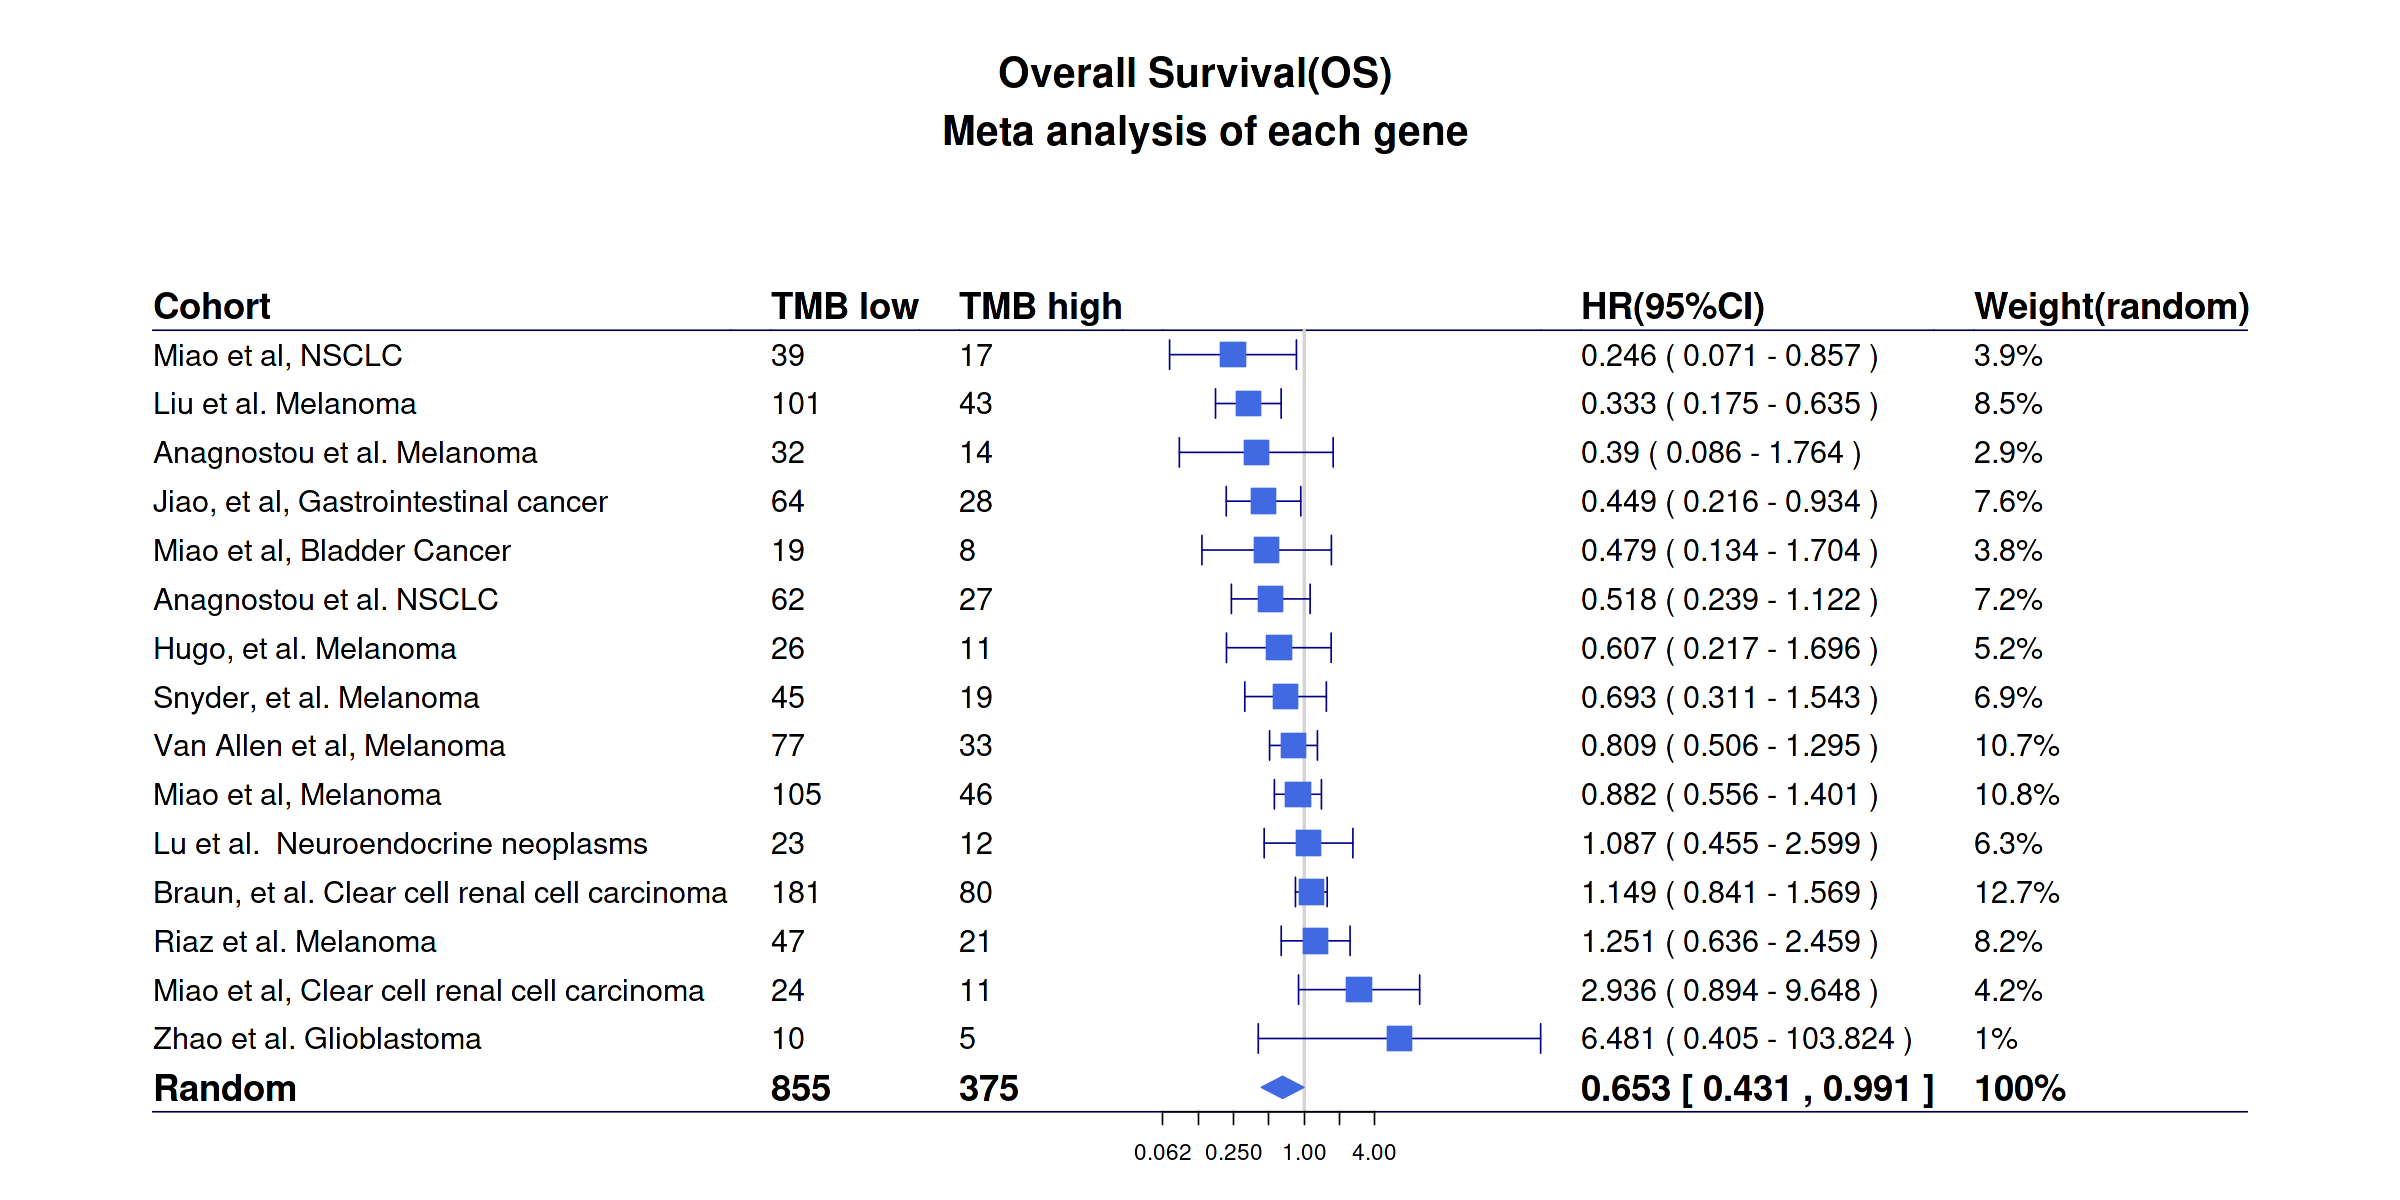

In [54]:
library(forestplot)
cohort = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))
      
    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }

    
    
    
  }
}

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"TMB low",low[ord],sum(low),sum(low)),
                  c(NA,"TMB high",high[ord],sum(high),sum(high)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_OS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_OS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")



options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 4,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

### TMB PFS

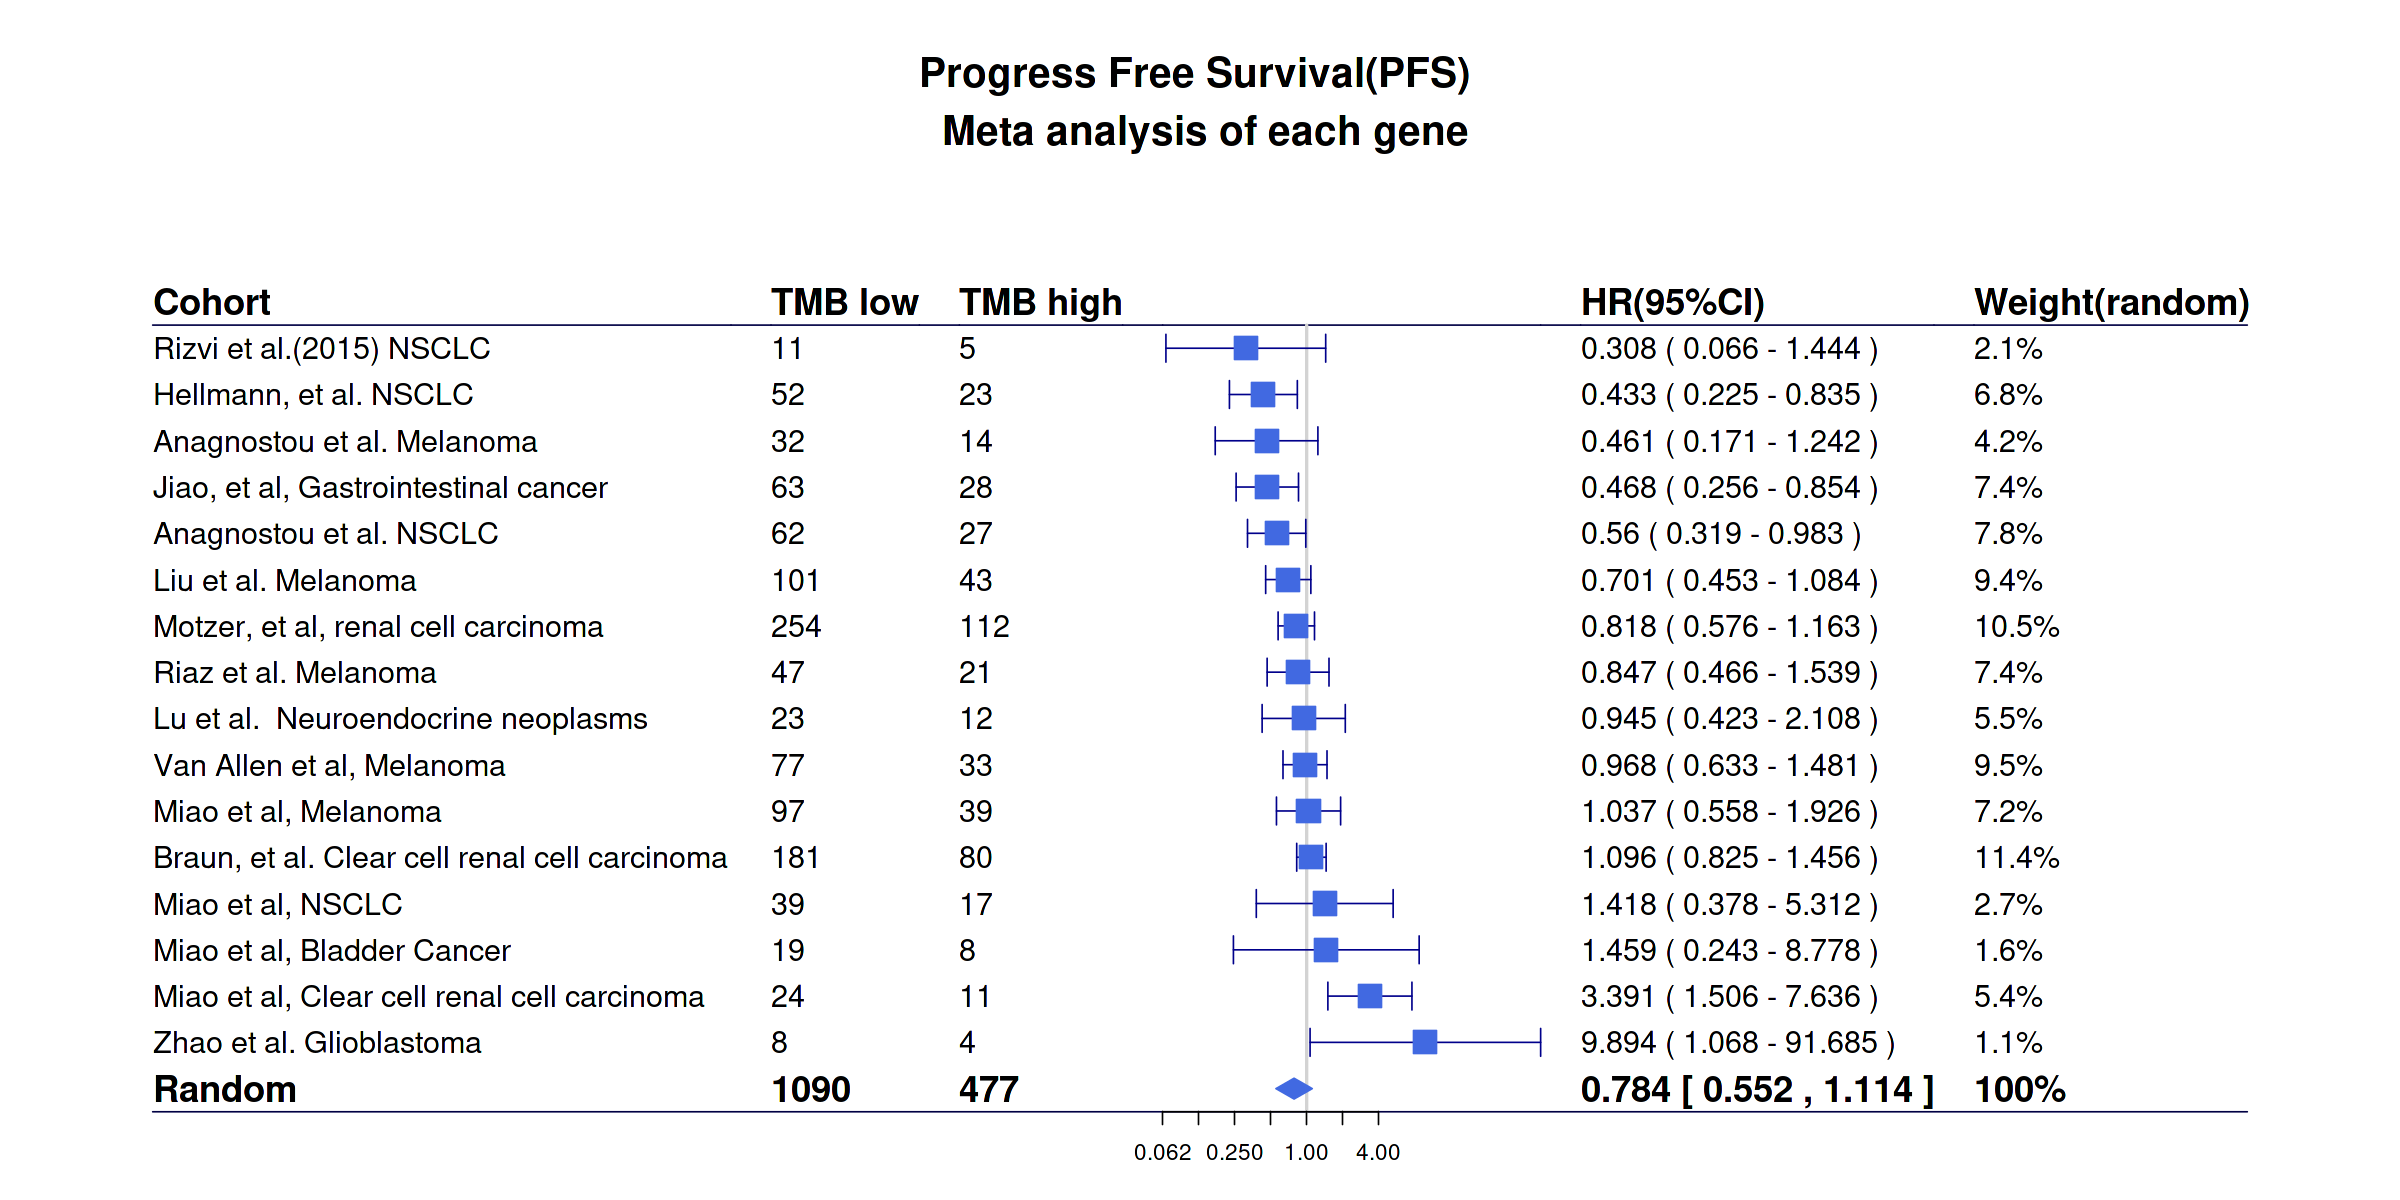

In [55]:
library(forestplot)
cohort = vector()
low = vector()
high = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("PFS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     low = c(low,length(tmp_cohort$low))
#     high = c(high,length(tmp_cohort$high))
    
    tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        low = c(low,table(tmp_data$groups)["TMB low"])
        high = c(high,table(tmp_data$groups)["TMB high"])


        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    
    }
    
  }
}

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"TMB low",low[ord],sum(low),sum(low)),
                  c(NA,"TMB high",high[ord],sum(high),sum(high)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_PFS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_PFS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_PFS_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_PFS_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 4,
#                      zero = 1,
                     title = paste("Progress Free Survival(PFS)","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

### TMB RECIST+RESPONSE

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

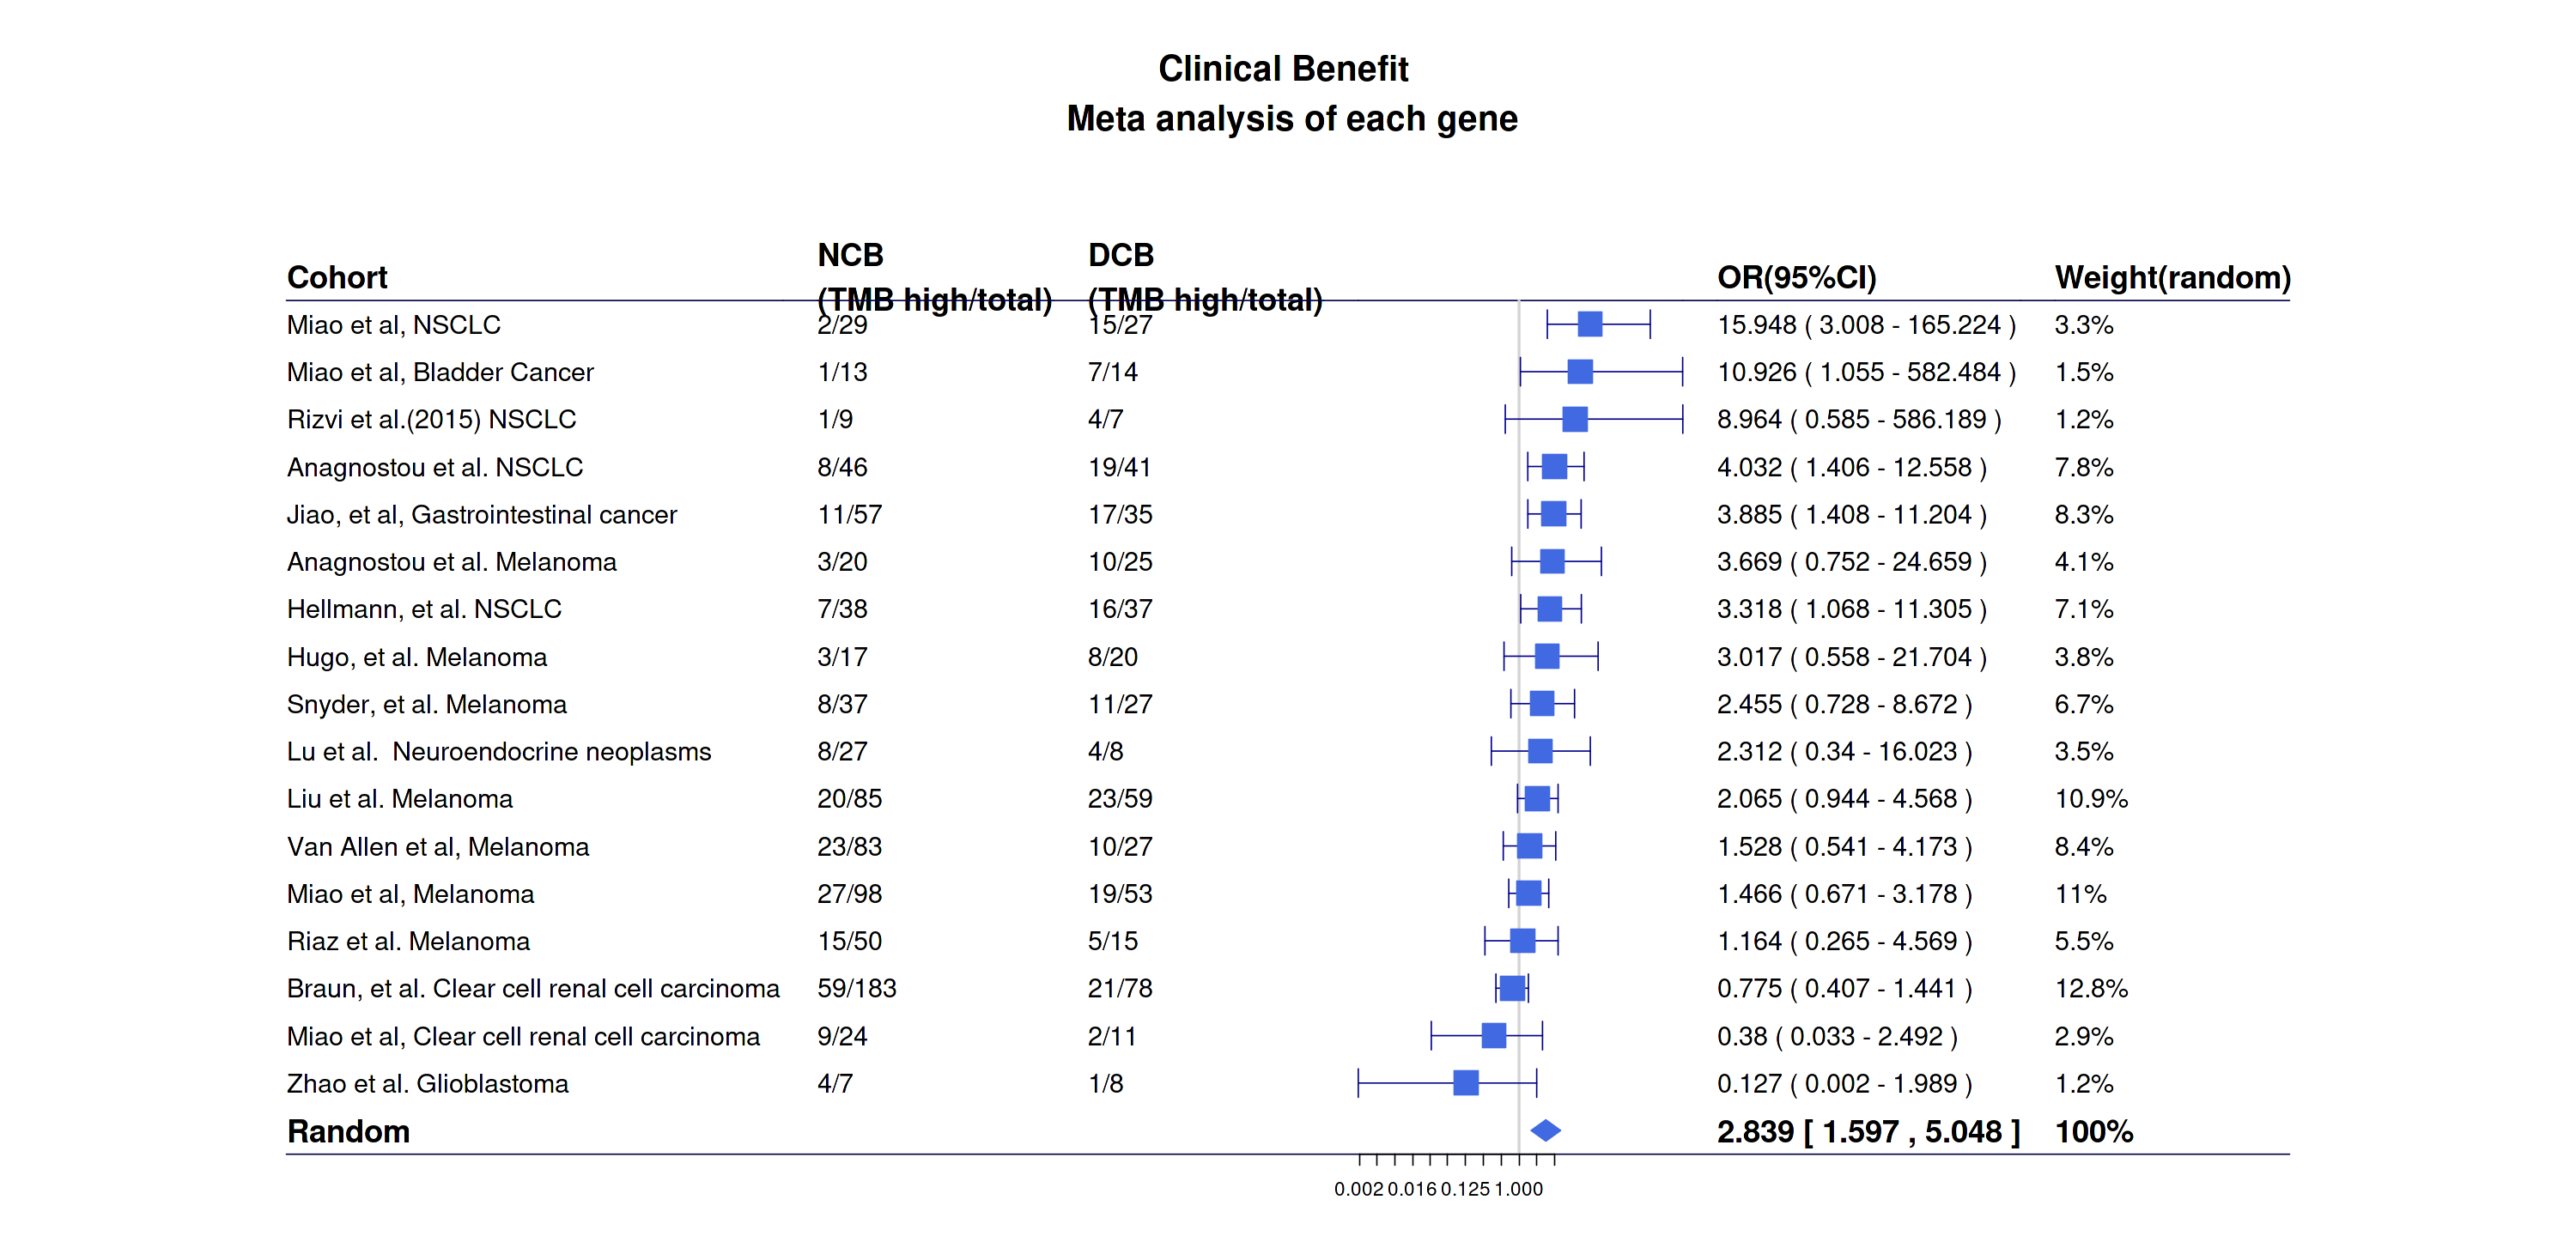

In [56]:
library(forestplot)
cohort = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_TMB(dataset = i,cutoff_ratio = 0.3)  
  if(length(tmp_cohort$high) >= 3 & length(tmp_cohort$low) >= 3 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
    
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["TMB high","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["TMB high","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3))
    
    }
    
  }else if(length(tmp_cohort$high) != 0 & length(tmp_cohort$low) != 0 & ("RECIST" %in% colnames(All[[i]]))){
          
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$high] = "TMB high"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$low] = "TMB low"
    tmp_data$groups = factor(tmp_data$groups,levels = c("TMB low","TMB high"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["TMB high"] >= 3 & table(tmp_data$groups)["TMB low"] >= 3 ){
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["TMB high","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["TMB high","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        }
  }
}

ord = order(OR_mean,decreasing = T)
tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(TMB high/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(TMB high/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)

)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$random$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    TMB_DR_tabletext = c("TMB",tabletext2[nrow(tabletext2),4],round(k$common$p,3))
    TMB_DR_cochrane_from_rmeta = cochrane_from_rmeta2[nrow(tabletext2),1:3]
}


maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")


options(repr.plot.height = 12, repr.plot.width = 25)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
#                  xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
#                      grid = structure(c(0.5, 2), 
#                             gp = gpar(lwd = 1,lty = 2, col = "#CCCCFF")),
                     boxsize = 0.5,
                     graph.pos = 4,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each gene"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

### Pathway mutation vs TMB OS

In [57]:
total_cochrane_from_rmeta = vector()
total_tabletext = vector()

target_pathway = c(rownames(OS_RS_matrix3)[1:10],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)])

for( p in rev(target_pathway)){
    
    pathway = p
    library(forestplot)
    cohort = vector()
    wildtype = vector()
    mutation = vector()
    HR_mean = vector()
    HR_lower = vector()
    HR_upper = vector()
    HR_text = vector()
    logtest = vector()
    waldtest = vector()
    for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = pathway,dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#         cohort = c(cohort,dataset_name[i])
#         wildtype = c(wildtype,length(tmp_cohort$wt))
#         mutation = c(mutation,length(tmp_cohort$mut))

        tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
            mutation = c(mutation,table(tmp_data$groups)["Mutation"])

            # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
            coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
            logtest = c(logtest,round(summary(coxres)$logtest[3],3))
            waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
            
            
        }

      }
    }

    ord = order(HR_mean)
    tabletext = cbind(
                      c(NA,"Cohort",cohort[ord],"Common","Random"),
                      c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                      c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                      c(NA,"HR(95%CI)",HR_text[ord],NA,NA),
    #                   c(NA,"P value(Log rank)",logtest[ord],NA),
                      c(NA,"P value(wald text)",waldtest[ord],NA,NA))
    cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

    tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
    rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
    tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
    m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
    k = summary(m)

    chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
    tabletext[nrow(tabletext)-1,4:5] = c(chtext,round(k$common$p,3))
    cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
    rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
    tabletext[nrow(tabletext),4:5] = c(rhtext,round(k$random$p,3))
    cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))
    
    if(k$pval.Q < 0.1){
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext),])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext),]))
    }else{
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext)-1,])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext)-1,]))
    }   
    
    
}



Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


In [58]:
total_tabletext = total_tabletext[,c(1,5,6)]
total_tabletext = rbind(total_tabletext,TMB_OS_tabletext)
total_tabletext[,3][as.numeric(total_tabletext[,3]) < 0.001] = "< 0.001"
total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,TMB_OS_cochrane_from_rmeta)

total_tabletext = rbind(c("Pathway","HR(95%CI)","P-meta"),total_tabletext)
total_cochrane_from_rmeta = rbind(c(NA,NA,NA),total_cochrane_from_rmeta)

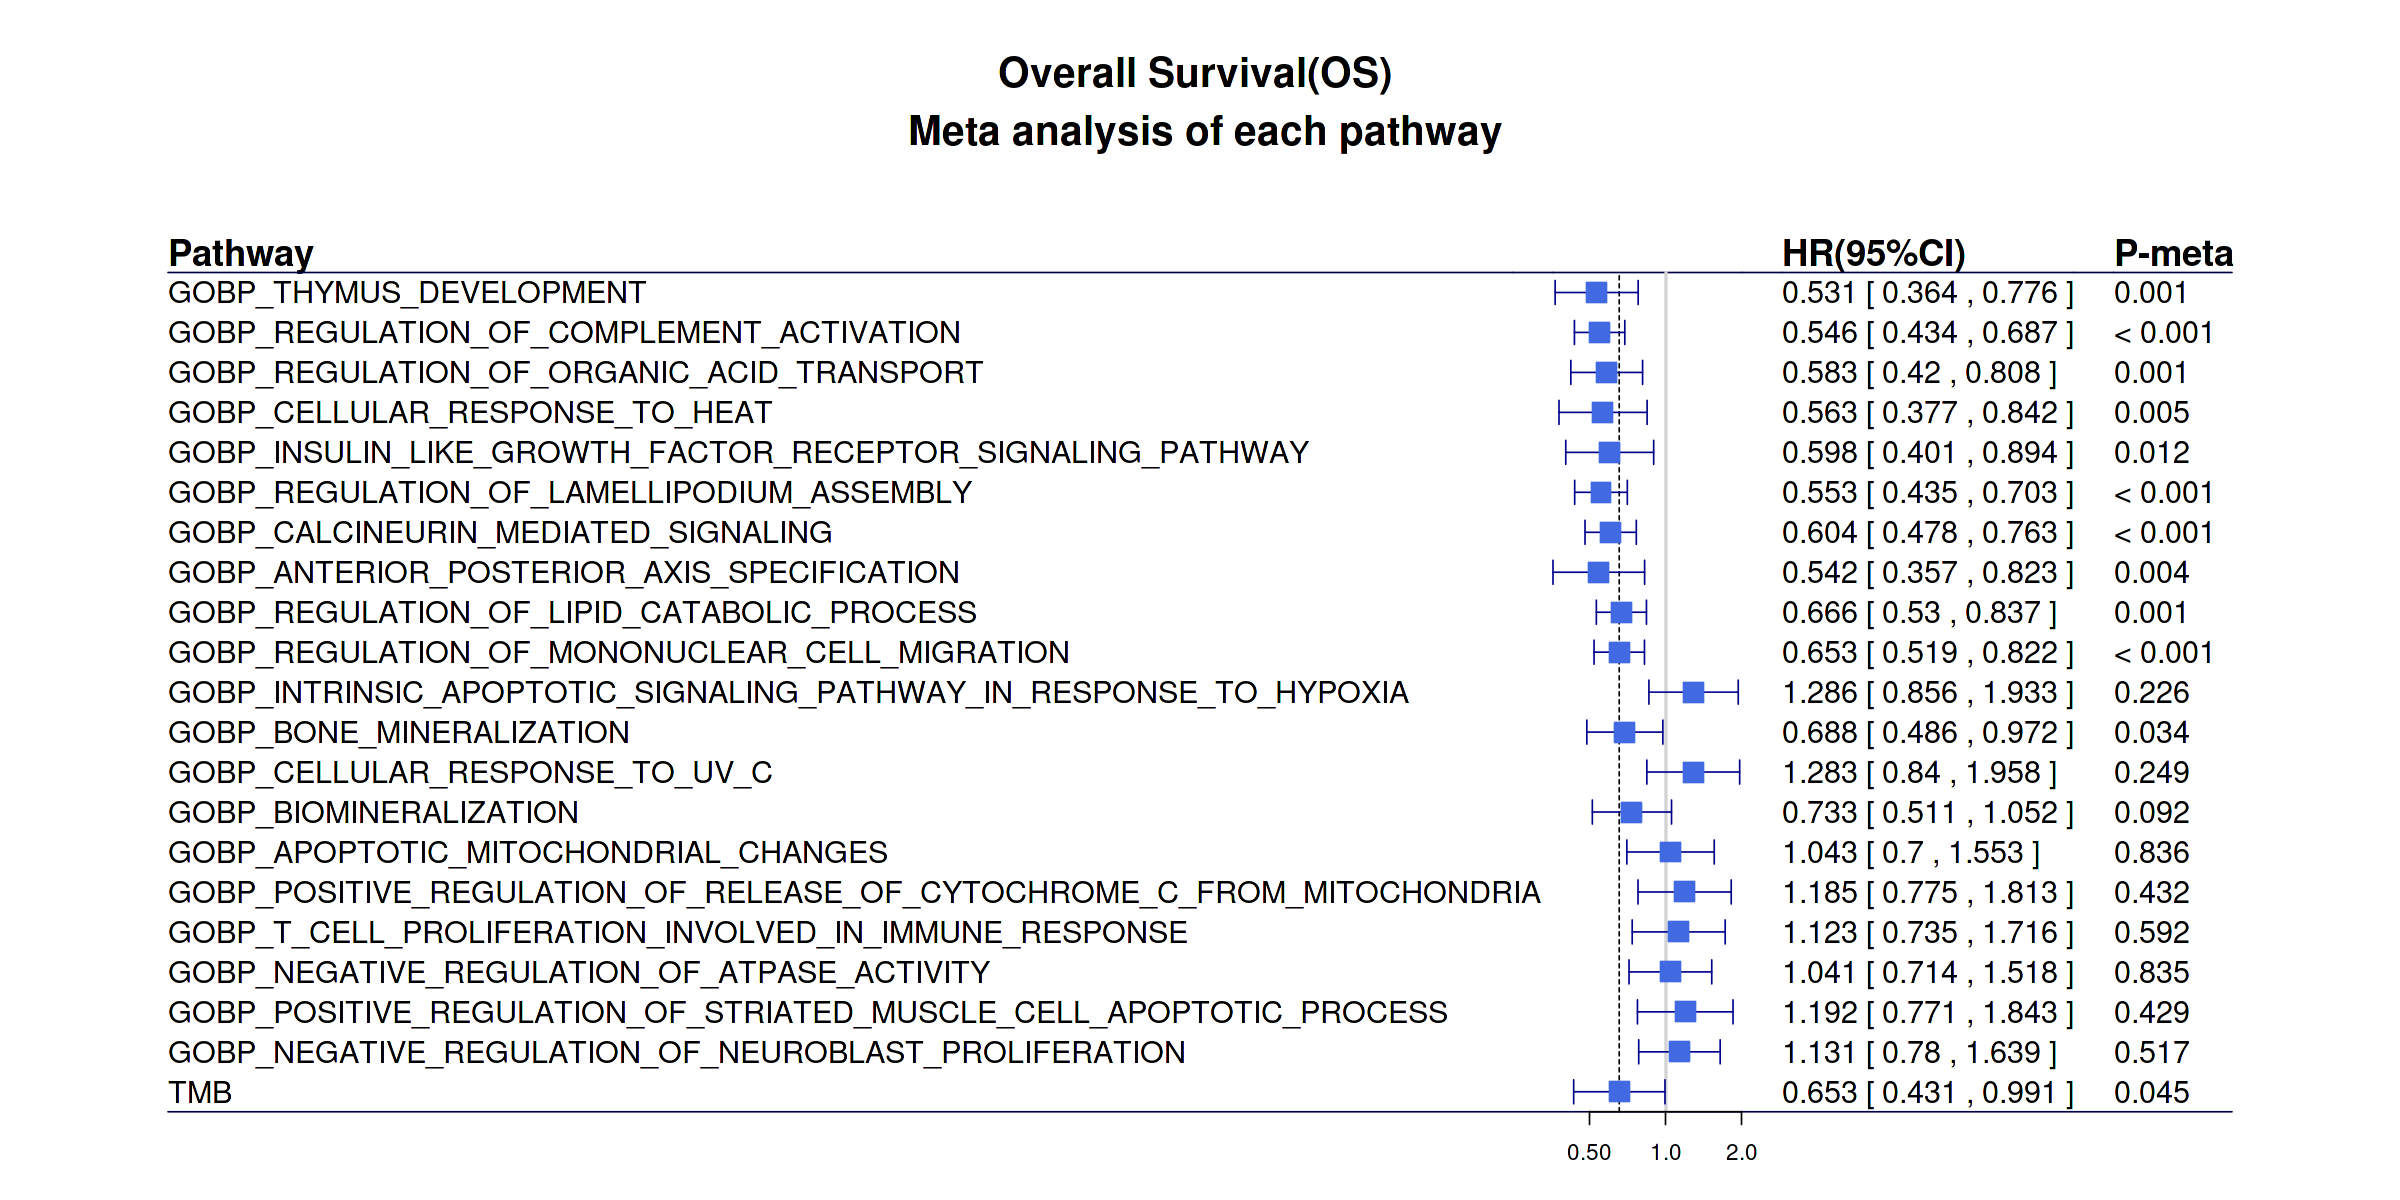

In [59]:
maxup = max(total_cochrane_from_rmeta$upper[!is.infinite(total_cochrane_from_rmeta$upper)],na.rm = T)
minlow = min(total_cochrane_from_rmeta$lower[total_cochrane_from_rmeta$lower != 0],na.rm = T)

    
options(repr.plot.height = 10, repr.plot.width = 20)

tmp_list = list()
tmp_list[["2"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(total_cochrane_from_rmeta) + 1)]] = gpar(col = "#000044")


p = total_cochrane_from_rmeta %>% 
       forestplot(labeltext = total_tabletext, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(4,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
                     grid = structure(c(TMB_OS_cochrane_from_rmeta[,1]), 
                            gp = gpar(lwd = 1,lty = 2, col = "black")),
                     boxsize = 0.5,
                     graph.pos = 2,
#                      zero = 1,
                     title = paste("Overall Survival(OS)","\n","Meta analysis of each pathway"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                     is.summary = c(rep(TRUE, 1), rep(FALSE, nrow(total_cochrane_from_rmeta)-1)),
                     xlog = TRUE, 
                     hrzl_lines = tmp_list,
                     vertices = TRUE,
                     col = fpColors(box = "royalblue",
                                    line = "darkblue",
                                    summary = "royalblue")
                     )
p

In [69]:
pdf("Artical_Figure2/Figure 2/Complement_VS_TMB_OS.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [60]:
total_cochrane_from_rmeta$pn = total_tabletext[,1]
total_cochrane_from_rmeta = total_cochrane_from_rmeta[2:22,]
total_cochrane_from_rmeta$pn = factor(total_cochrane_from_rmeta$pn,levels = rev(total_cochrane_from_rmeta$pn),labels = levels(tmp_matrix$gene))

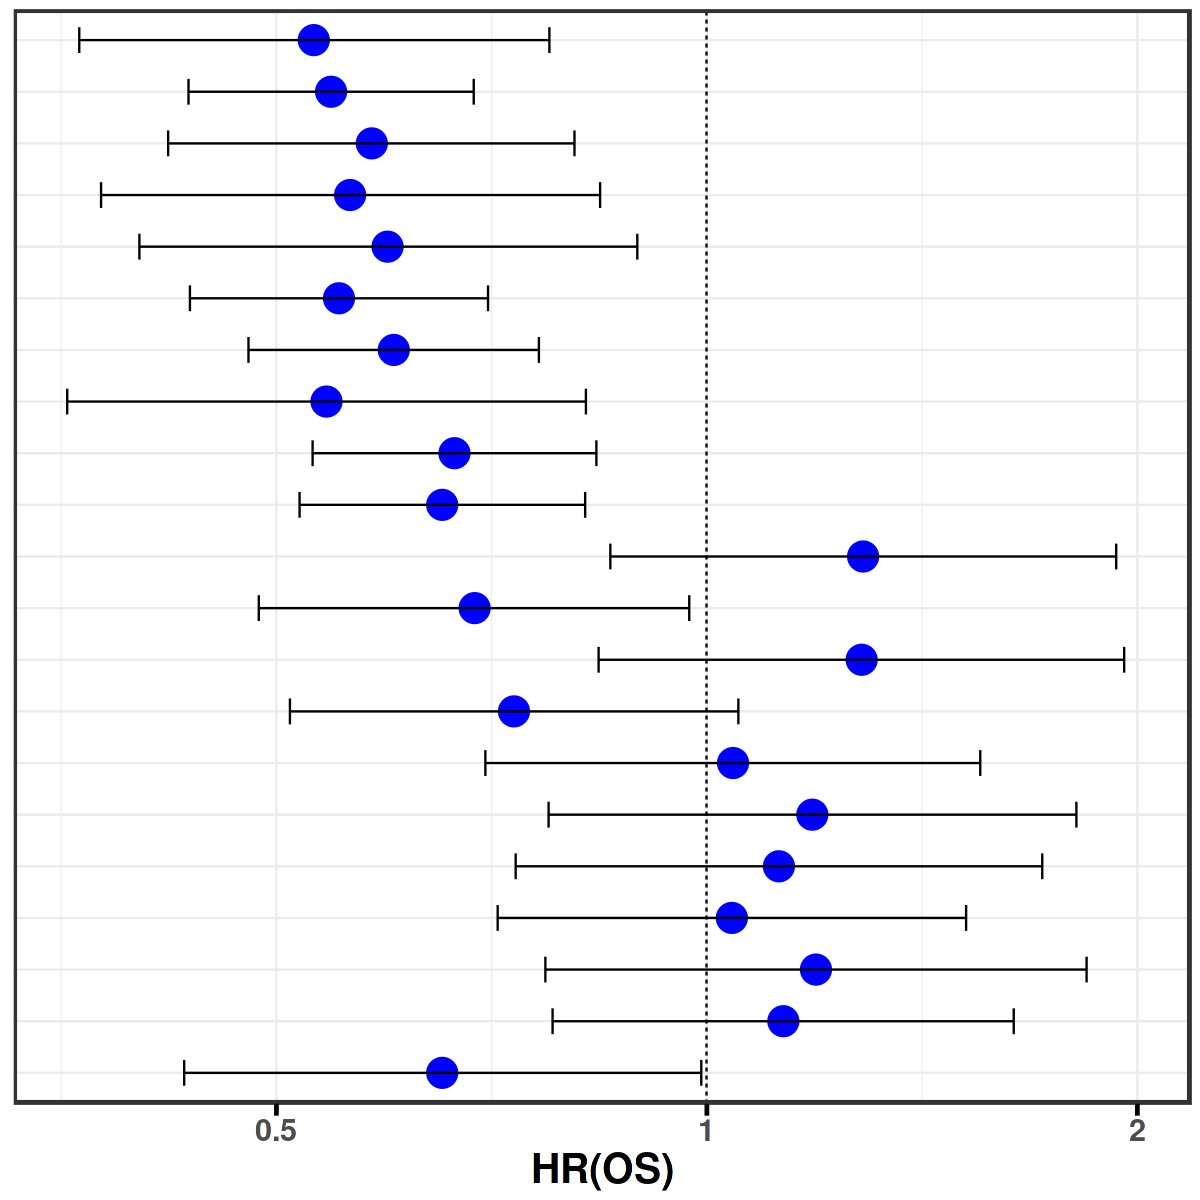

In [61]:
options(repr.plot.height = 10, repr.plot.width = 10)
p_OS = ggplot(total_cochrane_from_rmeta)+
    geom_point(aes(x = log2(mean),y = pn),size = 8,color = "blue")+
    geom_vline(xintercept = 0,lty=2)+
    geom_errorbarh(aes(y = pn,xmax = log2(upper), xmin = log2(lower)), height = 0.5)+
    scale_x_continuous(breaks = c(-1,0,1),labels = c(0.5,1,2),
                       limits = c(min(log2(min(total_cochrane_from_rmeta$lower)),-1),max(log2(max(total_cochrane_from_rmeta$upper)),1))
                      )+
xlab("HR(OS)")+
    theme_bw()+
    theme(axis.title.y = element_blank(),
          panel.border = element_rect(size = 1.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
#           axis.line.y = element_blank(),
#           axis.line = element_line(colour = "black",linetype = "solid",size = 1),
          axis.ticks.length.x = unit(2.5,"mm"),
          axis.ticks.x = element_line(colour = "black",linetype = "solid",size = 1 ),
          axis.text.x = element_text(angle = 0,hjust = 0.5,size=18,face = "bold"),
          axis.title.x = element_text(face="bold",size = 24),
         )

p_OS

In [62]:
total_tabletext = as.data.frame(total_tabletext)[2:22,]
total_tabletext$V2 = factor(total_tabletext$V2,levels = rev(total_tabletext$V2))

In [63]:
OS_total_tabletext = total_tabletext

In [64]:
p_ost = ggplot(total_tabletext)+
    geom_text(aes(x = "HR(95%CI,OS)",y = V2,label = V2),fontface="bold")+
    geom_text(aes(x = "P-meta",y = V2,label = V3),fontface="bold")+
    # xlim(0,3)+
    theme_bw()+theme(panel.border = element_rect(size = 1.5),axis.text.y = element_blank(),axis.title = element_blank(),axis.text.x = element_text(size = 22,face="bold"),axis.ticks.y = element_blank())

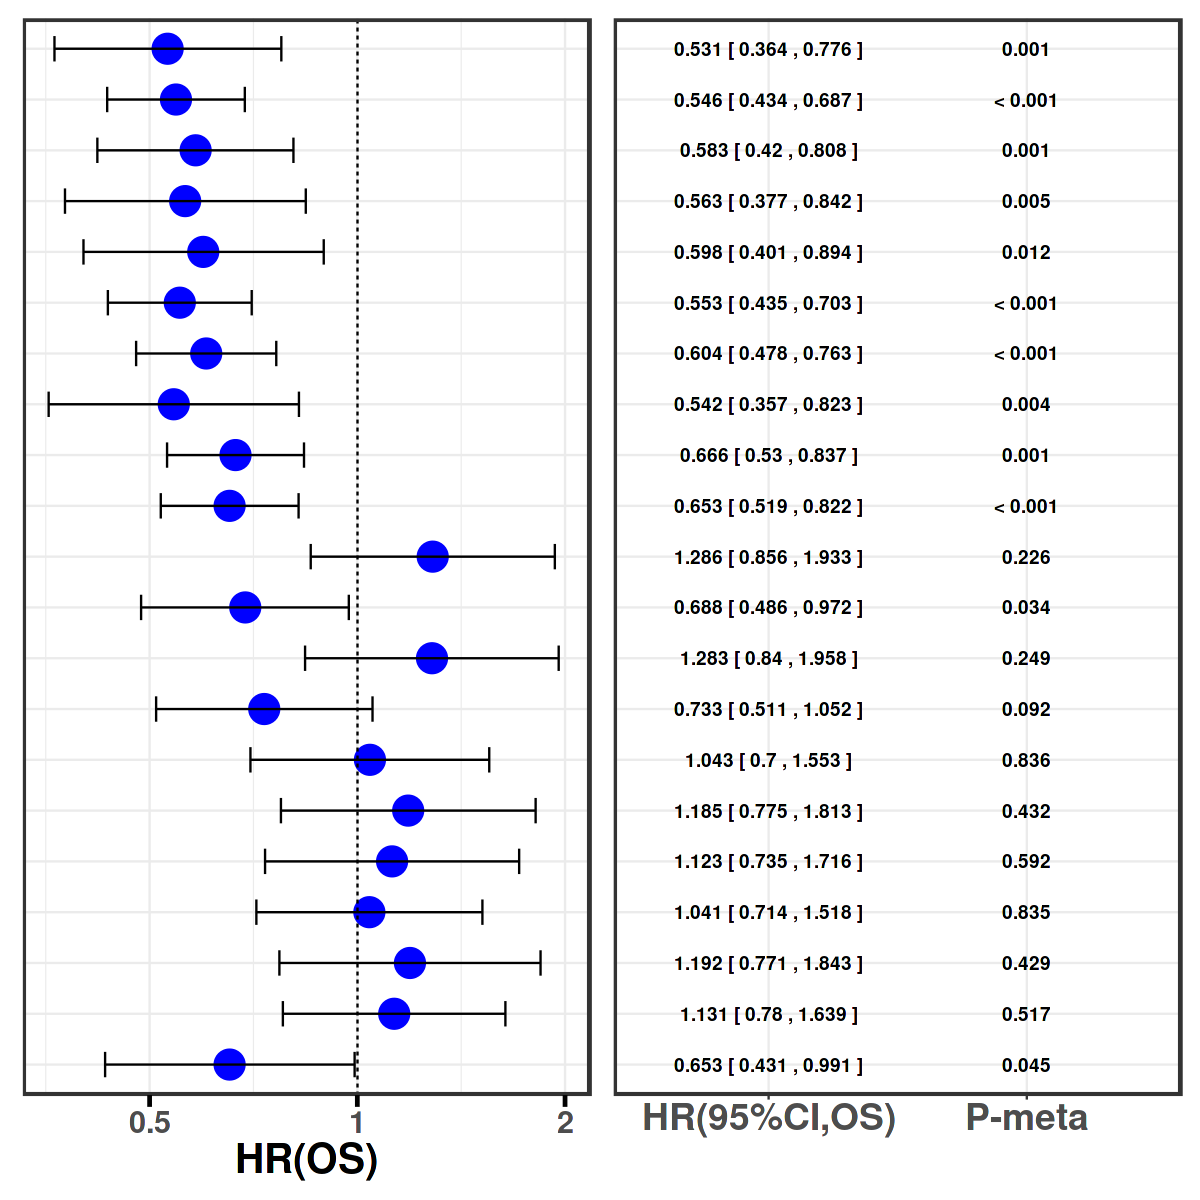

In [65]:
library(patchwork)
p_OS + p_ost + plot_layout(ncol = 2,width = c(2,2),guides = 'collect')

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


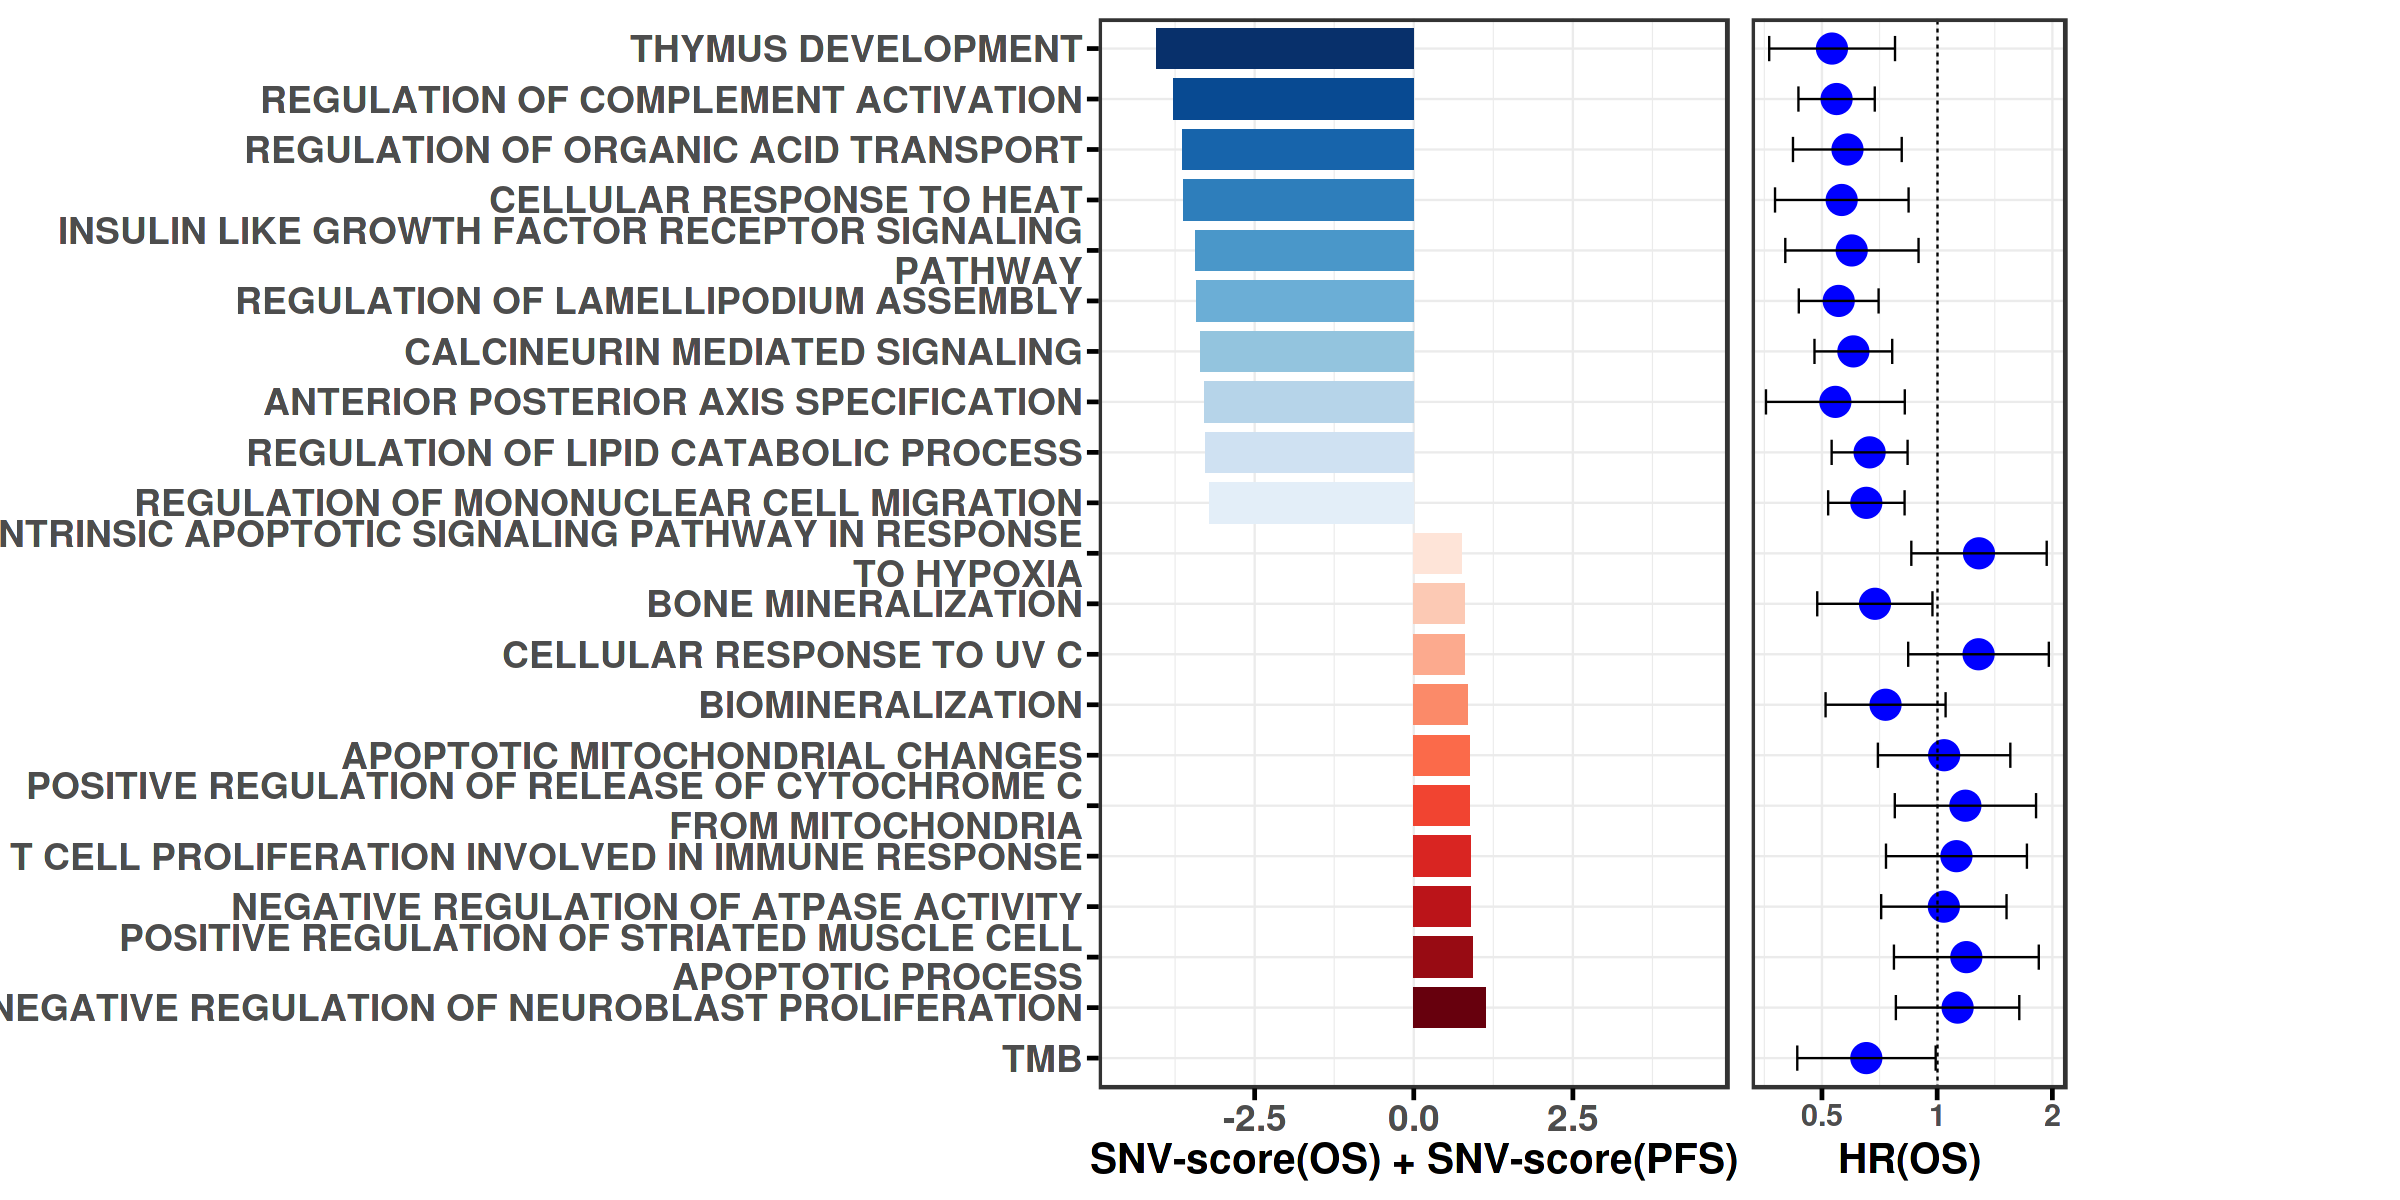

In [66]:
options(repr.plot.height = 10, repr.plot.width = 20)
p_bar + p_OS + plot_layout(ncol = 3,width = c(2,1,1),guides = 'collect')

In [70]:
total_cochrane_from_rmeta = vector()
total_tabletext = vector()

target_pathway = c(rownames(OS_RS_matrix3)[1:50],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-99):nrow(OS_RS_matrix3)])

for( p in rev(target_pathway)){
    
    pathway = p
    library(forestplot)
    cohort = vector()
    wildtype = vector()
    mutation = vector()
    HR_mean = vector()
    HR_lower = vector()
    HR_upper = vector()
    HR_text = vector()
    logtest = vector()
    waldtest = vector()
    for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = pathway,dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#         cohort = c(cohort,dataset_name[i])
#         wildtype = c(wildtype,length(tmp_cohort$wt))
#         mutation = c(mutation,length(tmp_cohort$mut))

        tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
            mutation = c(mutation,table(tmp_data$groups)["Mutation"])

            # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
            coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
            logtest = c(logtest,round(summary(coxres)$logtest[3],3))
            waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
            
            
        }



      }
    }

    ord = order(HR_mean)
    tabletext = cbind(
                      c(NA,"Cohort",cohort[ord],"Common","Random"),
                      c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                      c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                      c(NA,"HR(95%CI)",HR_text[ord],NA,NA),
    #                   c(NA,"P value(Log rank)",logtest[ord],NA),
                      c(NA,"P value(wald text)",waldtest[ord],NA,NA))
    cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

    tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
    rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
    tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
    m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
    k = summary(m)

    
    if(is.na(k$pval.Q)){
        total_tabletext = rbind(total_tabletext,c(gene_name,rep("--",5),nrow(tmp)))
    }else{
            chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
            tabletext[nrow(tabletext)-1,4:5] = c(chtext,round(k$common$p,3))
            cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
            rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
            tabletext[nrow(tabletext),4:5] = c(rhtext,round(k$random$p,3))
            cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

            if(k$pval.Q < 0.1){
                total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext),])
                total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext),],nrow(tmp)))
            }else{
                total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext)-1,])
                total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext)-1,],nrow(tmp)))
            }  
    }  
    
    
}



Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, c

In [71]:
total_tabletext = cbind(total_tabletext,rev(OS_RS_matrix3[target_pathway,"Overview"]))
colnames(total_tabletext) = c("Pathway","Meta model(OS)","Mutation","Wildtype","HR[95%CI,OS]","P-meta(OS)","Num of datasets(OS)","SNVscore")
OS_total_tabletext = total_tabletext

### Pathway mutation vs TMB PFS

In [67]:
total_cochrane_from_rmeta = vector()
total_tabletext = vector()

target_pathway = c(rownames(OS_RS_matrix3)[1:10],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)])

for( p in rev(target_pathway)){
    
    pathway = p
    
    cohort = vector()
    wildtype = vector()
    mutation = vector()
    HR_mean = vector()
    HR_lower = vector()
    HR_upper = vector()
    HR_text = vector()
    logtest = vector()
    waldtest = vector()
    for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = pathway,dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("PFS_TIME" %in% colnames(All[[i]]))){
#         cohort = c(cohort,dataset_name[i])
#         wildtype = c(wildtype,length(tmp_cohort$wt))
#         mutation = c(mutation,length(tmp_cohort$mut))

        tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
            mutation = c(mutation,table(tmp_data$groups)["Mutation"])

            # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
            p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
            coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
            logtest = c(logtest,round(summary(coxres)$logtest[3],3))
            waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
            
            
        }
    




      }
    }

    ord = order(HR_mean)
    tabletext = cbind(
                      c(NA,"Cohort",cohort[ord],"Common","Random"),
                      c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                      c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                      c(NA,"HR(95%CI)",HR_text[ord],NA,NA),
    #                   c(NA,"P value(Log rank)",logtest[ord],NA),
                      c(NA,"P value(wald text)",waldtest[ord],NA,NA))
    cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

    tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
    rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
    tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
    m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
    k = summary(m)

    chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
    tabletext[nrow(tabletext)-1,4:5] = c(chtext,round(k$common$p,3))
    cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
    rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
    tabletext[nrow(tabletext),4:5] = c(rhtext,round(k$random$p,3))
    cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

    if(k$pval.Q < 0.1){
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext),])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext),]))
    }else{
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext)-1,])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext)-1,]))
    }   
    
    
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”


In [68]:
total_tabletext = total_tabletext[,c(1,5,6)]
total_tabletext = rbind(total_tabletext,TMB_PFS_tabletext)
total_tabletext[,3][as.numeric(total_tabletext[,3]) < 0.001] = "< 0.001"
total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,TMB_PFS_cochrane_from_rmeta)


total_tabletext = rbind(c("Pathway","HR(95%CI)","P-meta"),total_tabletext)
total_cochrane_from_rmeta = rbind(c(NA,NA,NA),total_cochrane_from_rmeta)

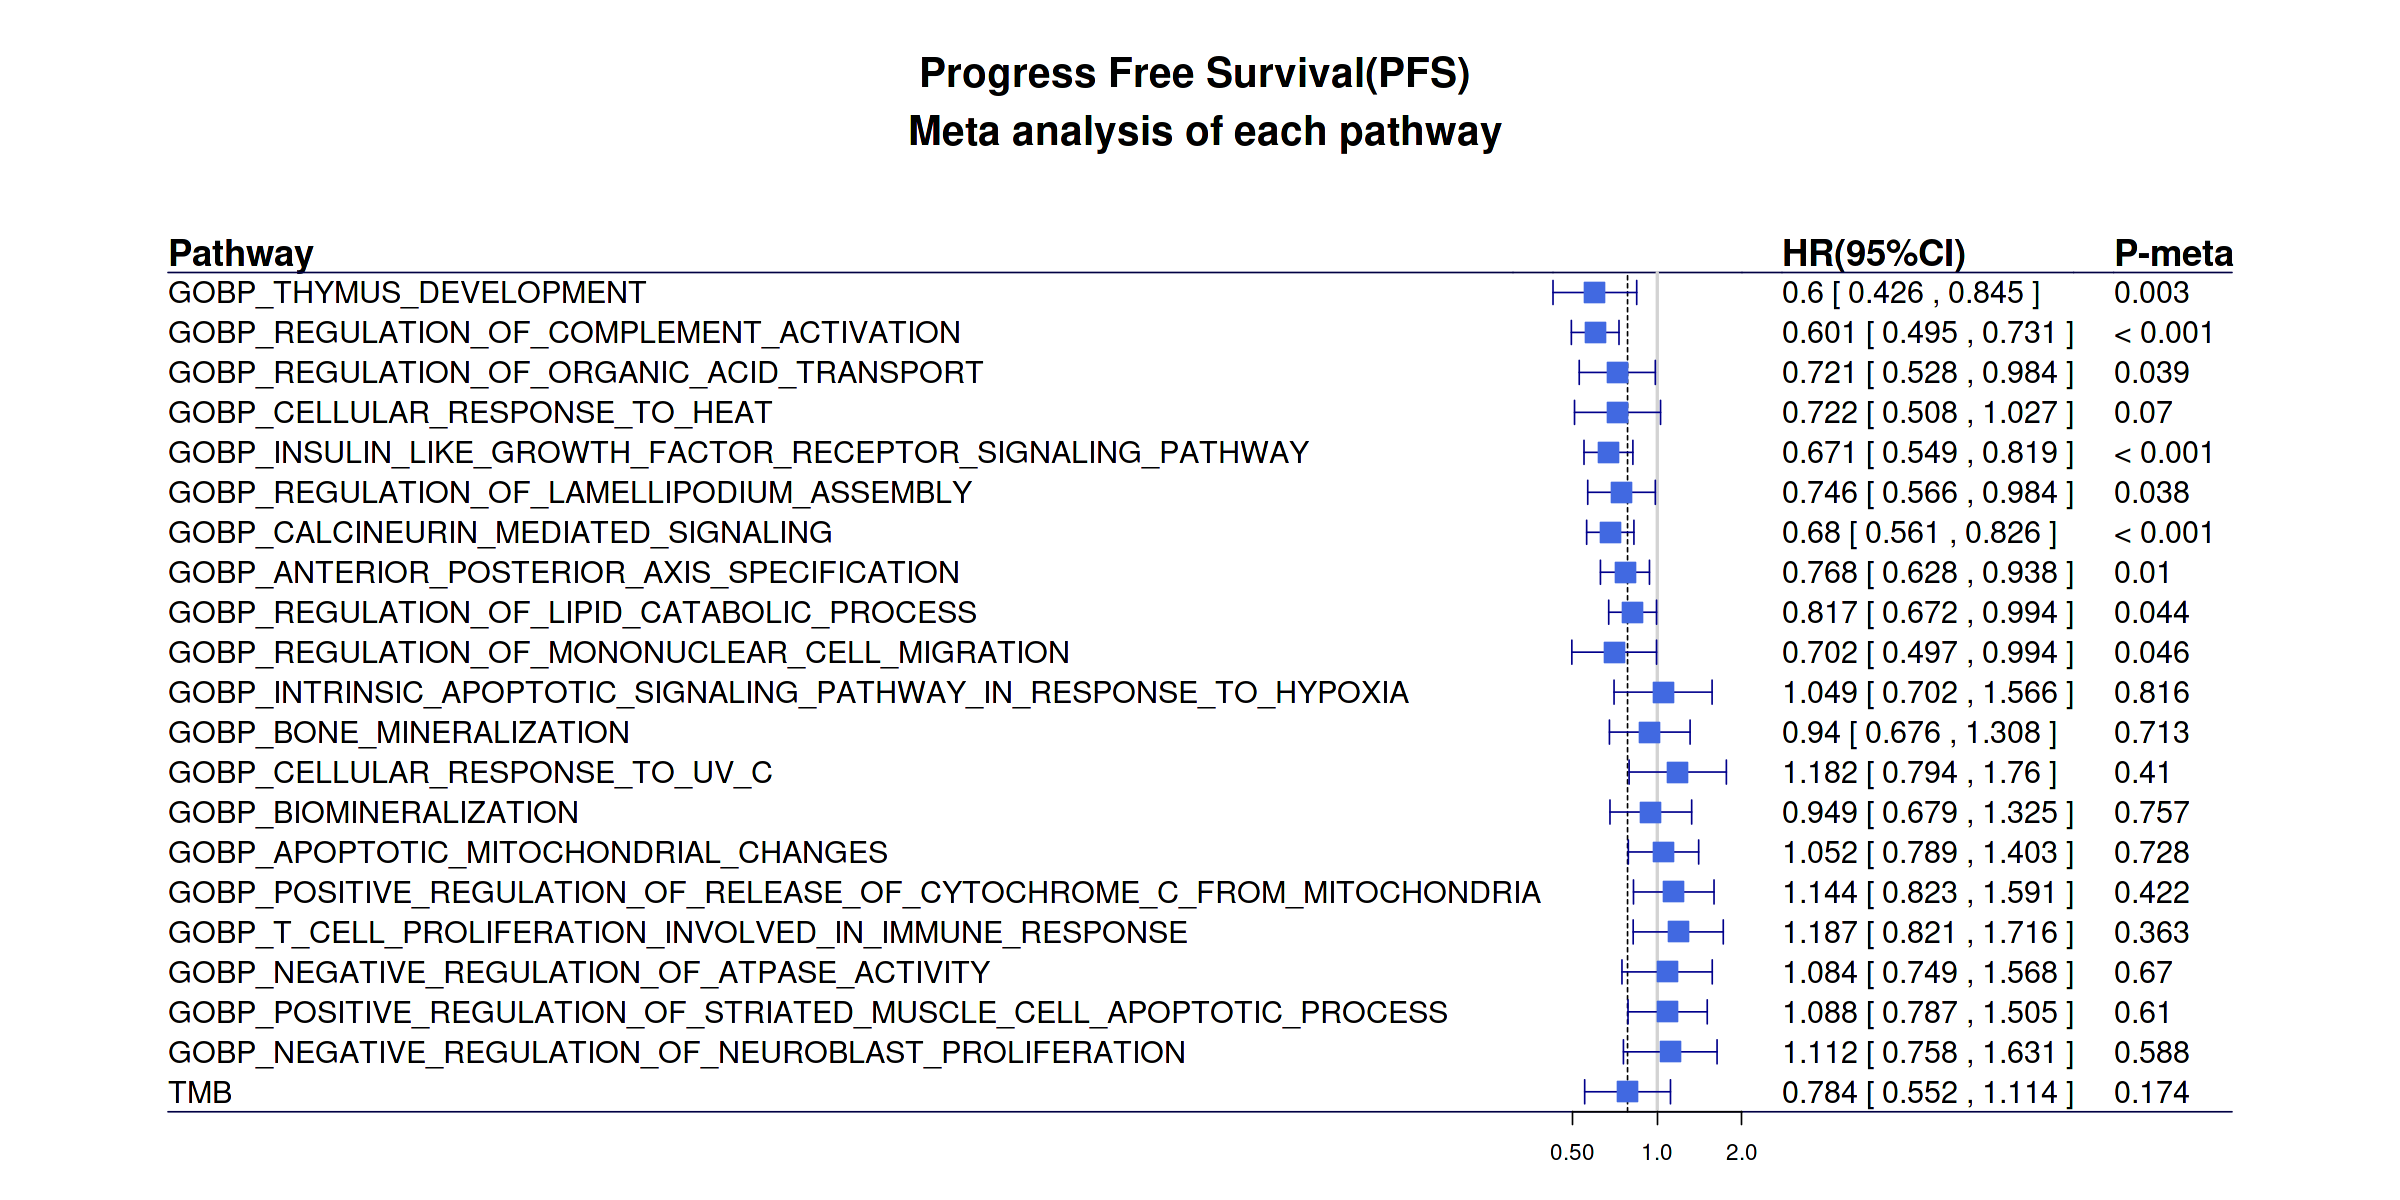

In [69]:
maxup = max(total_cochrane_from_rmeta$upper[!is.infinite(total_cochrane_from_rmeta$upper)],na.rm = T)
minlow = min(total_cochrane_from_rmeta$lower[total_cochrane_from_rmeta$lower != 0],na.rm = T)

    
options(repr.plot.height = 10, repr.plot.width = 20)

tmp_list = list()
tmp_list[["2"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(total_cochrane_from_rmeta) + 1)]] = gpar(col = "#000044")

p = total_cochrane_from_rmeta %>% 
       forestplot(labeltext = total_tabletext, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(4,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
                     grid = structure(c(TMB_PFS_cochrane_from_rmeta[,1]), 
                            gp = gpar(lwd = 1,lty = 2, col = "black")),
                     boxsize = 0.5,
                     graph.pos = 2,
#                      zero = 1,
                     title = paste("Progress Free Survival(PFS)","\n","Meta analysis of each pathway"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                     is.summary = c(rep(TRUE, 1), rep(FALSE, nrow(total_cochrane_from_rmeta)-1)),
                     xlog = TRUE, 
                     hrzl_lines = tmp_list,
                     vertices = TRUE,
                     col = fpColors(box = "royalblue",
                                    line = "darkblue",
                                    summary = "royalblue")
                     )
p

In [75]:
pdf("Artical_Figure2/Figure 2/Complement_VS_TMB_PFS.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [70]:
total_cochrane_from_rmeta$pn = total_tabletext[,1]
total_cochrane_from_rmeta = total_cochrane_from_rmeta[2:22,]
total_cochrane_from_rmeta$pn = factor(total_cochrane_from_rmeta$pn,levels = rev(total_cochrane_from_rmeta$pn),labels = levels(tmp_matrix$gene))

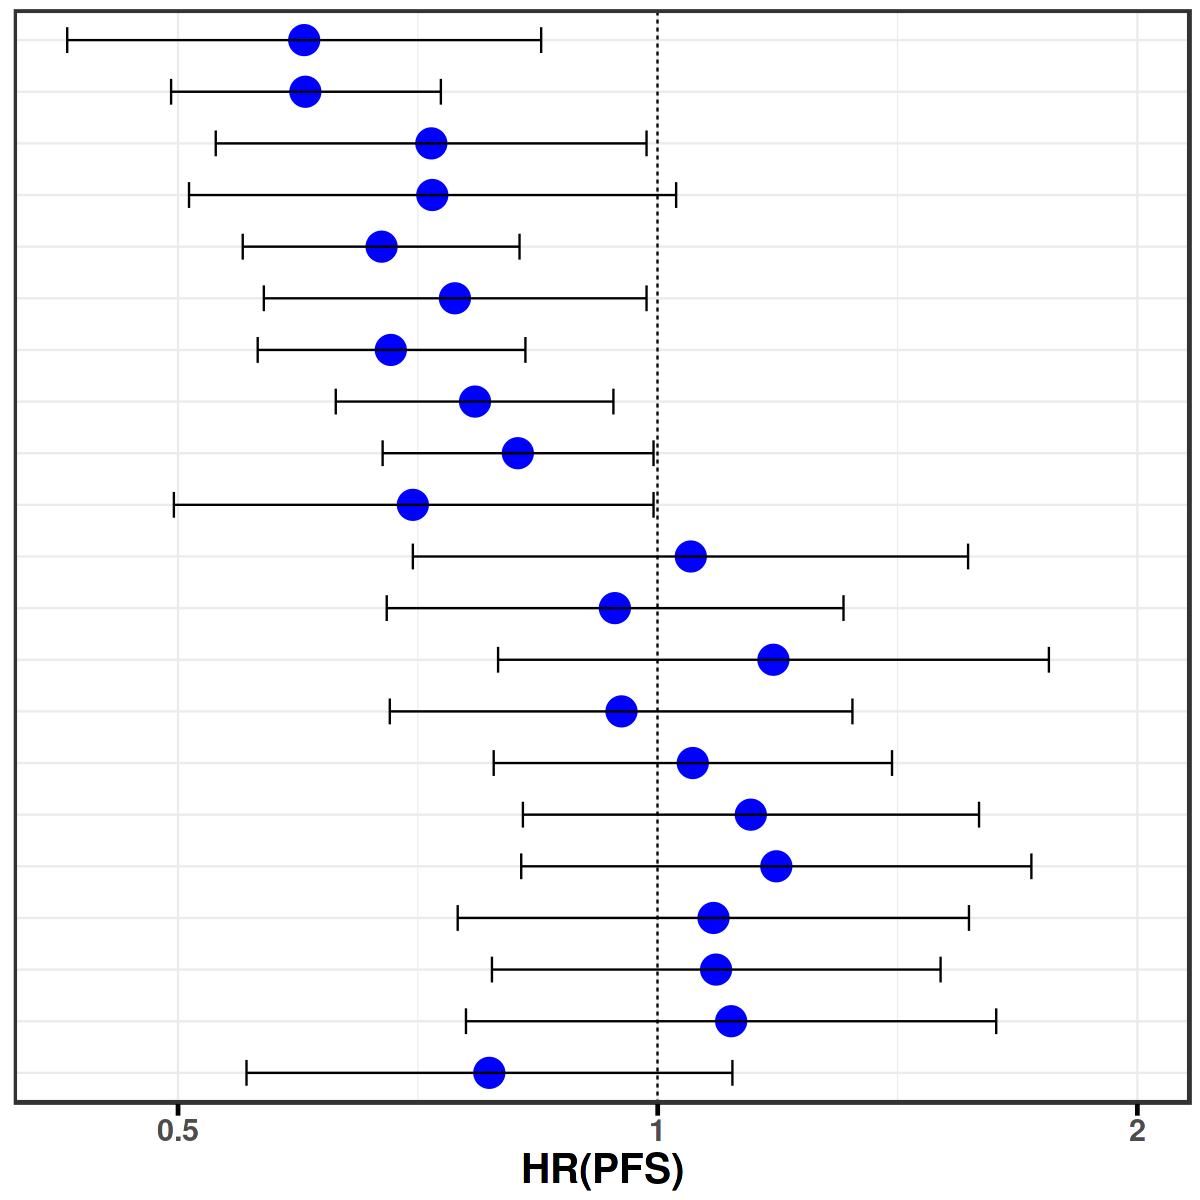

In [71]:
options(repr.plot.height = 10, repr.plot.width = 10)
p_PFS = ggplot(total_cochrane_from_rmeta)+
    geom_point(aes(x = log2(mean),y = pn),size = 8,color = "blue")+
    geom_vline(xintercept = 0,lty=2)+
    geom_errorbarh(aes(y = pn,xmax = log2(upper), xmin = log2(lower)), height = 0.5)+
    scale_x_continuous(breaks = c(-1,0,1),labels = c(0.5,1,2),
                       limits = c(min(log2(min(total_cochrane_from_rmeta$lower)),-1),max(log2(max(total_cochrane_from_rmeta$upper)),1))
                      )+

xlab("HR(PFS)")+
    theme_bw()+
    theme(axis.title.y = element_blank(),
          panel.border = element_rect(size = 1.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
#           axis.line.y = element_blank(),
#           axis.line = element_line(colour = "black",linetype = "solid",size = 1),
          axis.ticks.length.x = unit(2.5,"mm"),
          axis.ticks.x = element_line(colour = "black",linetype = "solid",size = 1 ),
          axis.text.x = element_text(angle = 0,hjust = 0.5,size=18,face = "bold"),
          axis.title.x = element_text(face="bold",size = 24),
         )

p_PFS

In [72]:
total_tabletext = as.data.frame(total_tabletext)[2:22,]
total_tabletext$V2 = factor(total_tabletext$V2,levels = rev(total_tabletext$V2))

In [73]:
PFS_total_tabletext = total_tabletext

In [74]:
p_ost = ggplot(total_tabletext)+
    geom_text(aes(x = "HR(95%CI,PFS)",y = V2,label = V2),fontface="bold")+
    geom_text(aes(x = "P-meta",y = V2,label = V3),fontface="bold")+
    # xlim(0,3)+
    theme_bw()+theme(panel.border = element_rect(size = 1.5),axis.text.y = element_blank(),axis.title = element_blank(),axis.text.x = element_text(size = 22,face="bold"),axis.ticks.y = element_blank())

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


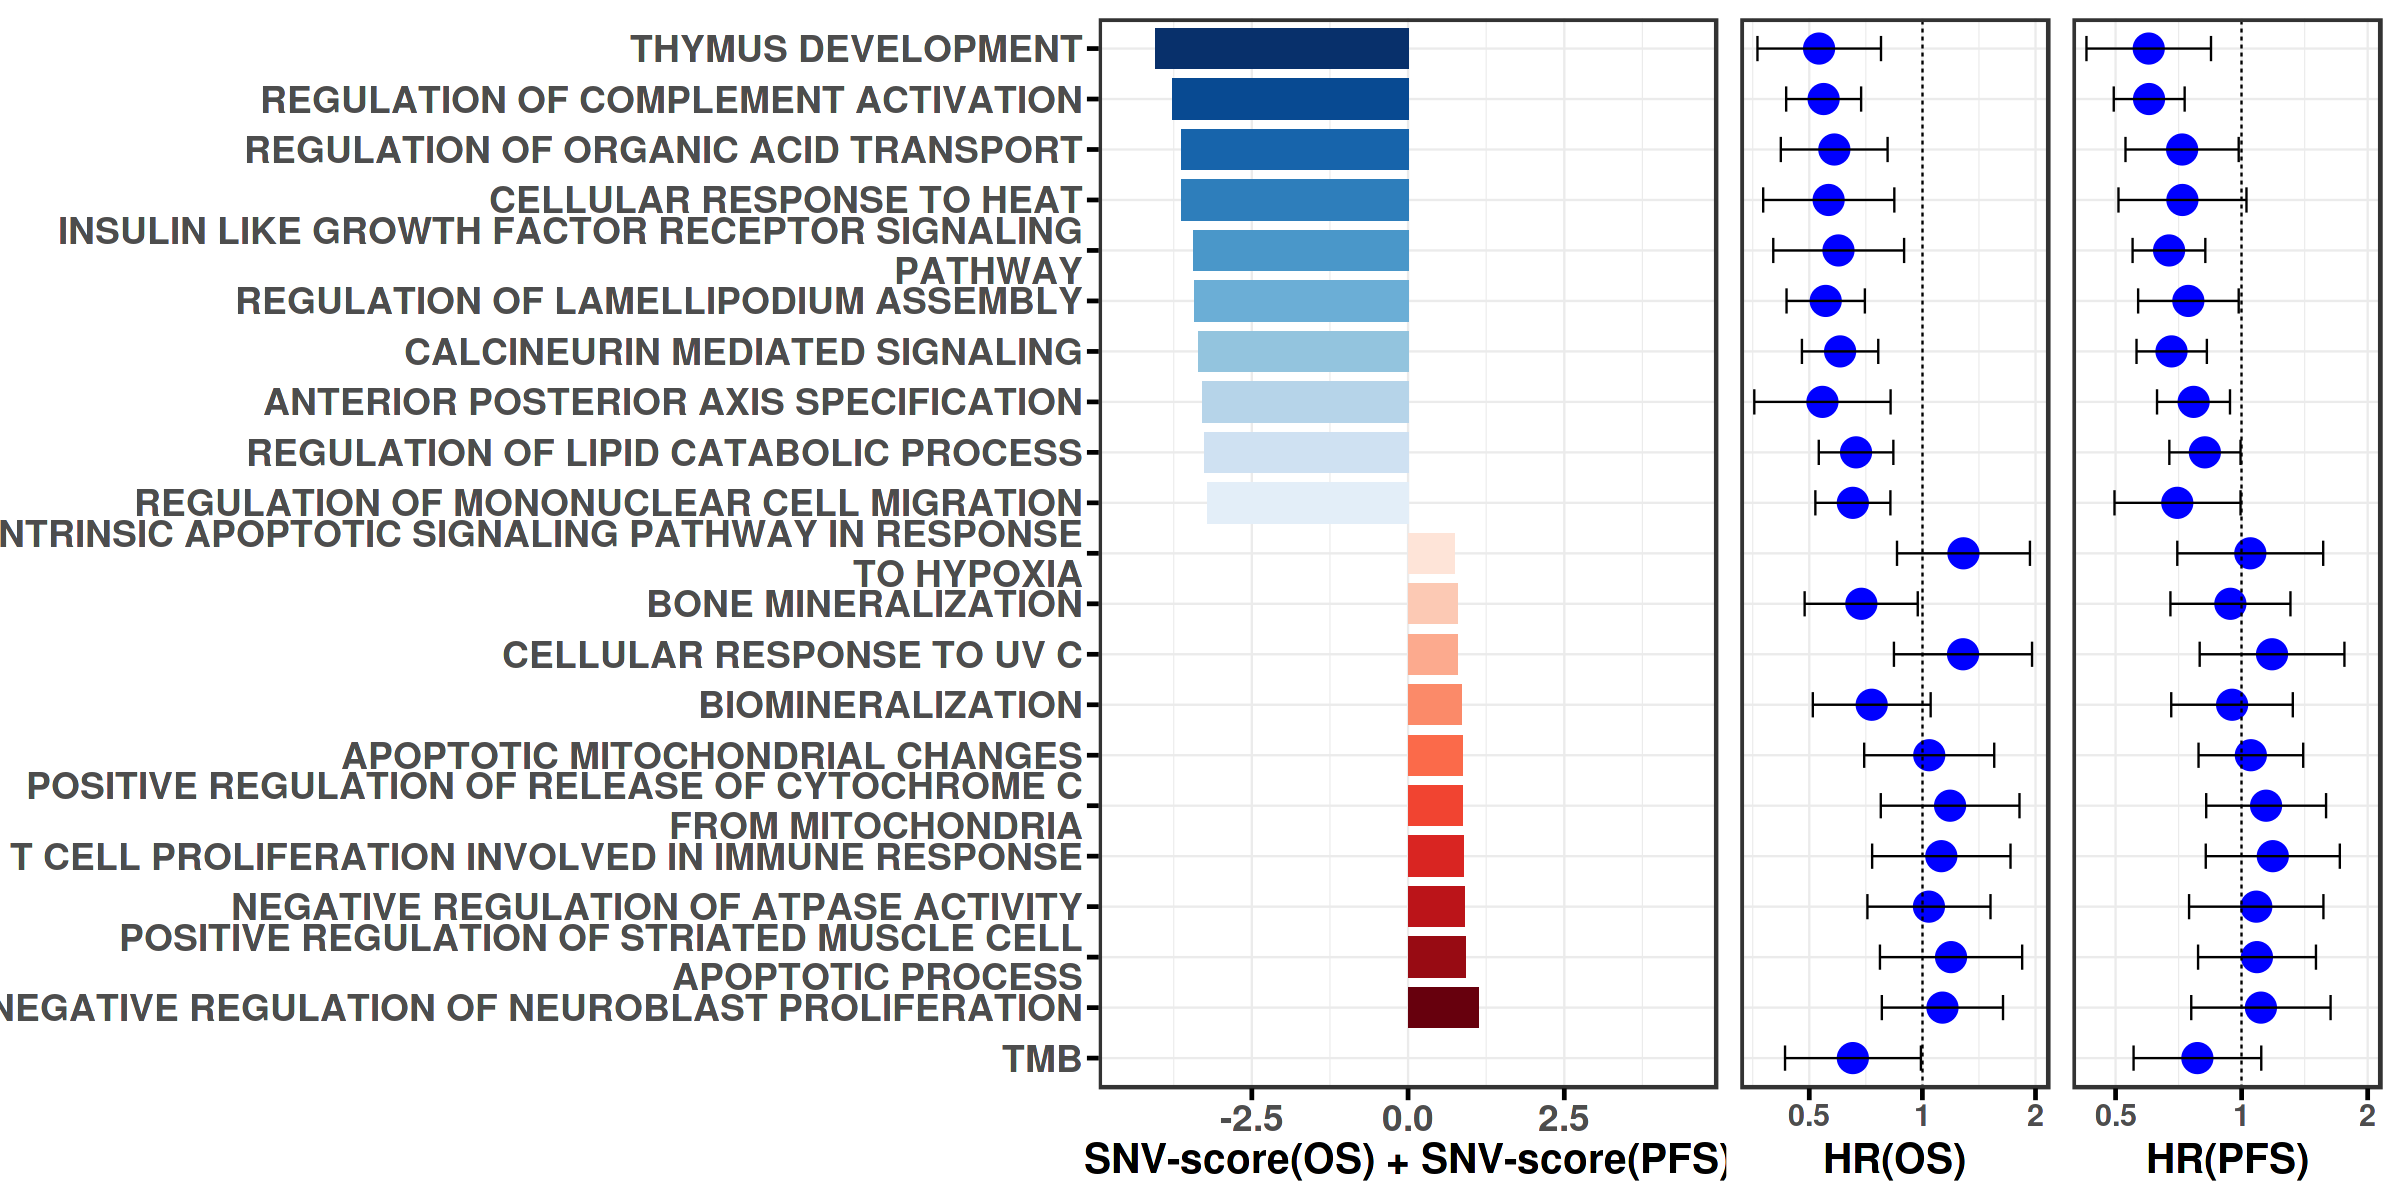

In [75]:
options(repr.plot.height = 10, repr.plot.width = 20)
p_bar + p_OS + p_PFS + plot_layout(ncol = 3,width = c(2,1,1),guides = 'collect')

In [76]:
total_cochrane_from_rmeta = vector()
total_tabletext = vector()

target_pathway = c(rownames(OS_RS_matrix3)[1:50],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-99):nrow(OS_RS_matrix3)])

for( p in rev(target_pathway)){
    
    pathway = p
    
    cohort = vector()
    wildtype = vector()
    mutation = vector()
    HR_mean = vector()
    HR_lower = vector()
    HR_upper = vector()
    HR_text = vector()
    logtest = vector()
    waldtest = vector()
    for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = pathway,dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) >=3 & length(tmp_cohort$wt) >=3 & ("PFS_TIME" %in% colnames(All[[i]]))){
#         cohort = c(cohort,dataset_name[i])
#         wildtype = c(wildtype,length(tmp_cohort$wt))
#         mutation = c(mutation,length(tmp_cohort$mut))

        tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
            mutation = c(mutation,table(tmp_data$groups)["Mutation"])
            
            # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
            data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
            p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
            coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
            HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
            HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
            HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
            HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
            logtest = c(logtest,round(summary(coxres)$logtest[3],3))
            waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
            
        }
  
      }
    }

    ord = order(HR_mean)
    tabletext = cbind(
                      c(NA,"Cohort",cohort[ord],"Common","Random"),
                      c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                      c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                      c(NA,"HR(95%CI)",HR_text[ord],NA,NA),
    #                   c(NA,"P value(Log rank)",logtest[ord],NA),
                      c(NA,"P value(wald text)",waldtest[ord],NA,NA))
    cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

    tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
    rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
    tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
    m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
    k = summary(m)

    if(is.na(k$pval.Q)){
        total_tabletext = rbind(total_tabletext,c(gene_name,rep("--",5),nrow(tmp)))
    }else{
            chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
            tabletext[nrow(tabletext)-1,4:5] = c(chtext,round(k$common$p,3))
            cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
            rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
            tabletext[nrow(tabletext),4:5] = c(rhtext,round(k$random$p,3))
            cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

            if(k$pval.Q < 0.1){
                total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext),])
                total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext),],nrow(tmp)))
            }else{
                total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext)-1,])
                total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext)-1,],nrow(tmp)))
            }  
    }     
    
    
}

Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, control, weights = weights, :
“Loglik converged before variable  1 ; coefficient may be infinite. ”
Warning message in coxph.fit(X, Y, istrat, offset, init, c

In [77]:
total_tabletext = cbind(total_tabletext,rev(OS_RS_matrix3[target_pathway,"Overview"]))
colnames(total_tabletext) = c("Pathway","Meta model(PFS)","Mutation","Wildtype","HR[95%CI,PFS]","P-meta(PFS)","Num of datasets(PFS)","SNVscore")
PFS_total_tabletext = total_tabletext

In [79]:
write.table(cbind(OS_total_tabletext[,c(1,2,5,6,7)],PFS_total_tabletext[,c(2,5,6,7,8)]),file = "./Artical_Figure2/Figure 2/Pathway_PanCancer.txt",sep = "\t",quote = F,row.names = F,col.names = T)

### Pathway mutation vs TMB RECIST+RESPONSE

In [76]:
total_cochrane_from_rmeta = vector()
total_tabletext = vector()

target_pathway = c(rownames(OS_RS_matrix3)[1:10],rownames(OS_RS_matrix3)[(nrow(OS_RS_matrix3)-9):nrow(OS_RS_matrix3)])

for( p in rev(target_pathway)){
    
    pathway = p
    
    cohort = vector()
    NCB = vector()
    DCB = vector()
    OR_mean = vector()
    OR_lower = vector()
    OR_upper = vector()
    OR_text = vector()
    midp.exact = vector()
    chi.square = vector()
    fisher.exact = vector()
    for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = pathway,dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("RESPONSE" %in% colnames(All[[i]]))){

        


        tmp_data = All[[i]][c("RESPONSE")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            contingency = table(tmp_data$groups,tmp_data$RESPONSE)
            
            tmp_chi = chisq.test(contingency,correct = F)

            if(sum(tmp_chi$expected < 5) > 0){

                    rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
            }else{

                    rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
            }


              NCB = c(NCB,paste(rr_RESPONSE$data["Mutation","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
              DCB = c(DCB,paste(rr_RESPONSE$data["Mutation","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

              OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
              OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
              OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
              OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
              midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
              chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
              fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3))

            
            
            
        }
          
        
        


      }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]]))){

        


        tmp_data = All[[i]][c("RECIST")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

        tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
        if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
            
            cohort = c(cohort,dataset_name[i])
            
            contingency = table(tmp_data$groups,tmp_data$RECIST)
            tmp_chi = chisq.test(contingency,correct = F)

            if(sum(tmp_chi$expected < 5) > 0){

                    rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
            }else{

                    rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
            }



              NCB = c(NCB,paste(rr_RECIST$data["Mutation","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
              DCB = c(DCB,paste(rr_RECIST$data["Mutation","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

              OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
              OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
              OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
              OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
              midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
              chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
              fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
            
        }
        

      }
    }

    ord = order(OR_mean)
    tabletext = cbind(
        c(NA,"Cohort",cohort[ord],"Common","Random"),
        c(NA,"NCB\n(Mutation/total)",NCB[ord],NA,NA),
        c(NA,"DCB\n(Mutation/total)",DCB[ord],NA,NA),
        c(NA,"OR(95%CI)",OR_text[ord],NA,NA),
        c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
        c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
        c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA))
    cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

    tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
    rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
    tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
    m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
    k = summary(m)

    chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
    tabletext[nrow(tabletext)-1,4:5] = c(chtext,round(k$common$p,3))
    cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
    rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
    tabletext[nrow(tabletext),4:5] = c(rhtext,round(k$random$p,3))
    cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

    if(k$pval.Q < 0.1){
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext),])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext),]))
    }else{
        total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,cochrane_from_rmeta[nrow(tabletext)-1,])
        total_tabletext = rbind(total_tabletext,c(pathway,tabletext[nrow(tabletext)-1,]))
    }   
    
    
}

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximatio

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

In [77]:
total_tabletext = total_tabletext[,c(1,5,6)]
total_tabletext = rbind(total_tabletext,TMB_DR_tabletext)
total_tabletext[,3][as.numeric(total_tabletext[,3]) < 0.001] = "< 0.001"

total_cochrane_from_rmeta = rbind(total_cochrane_from_rmeta,TMB_DR_cochrane_from_rmeta)
total_tabletext = rbind(c("Pathway","HR(95%CI)","P-meta"),total_tabletext)
total_cochrane_from_rmeta = rbind(c(NA,NA,NA),total_cochrane_from_rmeta)

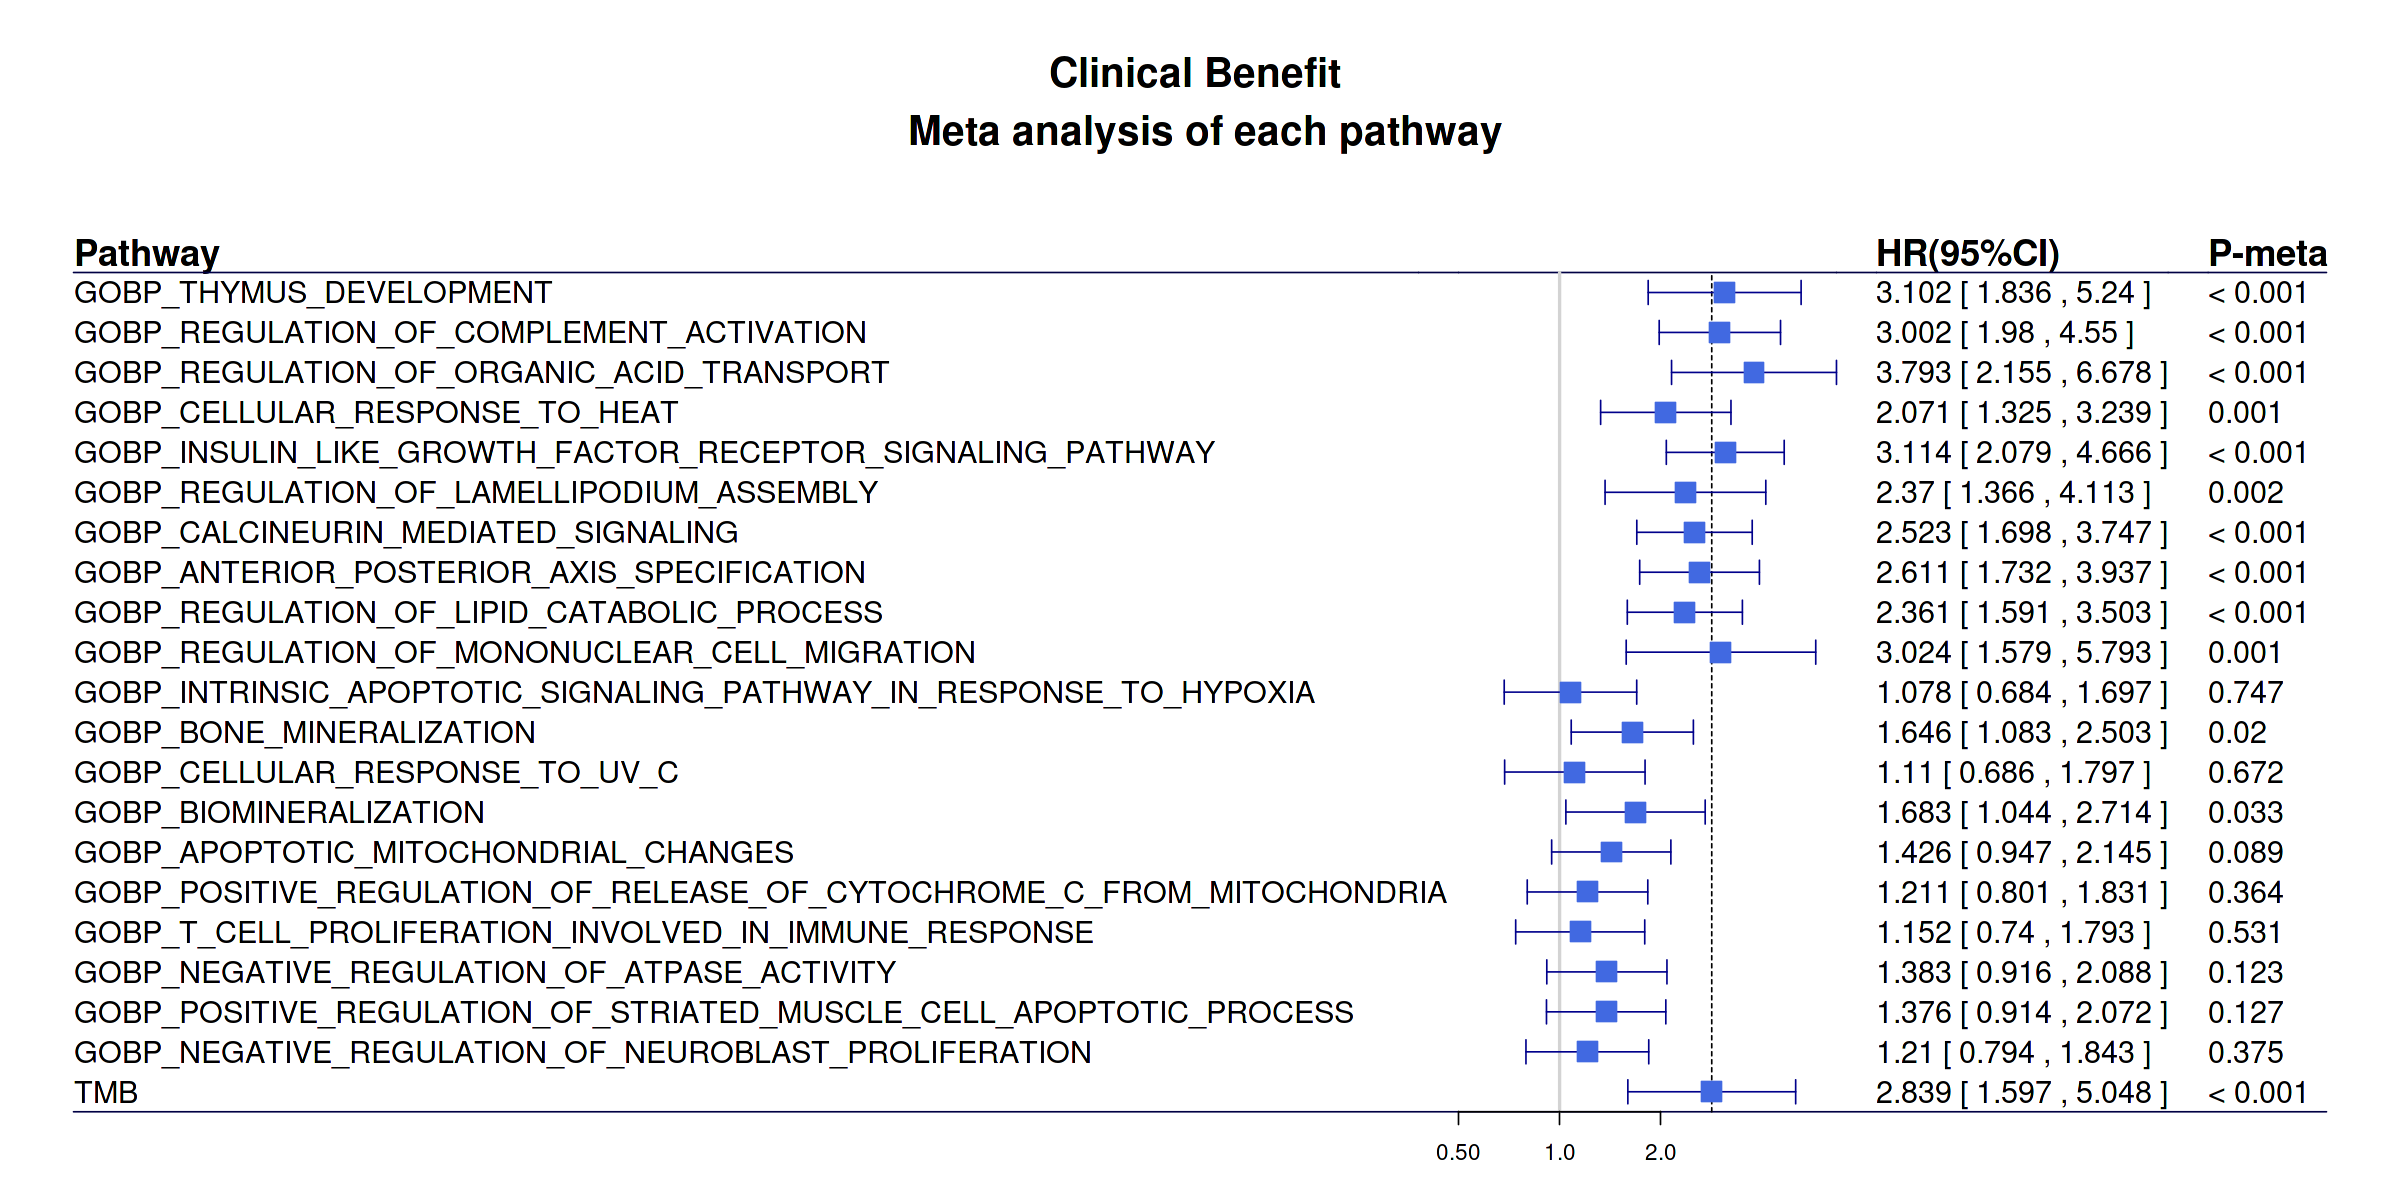

In [78]:
maxup = max(total_cochrane_from_rmeta$upper[!is.infinite(total_cochrane_from_rmeta$upper)],na.rm = T)
minlow = min(total_cochrane_from_rmeta$lower[total_cochrane_from_rmeta$lower != 0],na.rm = T)

    
options(repr.plot.height = 10, repr.plot.width = 20)

tmp_list = list()
tmp_list[["2"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(total_cochrane_from_rmeta) + 1)]] = gpar(col = "#000044")

p = total_cochrane_from_rmeta %>% 
       forestplot(labeltext = total_tabletext, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                      lty.ci = 1,
                      ci.vertices.height = 0.3,
                     align="l",
                     graphwidth = unit(8,"cm"),
                     lwd.zero = gpar(lwd=2,lty=2),
                     grid = structure(c(TMB_DR_cochrane_from_rmeta[,1]), 
                            gp = gpar(lwd = 1,lty = 2, col = "black")),
                     boxsize = 0.5,
                     graph.pos = 2,
#                      zero = 1,
                     title = paste("Clinical Benefit","\n","Meta analysis of each pathway"),
                     txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                     is.summary = c(rep(TRUE, 1), rep(FALSE, nrow(total_cochrane_from_rmeta)-1)),
                     xlog = TRUE, 
                     hrzl_lines = tmp_list,
                     vertices = TRUE,
                     col = fpColors(box = "royalblue",
                                    line = "darkblue",
                                    summary = "royalblue")
                     )
p

In [83]:
pdf("Artical_Figure2/Figure 2/Complement_VS_TMB_CB.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [79]:
total_cochrane_from_rmeta$pn = total_tabletext[,1]
total_cochrane_from_rmeta = total_cochrane_from_rmeta[2:22,]
total_cochrane_from_rmeta$pn = factor(total_cochrane_from_rmeta$pn,levels = rev(total_cochrane_from_rmeta$pn),labels = levels(tmp_matrix$gene))

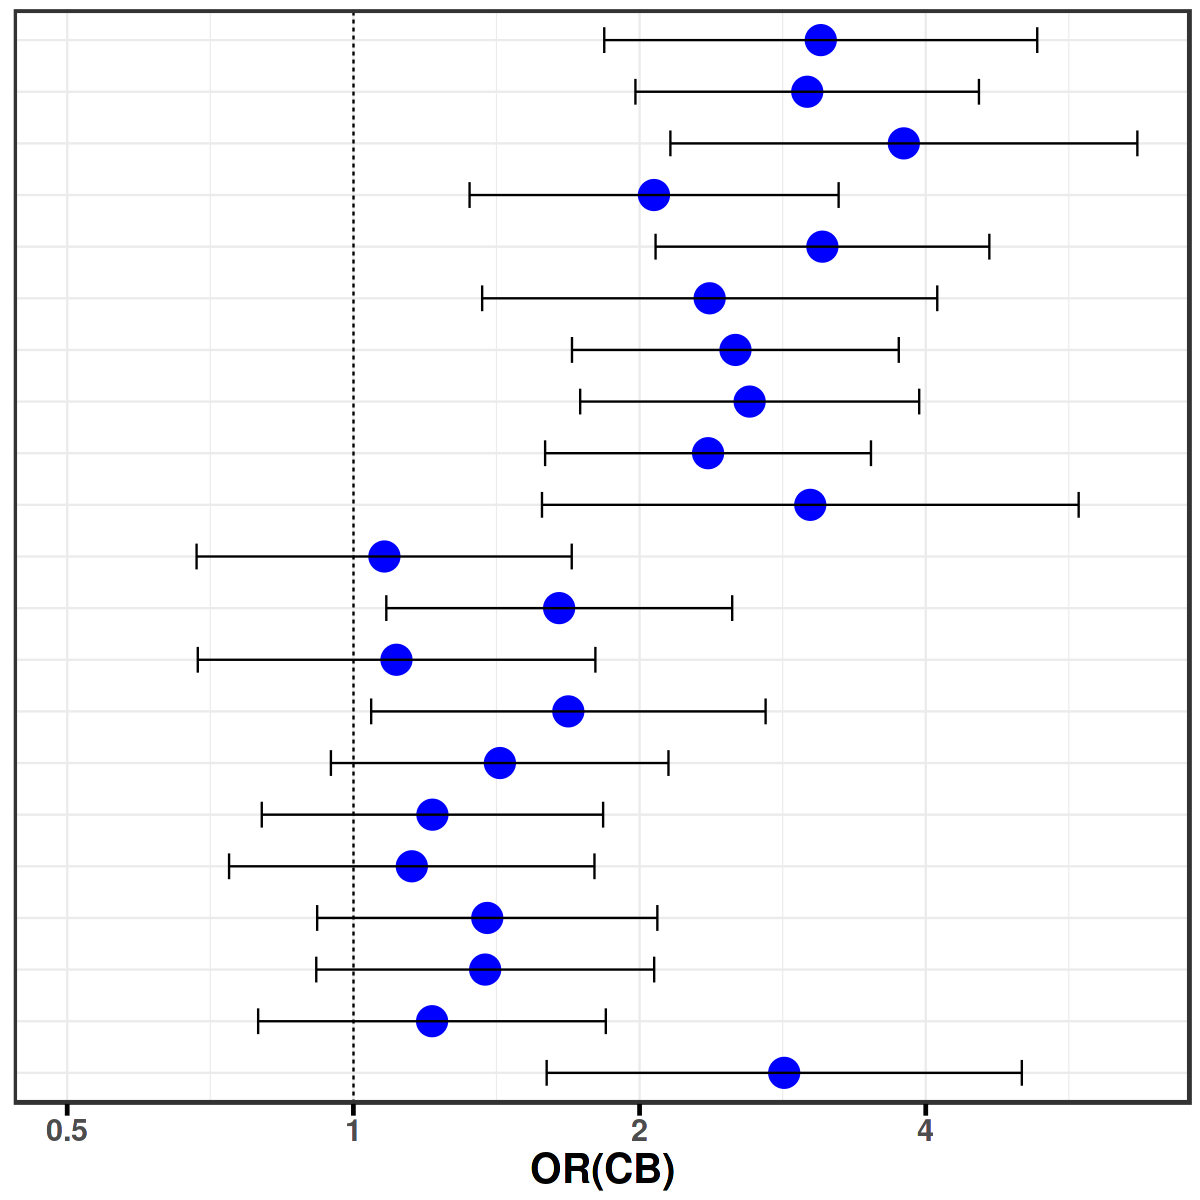

In [80]:
options(repr.plot.height = 10, repr.plot.width = 10)
p_OR = ggplot(total_cochrane_from_rmeta)+
    geom_point(aes(x = log2(mean),y = pn),size = 8,color = "blue")+
    geom_vline(xintercept = 0,lty=2)+
    
    geom_errorbarh(aes(y = pn,xmax = log2(upper), xmin = log2(lower)), height = 0.5)+
    scale_x_continuous(breaks = c(-1,0,1,2),labels = c(0.5,1,2,4),
                       limits = c(min(log2(min(total_cochrane_from_rmeta$lower)),-1),max(log2(max(total_cochrane_from_rmeta$upper)),2))
                      )+

xlab("OR(CB)")+
    theme_bw()+
    theme(axis.title.y = element_blank(),
          panel.border = element_rect(size = 1.5),
          axis.text.y = element_blank(),
          axis.ticks.y = element_blank(),
#           axis.line.y = element_blank(),
#           axis.line = element_line(colour = "black",linetype = "solid",size = 1),
          axis.ticks.length.x = unit(2.5,"mm"),
          axis.ticks.x = element_line(colour = "black",linetype = "solid",size = 1 ),
          axis.text.x = element_text(angle = 0,hjust = 0.5,size=18,face = "bold"),
          axis.title.x = element_text(face="bold",size = 24),
         )

p_OR

In [81]:
total_tabletext = as.data.frame(total_tabletext)[2:22,]
total_tabletext$V2 = factor(total_tabletext$V2,levels = rev(total_tabletext$V2))

In [82]:
CB_total_tabletext = total_tabletext

In [83]:
p_ost = ggplot(total_tabletext)+
    geom_text(aes(x = "OR(95%CI,CB)",y = V2,label = V2),fontface="bold")+
    geom_text(aes(x = "P-meta",y = V2,label = V3),fontface="bold")+
    # xlim(0,3)+
    theme_bw()+theme(panel.border = element_rect(size = 1.5),axis.text.y = element_blank(),axis.title = element_blank(),axis.text.x = element_text(size = 22,face="bold"),axis.ticks.y = element_blank())

In [84]:
total_tabletext2 = cbind(OS_total_tabletext[,2:3],PFS_total_tabletext[,2:3],CB_total_tabletext[,2:3])

In [85]:
colnames(total_tabletext2) = c("OS","P-meta(OS)","PFS","P-meta(PFS)","CB","P-meta(CB)")

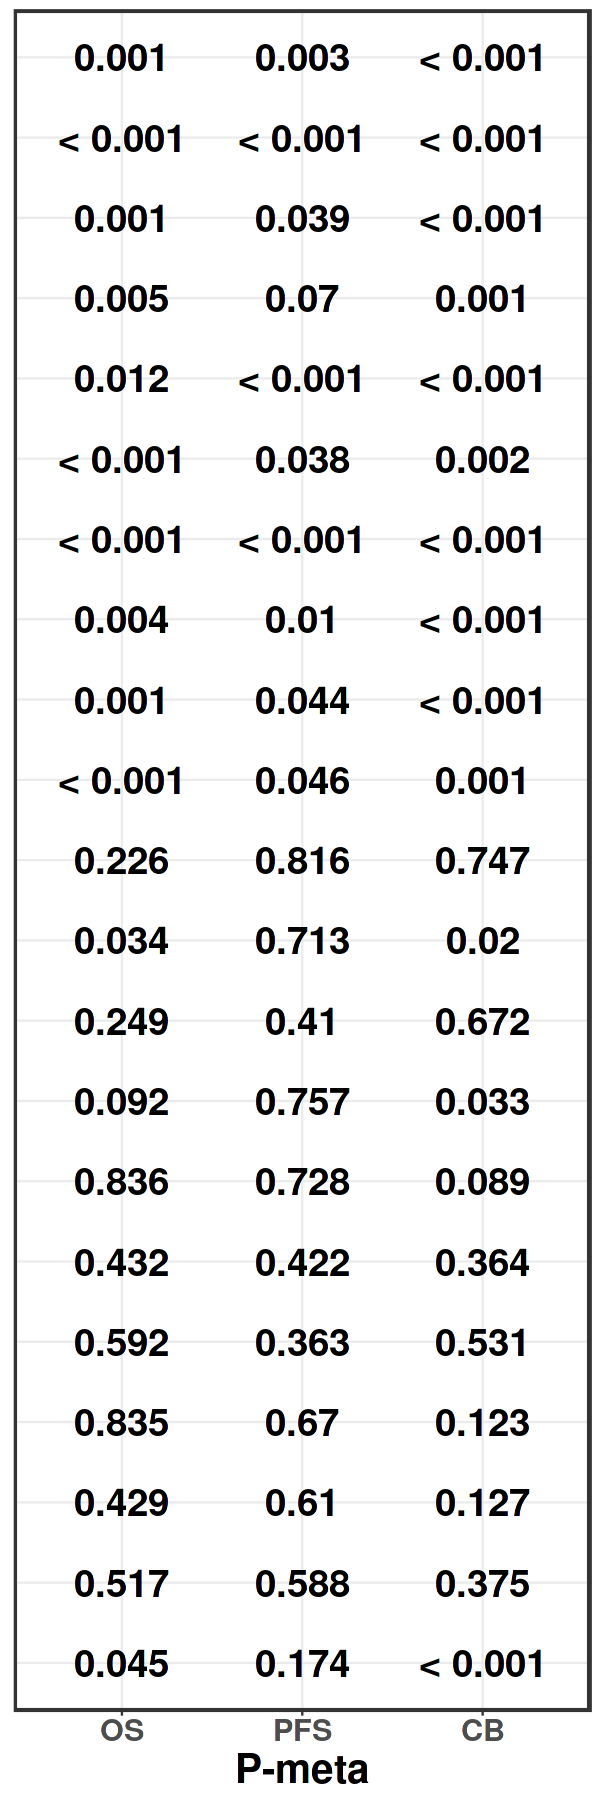

In [86]:
options(repr.plot.height = 15, repr.plot.width = 5)
p=ggplot(total_tabletext2)+
    geom_text(aes(x = "OS",y = OS,label = `P-meta(OS)`),fontface="bold",size=8)+
geom_text(aes(x = "PFS",y = OS,label = `P-meta(PFS)`),fontface="bold",size=8)+
geom_text(aes(x = "CB",y = OS,label = `P-meta(CB)`),fontface="bold",size=8)+
xlab("P-meta")+
scale_x_discrete(limits = c("OS", "PFS", "CB"))+
    theme_bw()+theme(
#                     axis.line.y = element_blank(),
#                     axis.line = element_line(colour = "black",linetype = "solid",size = 1),
                    panel.border = element_rect(size = 1.5),
                     axis.text.y = element_blank(),
                     axis.title.y = element_blank(),
                     axis.text.x = element_text(size = 18,face="bold"),
                     axis.title.x = element_text(size = 24,face="bold"),
                     axis.ticks.y = element_blank())
p

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


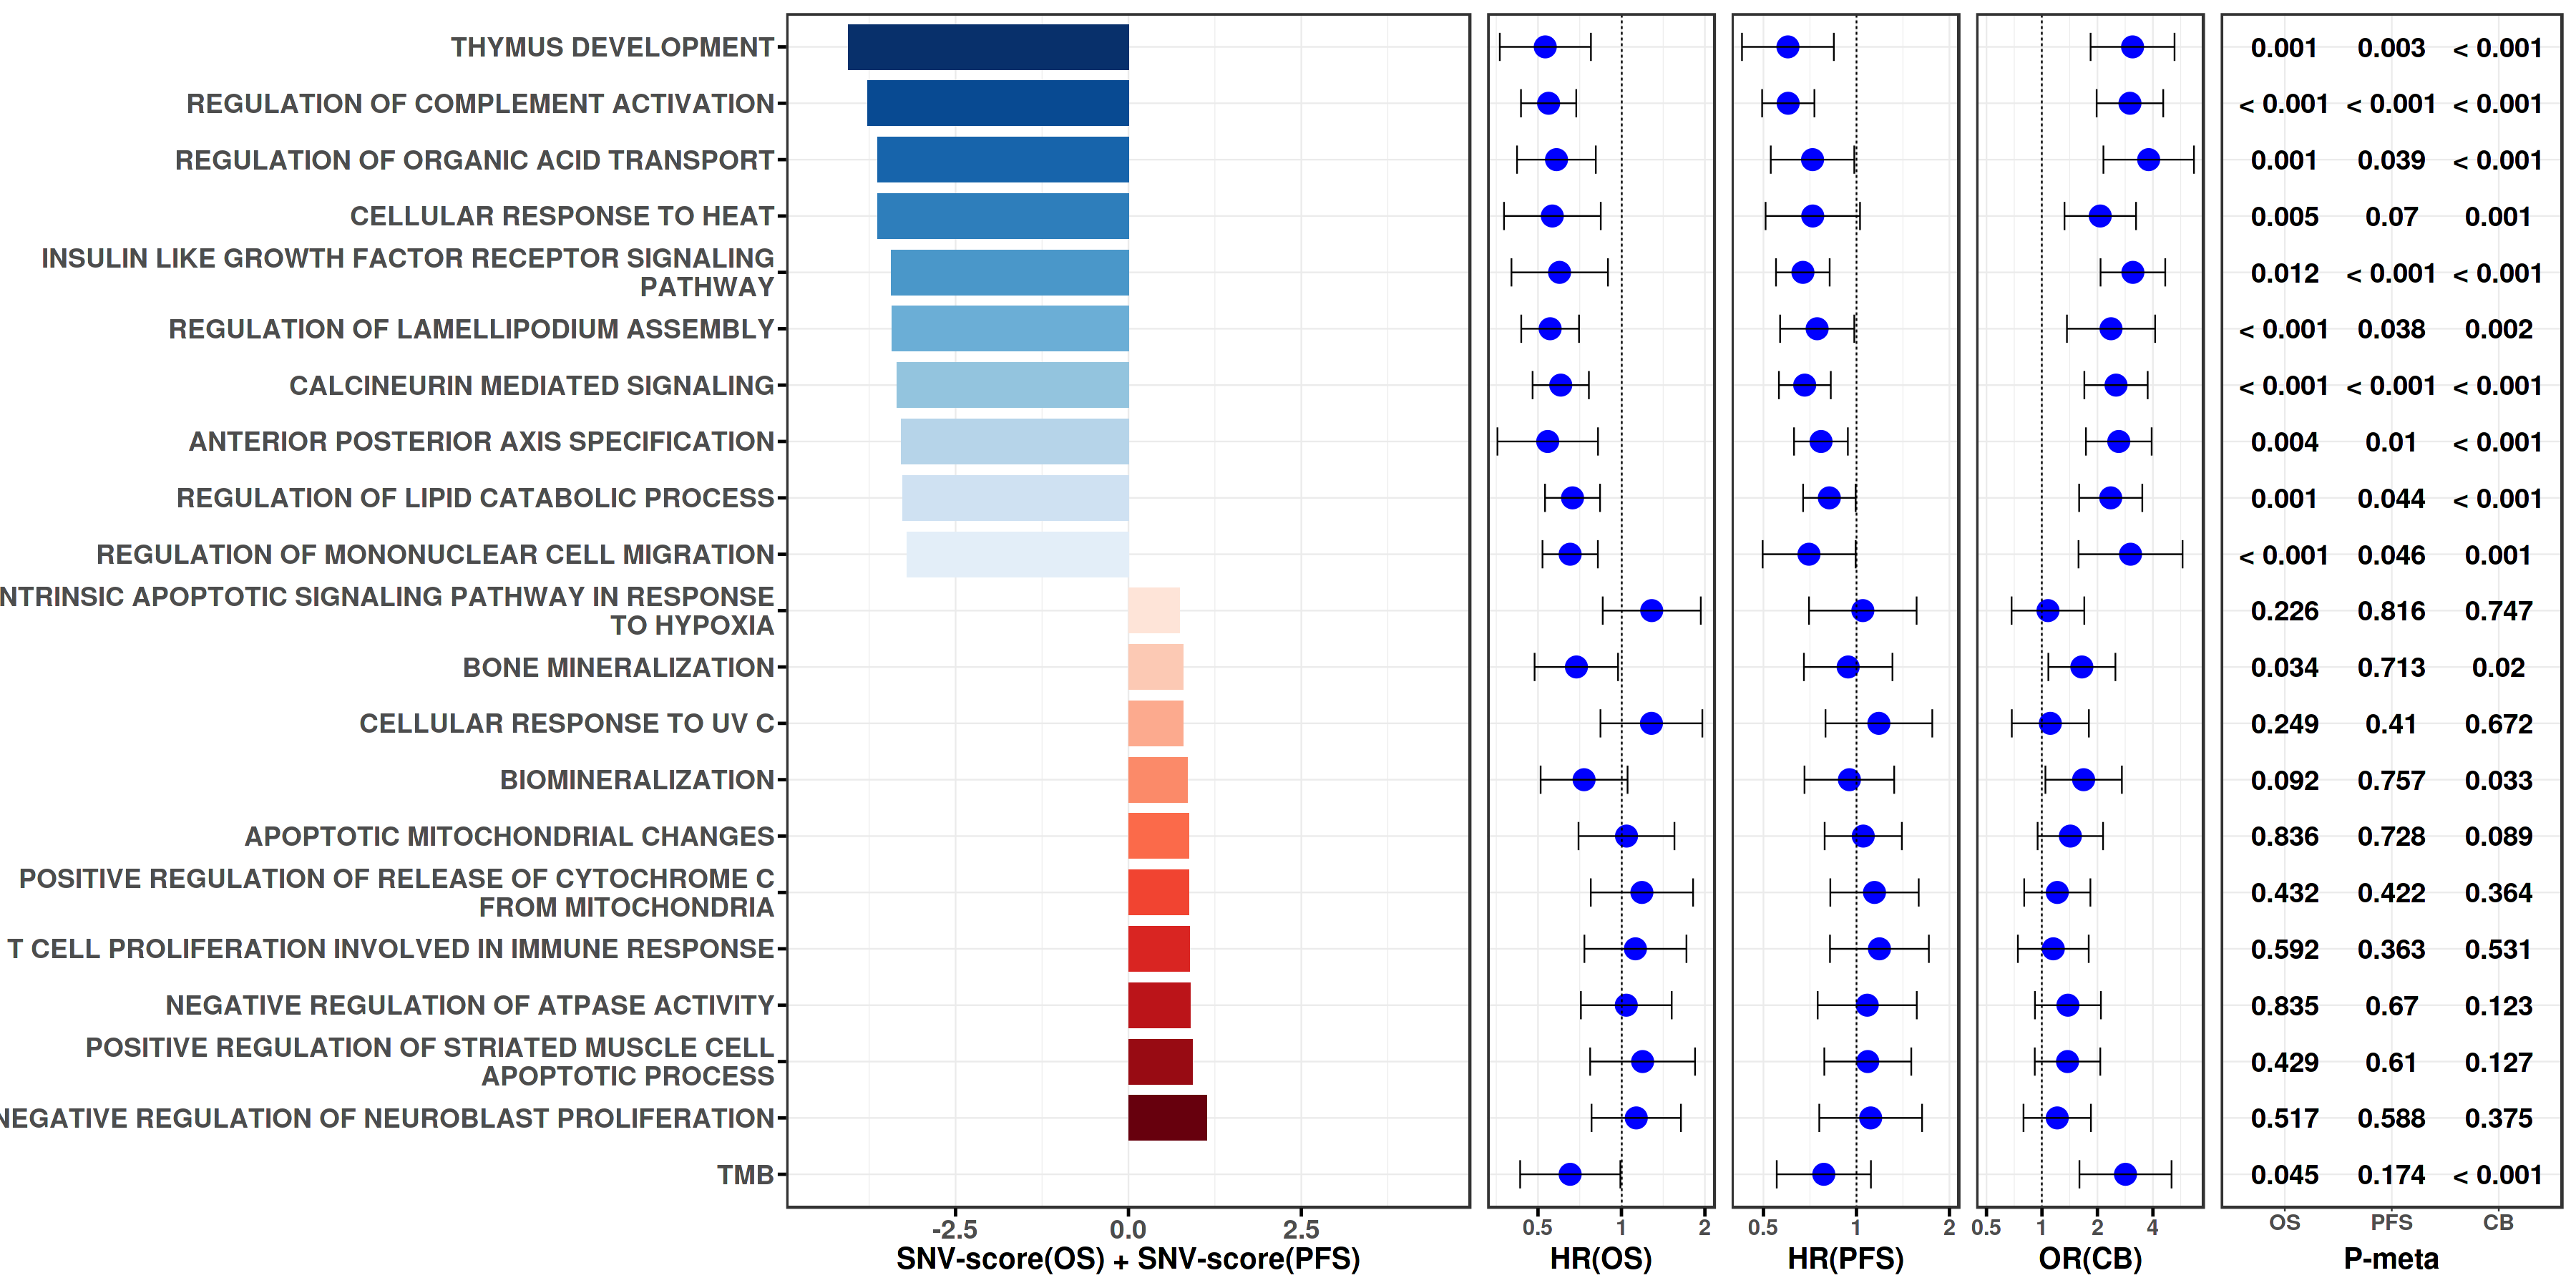

In [87]:
options(repr.plot.height = 15, repr.plot.width = 30)
p_bar + p_OS + p_PFS + p_OR+p + plot_layout(ncol = 5,width = c(3,1,1,1,1.5),guides = 'collect')

In [125]:
pdf("Artical_Figure2/Figure 2/Complement_VS_TMB_total.pdf",width = 30,height = 15)
p_bar + p_OS + p_PFS + p_OR+p + plot_layout(ncol = 5,width = c(3,1,1,1,1.5),guides = 'collect')
dev.off()

Warning message:
“Removed 1 rows containing missing values (`position_stack()`).”


png 
  2

### Detial result of meta analysis

##### OS

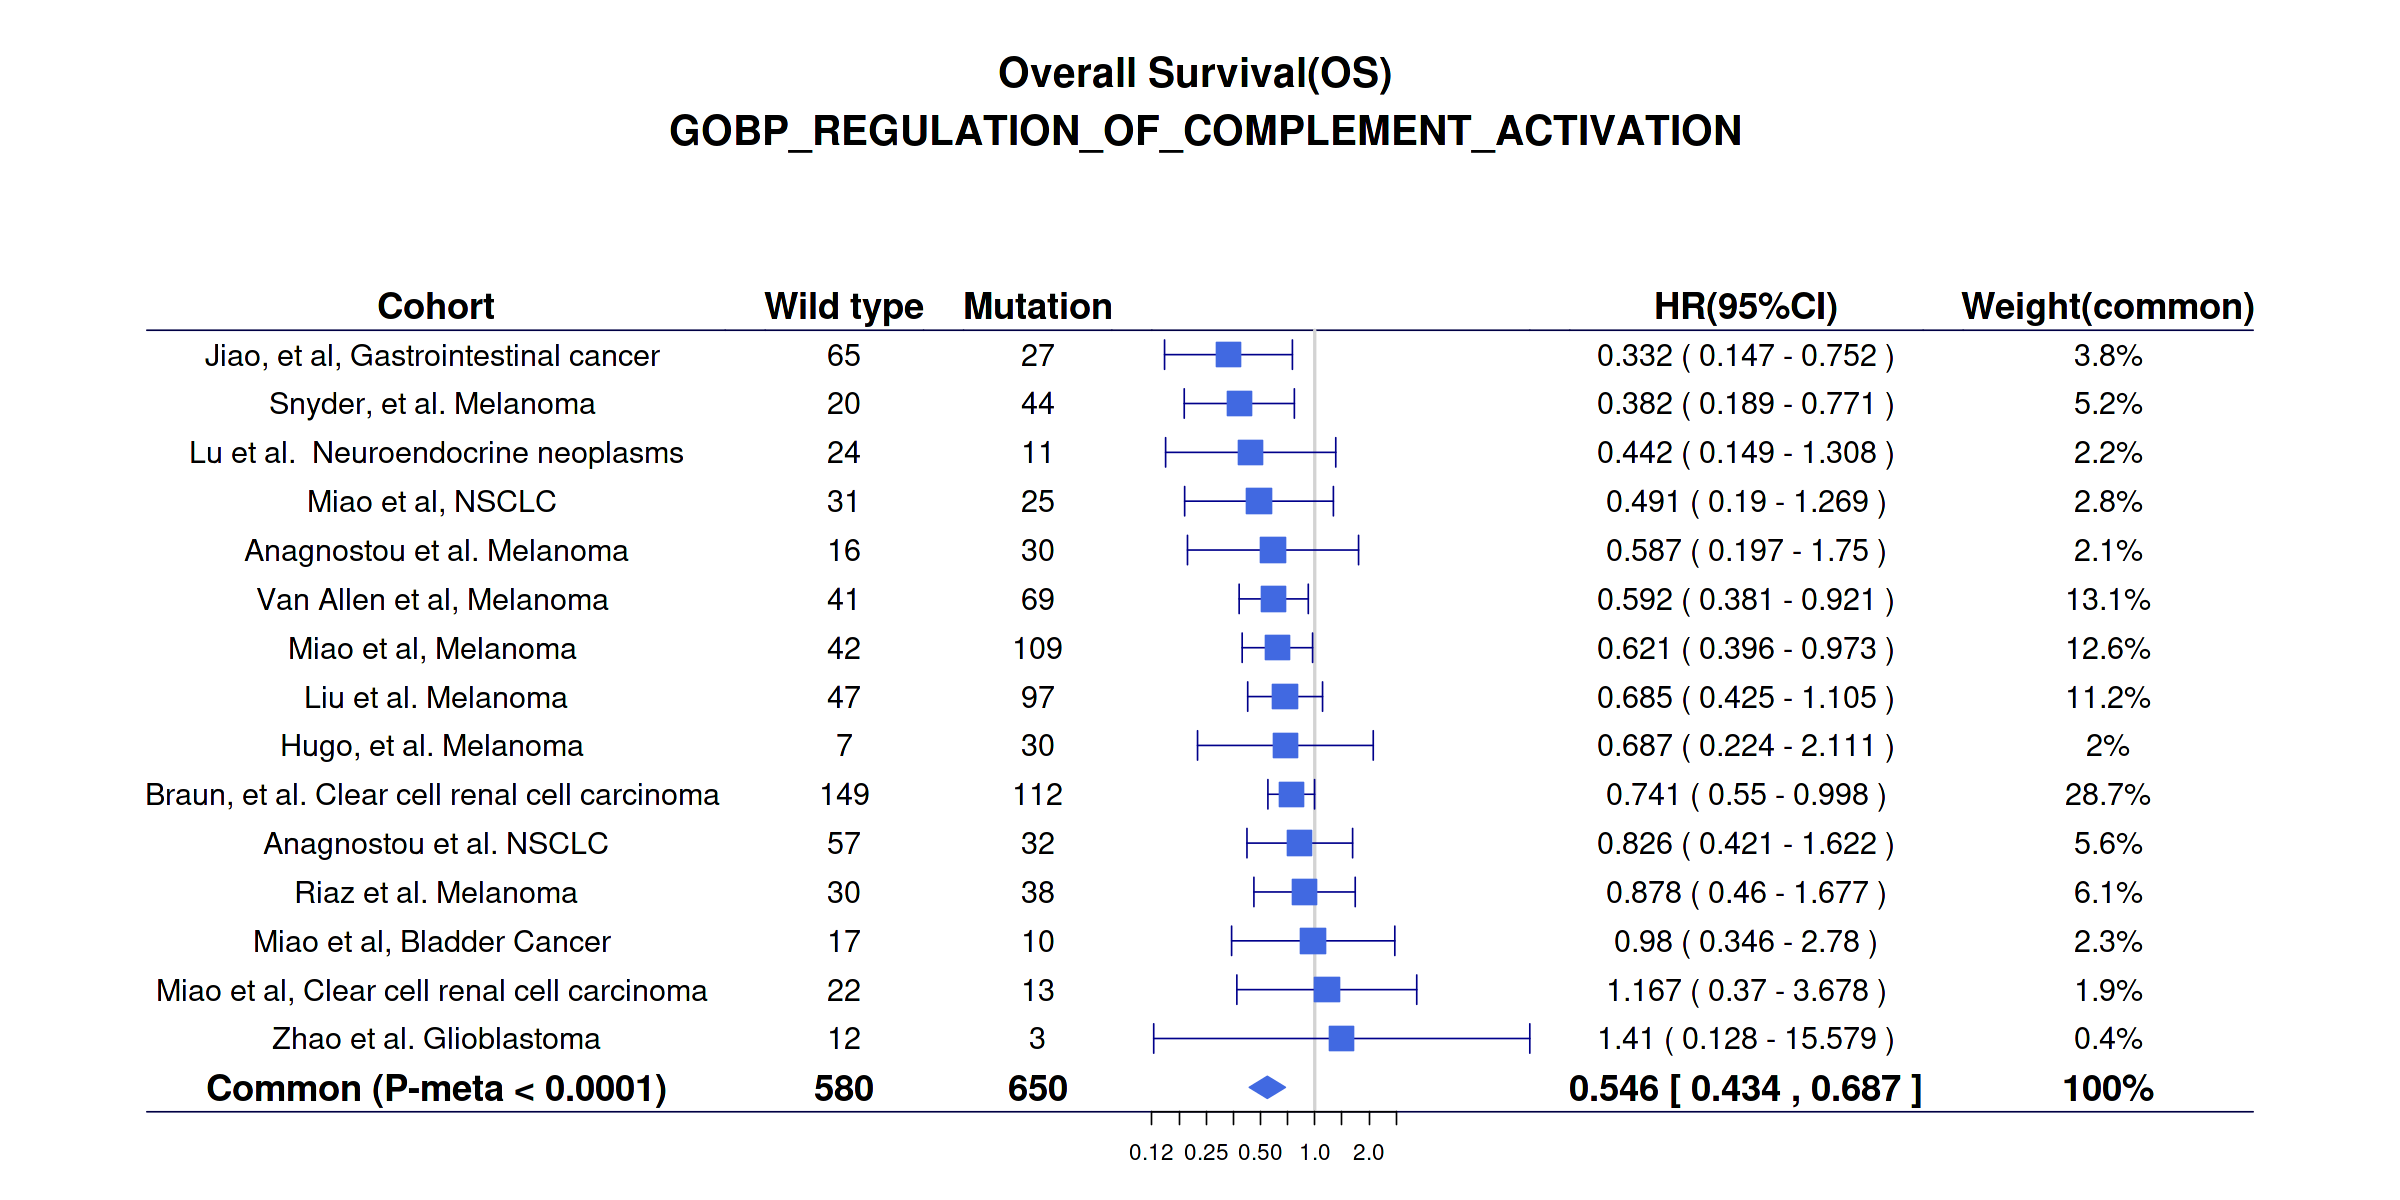

In [84]:
library(forestplot)
cohort = vector()
wildtype = vector()
mutation = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("OS_TIME" %in% colnames(All[[i]]))){
#     cohort = c(cohort,dataset_name[i])
#     wildtype = c(wildtype,length(tmp_cohort$wt))
#     mutation = c(mutation,length(tmp_cohort$mut))
    
    tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        
        wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
        mutation = c(mutation,table(tmp_data$groups)["Mutation"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
        
        
        
        
    }
    

    
    
    
  }
}

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                  c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")
options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),
                 lty.ci = 1,
                 ci.vertices.height = 0.3,
                 align="c",
                 graphwidth = unit(8,"cm"),
                 lwd.zero = gpar(lwd=2,lty=2),
                 txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 boxsize = 0.5,
                 graph.pos = 4,
                 title = paste("Overall Survival(OS)","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [85]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_OS.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [86]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_OS.heterogeneity.pdf",width = 20,height = 10)
forest(m)
dev.off()

png 
  2

##### PFS

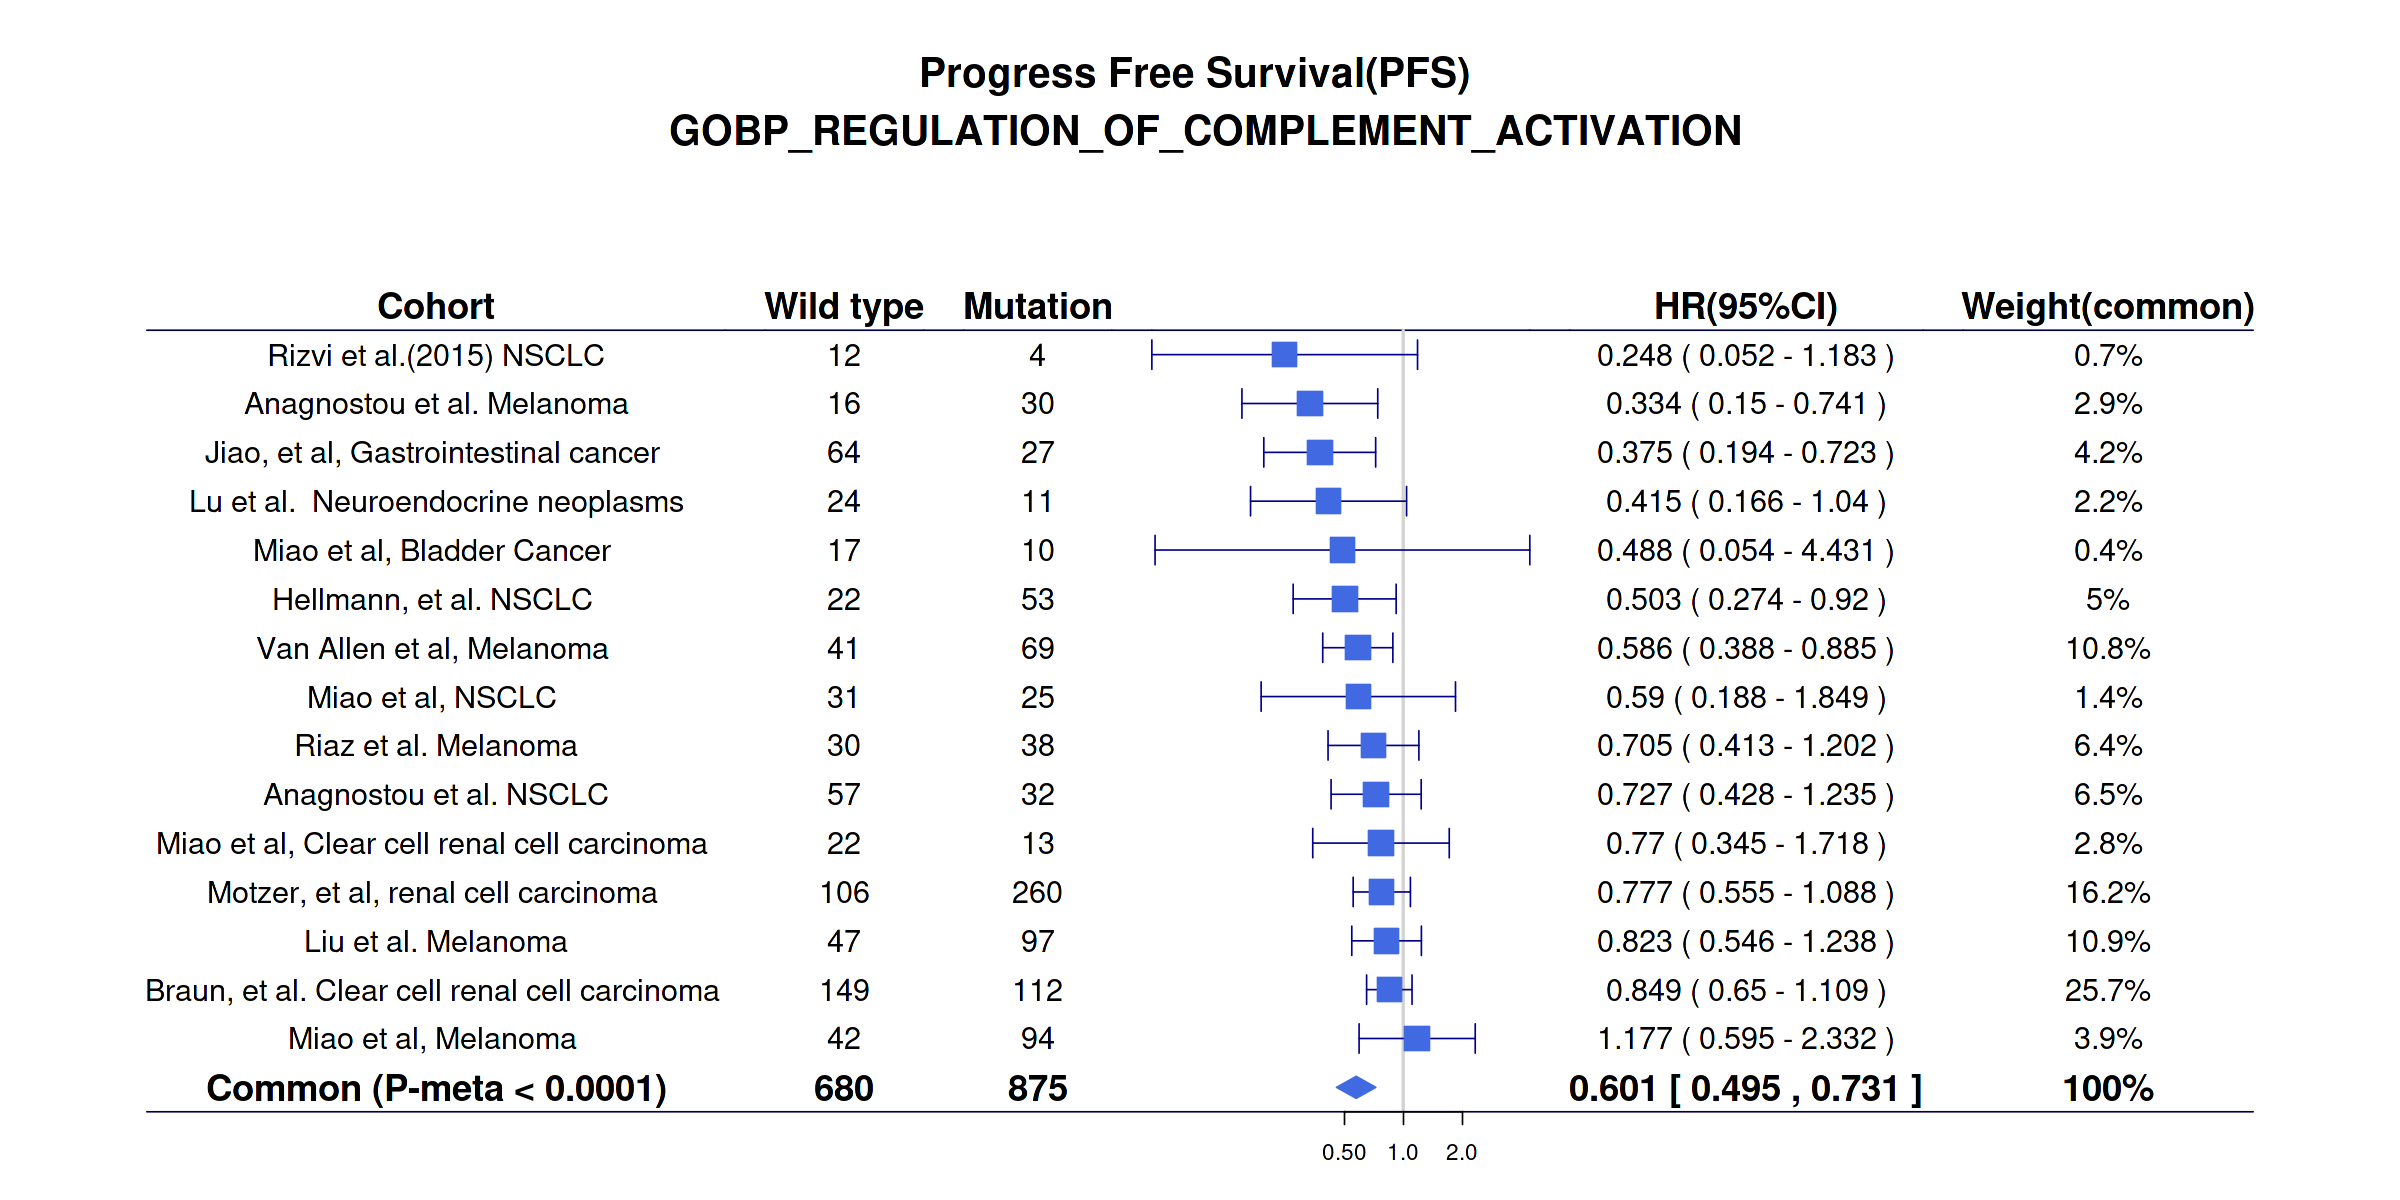

In [87]:
library(forestplot)
cohort = vector()
wildtype = vector()
mutation = vector()
HR_mean = vector()
HR_lower = vector()
HR_upper = vector()
HR_text = vector()
logtest = vector()
waldtest = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) >= 3 & length(tmp_cohort$wt) >= 3 & ("PFS_TIME" %in% colnames(All[[i]]))){
    
#     wildtype = c(wildtype,length(tmp_cohort$wt))
#     mutation = c(mutation,length(tmp_cohort$mut))
    
    tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]
      
      

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        cohort = c(cohort,dataset_name[i])
        
        wildtype = c(wildtype,table(tmp_data$groups)["Wildtype"])
        mutation = c(mutation,table(tmp_data$groups)["Mutation"])

        # fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = tmp_data))
        data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
        coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = tmp_data))
        HR_mean = c(HR_mean,round(summary(coxres)$conf.int[,1],3))
        HR_lower = c(HR_lower,round(summary(coxres)$conf.int[,3],3))
        HR_upper = c(HR_upper,round(summary(coxres)$conf.int[,4],3))
        HR_text = c(HR_text,paste(round(summary(coxres)$conf.int[,1],3),"(",round(summary(coxres)$conf.int[,3],3),"-",round(summary(coxres)$conf.int[,4],3),")"))
        logtest = c(logtest,round(summary(coxres)$logtest[3],3))
        waldtest = c(waldtest,round(summary(coxres)$waldtest[3],3))
    }

    
    
    
  }
}

ord = order(HR_mean)
tabletext = cbind(
                  c(NA,"Cohort",cohort[ord],"Common","Random"),
                  c(NA,"Wild type",wildtype[ord],sum(wildtype),sum(wildtype)),
                  c(NA,"Mutation",mutation[ord],sum(mutation),sum(mutation)),
                  c(NA,"HR(95%CI)",HR_text[ord],NA,NA)
#                   c(NA,"P value(Log rank)",logtest[ord],NA),
#                   c(NA,"P value(wald text)",waldtest[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,HR_mean[ord],NA,NA),"lower" = c(NA,NA,HR_lower[ord],NA,NA),"upper" = c(NA,NA,HR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "HR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

tmp_list = list()
tmp_list[["3"]] = gpar(col = "#000044")
tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")
options(repr.plot.height = 10, repr.plot.width = 20)
p = cochrane_from_rmeta2 %>% 
      forestplot(labeltext = tabletext2, clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
                 lty.ci = 1,
                 ci.vertices.height = 0.3,
                 align="c",
                 graphwidth = unit(8,"cm"),
                 lwd.zero = gpar(lwd=2,lty=2),
                 txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
                 boxsize = 0.5,
                 graph.pos = 4,
                 title = paste("Progress Free Survival(PFS)","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
                 is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
                 xlog = TRUE, 
                 hrzl_lines = tmp_list,
                 vertices = TRUE,
                 col = fpColors(box = "royalblue",
                                line = "darkblue",
                                summary = "royalblue")
                 )
p

In [88]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_PFS.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [90]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_PFS.heterogeneity.pdf",width = 20,height = 10)
forest(m)
dev.off()

png 
  2

##### RECIST + RESPONSE

Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(contingency, correct = F):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(xx, correct = correction):
“Chi-squared approximatio

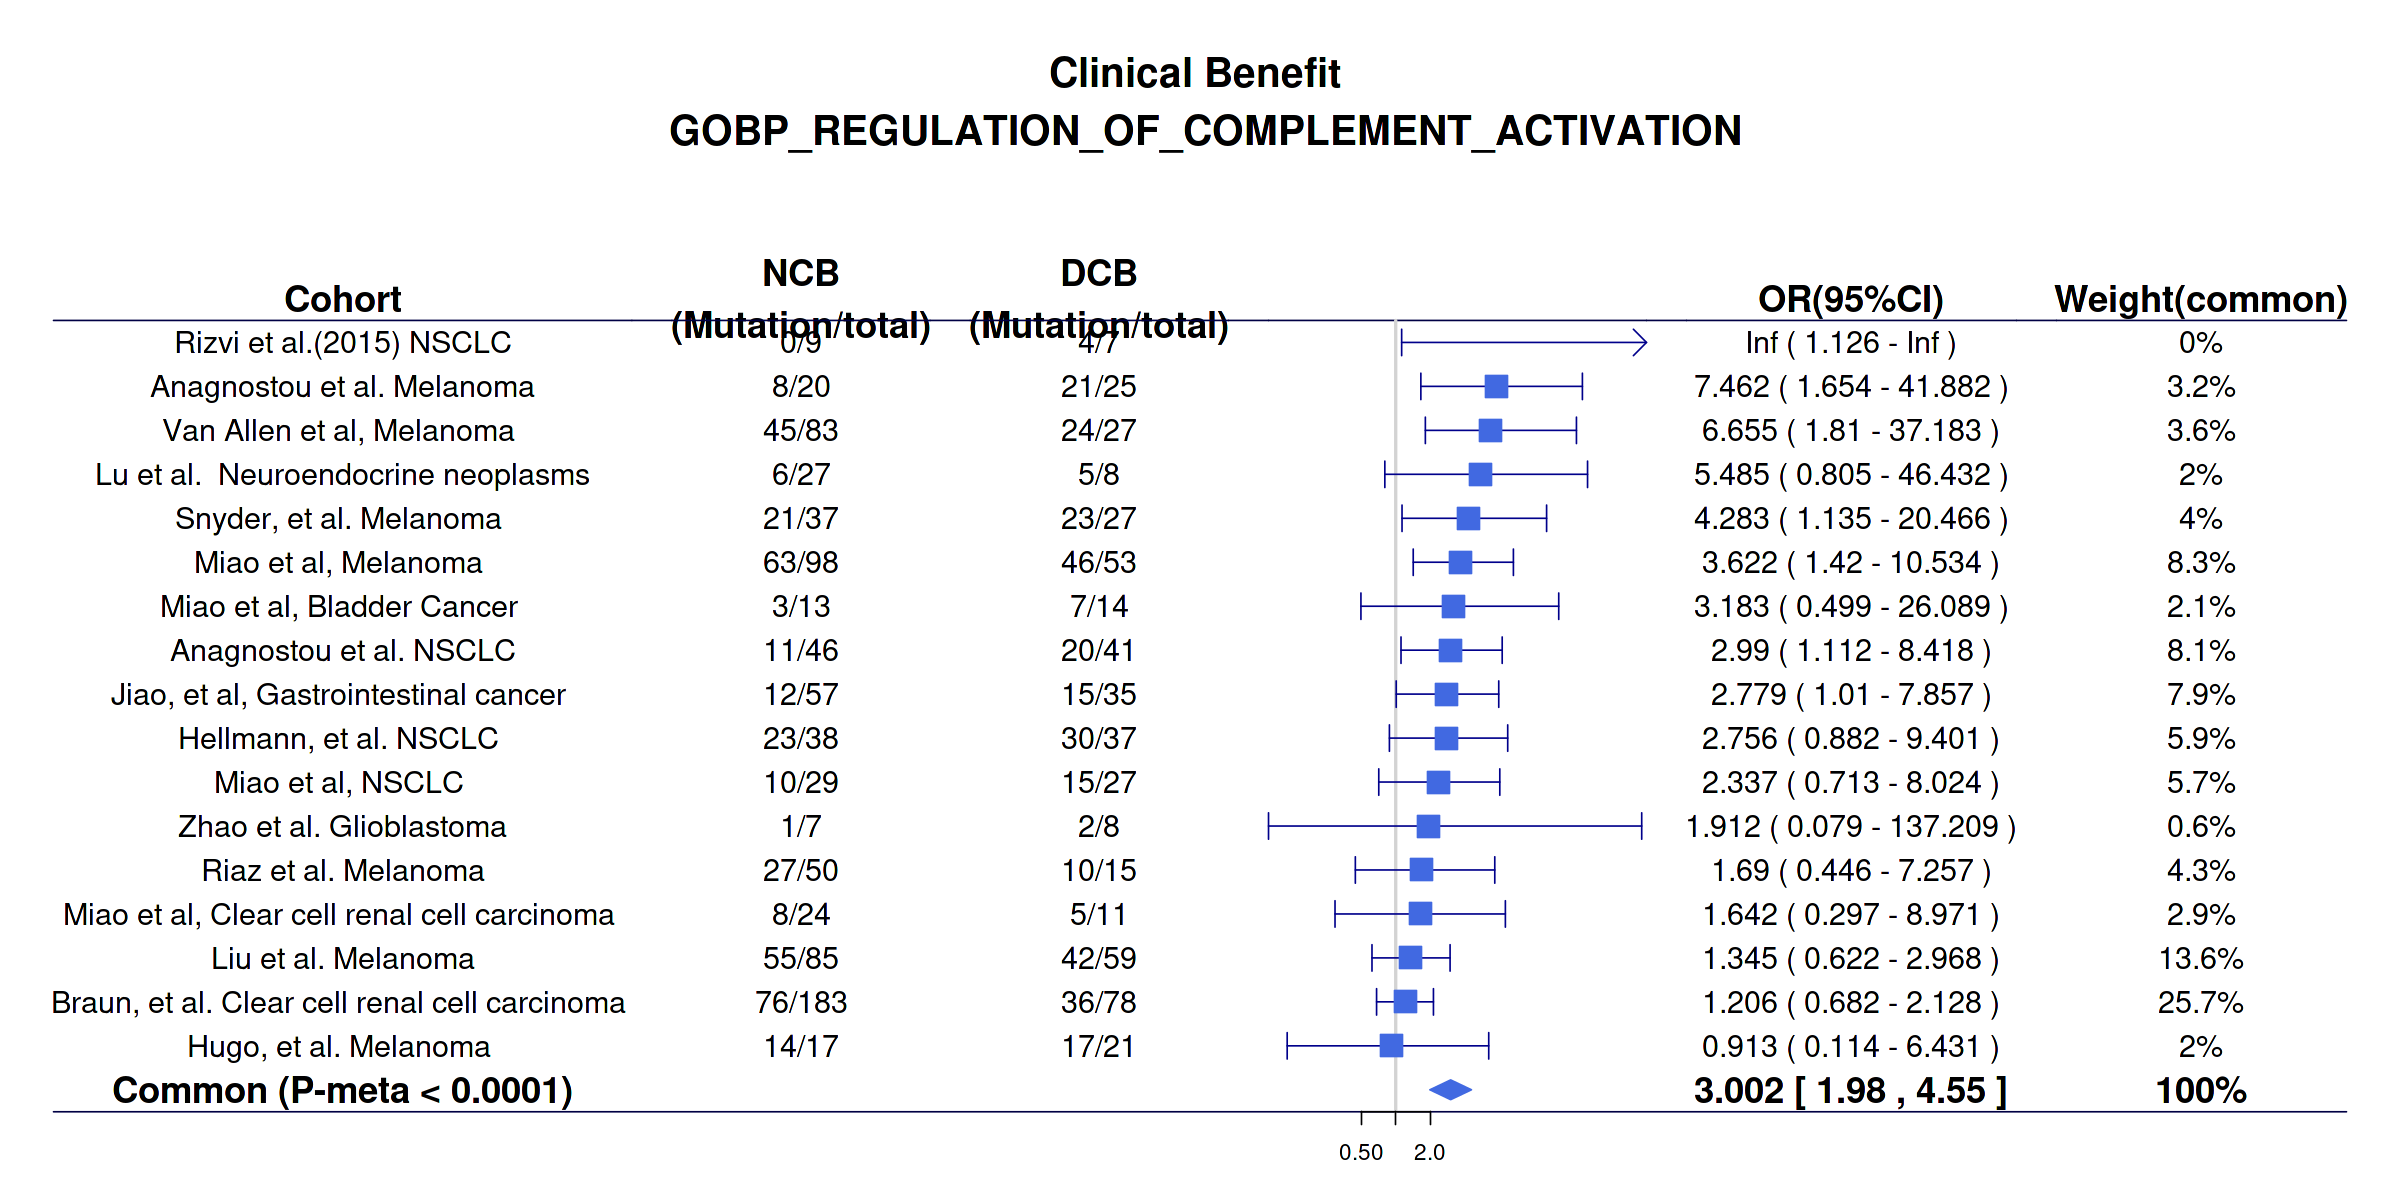

In [91]:
library(forestplot)
cohort = vector()
NCB = vector()
DCB = vector()
OR_mean = vector()
OR_lower = vector()
OR_upper = vector()
OR_text = vector()
midp.exact = vector()
chi.square = vector()
fisher.exact = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
  tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RESPONSE" %in% colnames(All[[i]]))){
    
    
    
      
    tmp_data = All[[i]][c("RESPONSE")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RESPONSE)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RESPONSE = oddsratio(contingency,correction = T,rev = "both",method = c( "fisher"))
        }else{

                rr_RESPONSE = oddsratio(contingency,correction = F,rev = "both",method = c( "fisher"))
        }


          NCB = c(NCB,paste(rr_RESPONSE$data["Mutation","nonresponse"],rr_RESPONSE$data["Total","nonresponse"],sep = "/"))
          DCB = c(DCB,paste(rr_RESPONSE$data["Mutation","response"],rr_RESPONSE$data["Total","response"],sep = "/"))

          OR_mean = c(OR_mean,rr_RESPONSE$measure[2,1])
          OR_lower = c(OR_lower,rr_RESPONSE$measure[2,2])
          OR_upper = c(OR_upper,rr_RESPONSE$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RESPONSE$measure[2,1],digits = 3),"(",round(rr_RESPONSE$measure[2,2],digits = 3),"-",round(rr_RESPONSE$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RESPONSE$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RESPONSE$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RESPONSE$p.value[2,2],digits = 3)) 
        
        
    }

    
    
    
  }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]]))){
      
    
    
      
    tmp_data = All[[i]][c("RECIST")]

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
    tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))

    tmp_data = tmp_data[rowSums(is.na(tmp_data)) == 0,]
    if(table(tmp_data$groups)["Mutation"] >= 3 & table(tmp_data$groups)["Wildtype"] >= 3 ){
        
        cohort = c(cohort,dataset_name[i])
        contingency = table(tmp_data$groups,tmp_data$RECIST)
        tmp_chi = chisq.test(contingency,correct = F)

        if(sum(tmp_chi$expected < 5) > 0){

                rr_RECIST = oddsratio(contingency,correction = T,rev = "row",method = c( "fisher"))
        }else{

                rr_RECIST = oddsratio(contingency,correction = F,rev = "row",method = c( "fisher"))
        }



          NCB = c(NCB,paste(rr_RECIST$data["Mutation","PD/SD"],rr_RECIST$data["Total","PD/SD"],sep = "/"))
          DCB = c(DCB,paste(rr_RECIST$data["Mutation","CR/PR"],rr_RECIST$data["Total","CR/PR"],sep = "/"))

          OR_mean = c(OR_mean,rr_RECIST$measure[2,1])
          OR_lower = c(OR_lower,rr_RECIST$measure[2,2])
          OR_upper = c(OR_upper,rr_RECIST$measure[2,3])
          OR_text = c(OR_text,paste(round(rr_RECIST$measure[2,1],digits = 3),"(",round(rr_RECIST$measure[2,2],digits = 3),"-",round(rr_RECIST$measure[2,3],digits = 3),")"))
          midp.exact = c(midp.exact,round(rr_RECIST$p.value[2,1],digits = 3))
          chi.square = c(chi.square,round(rr_RECIST$p.value[2,3],digits = 3))
          fisher.exact = c(fisher.exact,round(rr_RECIST$p.value[2,2],digits = 3))
        
        
    }

      
  }
}

ord = order(OR_mean,decreasing = T)
tabletext = cbind(
    c(NA,"Cohort",cohort[ord],"Common","Random"),
    c(NA,"NCB\n(Mutation/total)",NCB[ord],NA,NA),
    c(NA,"DCB\n(Mutation/total)",DCB[ord],NA,NA),
    c(NA,"OR(95%CI)",OR_text[ord],NA,NA)
#     c(NA,"P value\n(midp.exact)",midp.exact[ord],NA,NA),
#     c(NA,"P value\n(chi.square)",chi.square[ord],NA,NA),
#     c(NA,"P value\n(fisher.exact)",fisher.exact[ord],NA,NA)
)
cochrane_from_rmeta = data.frame("mean" = c(NA,NA,OR_mean[ord],NA,NA),"lower" = c(NA,NA,OR_lower[ord],NA,NA),"upper" = c(NA,NA,OR_upper[ord],NA,NA))

tmp = cochrane_from_rmeta[3:(nrow(cochrane_from_rmeta)-2),]
rownames(tmp) = tabletext[3:(nrow(cochrane_from_rmeta)-2),1]
tmp$se = (log2(tmp$upper) - log2(tmp$lower))/(2*1.96)
m = metagen(TE = log2(tmp$mean),seTE = tmp$se,studlab = rownames(tmp),sm = "OR", method.tau = "DL")
k = summary(m)

chtext = paste(round(exp(x = 1)^(k$common$TE),3),"[",round(exp(x = 1)^(k$common$lower),3),",",round(exp(x = 1)^(k$common$upper),3),"]")
tabletext[nrow(tabletext)-1,4] = c(chtext)
cochrane_from_rmeta[nrow(tabletext)-1,1:3] = c(round(exp(x = 1)^(k$common$TE),3),round(exp(x = 1)^(k$common$lower),3),round(exp(x = 1)^(k$common$upper),3))
rhtext = paste(round(exp(x = 1)^(k$random$TE),3),"[",round(exp(x = 1)^(k$random$lower),3),",",round(exp(x = 1)^(k$random$upper),3),"]")
tabletext[nrow(tabletext),4] = c(rhtext)
cochrane_from_rmeta[nrow(tabletext),1:3] = c(round(exp(x = 1)^(k$random$TE),3),round(exp(x = 1)^(k$random$lower),3),round(exp(x = 1)^(k$random$upper),3))

if(k$pval.Q < 0.1){
    tabletext2 = tabletext[-(nrow(tabletext)-1),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(random)",paste(round(k$w.random/sum(k$w.random),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.random,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.random),")")
    }


    
}else{
    tabletext2 = tabletext[-(nrow(tabletext)),]
    cochrane_from_rmeta2 = cochrane_from_rmeta[-(nrow(tabletext)-1),]
    tabletext2 = cbind(tabletext2,c(NA,"Weight(common)",paste(round(k$w.common/sum(k$w.common),3)*100,"%",sep = ""),"100%"))
    
    if(round(k$pval.common,digits = 4)<0.0001){
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta < 0.0001)")
    }else{
        tabletext2[nrow(tabletext2),1] = paste(tabletext2[nrow(tabletext2),1],"(P-meta = ",round(k$pval.common),")")
    }

}

maxup = max(cochrane_from_rmeta2$upper[!is.infinite(cochrane_from_rmeta2$upper)],na.rm = T)
minlow = min(cochrane_from_rmeta2$lower[cochrane_from_rmeta2$lower != 0],na.rm = T)

  tmp_list = list()
  tmp_list[["3"]] = gpar(col = "#000044")
  tmp_list[[as.character(nrow(cochrane_from_rmeta2) + 1)]] = gpar(col = "#000044")

  options(repr.plot.height = 10, repr.plot.width = 20)
  p = cochrane_from_rmeta2 %>%
    forestplot(labeltext = tabletext2,clip = c(minlow-minlow/10,maxup+maxup/10),xticks = c(0.5,1,2),
               
                lty.ci = 1,
                ci.vertices.height = 0.3,
                align="c",
                graphwidth = unit(8,"cm"),
                lwd.zero = gpar(lwd=2,lty=2),
               txt_gp = fpTxtGp(title = gpar(cex = 2),ticks=gpar(cex=1.1),summary=gpar(cex = 1.8),label = gpar(cex = 1.5)),
               boxsize = 0.5,
               graph.pos = 4,
               title = paste("Clinical Benefit","\n","GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION"),
               is.summary = c(rep(TRUE, 2), rep(FALSE, nrow(cochrane_from_rmeta2)-3)),
               xlog = TRUE,
               hrzl_lines = tmp_list,
               vertices = TRUE,
               col = fpColors(box = "royalblue",
                              line = "darkblue",
                              summary = "royalblue")
    )
  print(p)

In [92]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_CB.pdf",width = 20,height = 10)
p
dev.off()

png 
  2

In [94]:
pdf("Artical_Figure2/Figure 2/Complement_DetialMeta_CB.heterogeneity.pdf",width = 20,height = 10)
forest(m)
dev.off()

png 
  2

# Pooled Analysis

In [191]:
library(ggplot2)
library(survival)
library(survminer)
library(forestplot)
library(meta)
library(epitools)
All = readRDS("/srv/shiny-server/SNVIO_V7/Refence_datasets_COX.rds")
pathway_list = readRDS("/srv/shiny-server/SNVIO_V10.1/data/all_pathway.rds")
datasets_mu = readRDS("/home/ncpsb//new_mnt/Other/jx/web/data/fast_explore/data/Refence_datasets_mutation_with_therapy.rds")

In [212]:
datasets_overview[ datasets_overview$Sequencing == "WES" & datasets_overview$OS == TRUE, ]

Cohort_name                                     Cohort           
dataset2   Van Allen et al, Melanoma                       Van Allen et al. 
dataset3.1 Miao et al, Bladder Cancer                      Miao et al.      
dataset3.2 Miao et al, Melanoma                            Miao et al.      
dataset3.3 Miao et al, NSCLC                               Miao et al.      
dataset3   Miao et al, Microsatellite-stable solid tumors  Miao et al.      
dataset6   Pender, Pan-cancer                              Pender et al.    
dataset8   Hugo, et al. Melanoma                           Hugo et al.      
dataset9   Jiao, et al, Gastrointestinal cancer            Jiao et al.      
dataset10  Snyder, et al. Melanoma                         Snyder et al.    
dataset12  Braun, et al. Clear cell renal cell carcinoma   Braun et al.     
dataset14  Miao et al, Clear cell renal cell carcinoma     Miao et al.      
dataset15  Zhao et al. Glioblastoma                        Zhao et al.      
dataset18  Anagnostou et al. Melanoma                      Anagnostou et al.
dataset19  Anagnostou et al. NSCLC                         Anagnostou et al.
dataset20  Riaz et al. Melanoma                            Riaz et al.      
dataset21  Liu et al. Melanoma                             Liu et al.       
dataset23  Lu et al.  Neuroendocrine neoplasms             Lu et al.        
           Cancer_type                        Cohort_size
dataset2   Melanoma                           110        
dataset3.1 Bladder Cancer                      27        
dataset3.2 Melanoma                           151        
dataset3.3 Non-small cell lung cancer          56        
dataset3   Microsatellite-stable solid tumors 249        
dataset6   Pan-cancer                          98        
dataset8   Melanoma                            38        
dataset9   Pan-GI cancer                       92        
dataset10  Melanoma                            64        
dataset12  Kidney Cancer                      261        
dataset14  Kidney Cancer                       35        
dataset15  Glioblastoma                        15        
dataset18  Melanoma                            46        
dataset19  Non-small cell lung cancer          89        
dataset20  Melanoma                            68        
dataset21  Melanoma                           144        
dataset23  Neuroendocrine tumours              35        
           Immune_checkpoint_blockade Sequencing OS   PFS   RECIST RESPONSE
dataset2   Anti-CTLA4                 WES        TRUE  TRUE  TRUE   TRUE   
dataset3.1 Mixed ICB                  WES        TRUE  TRUE  TRUE   TRUE   
dataset3.2 Mixed ICB                  WES        TRUE  TRUE  TRUE   TRUE   
dataset3.3 Mixed ICB                  WES        TRUE  TRUE  TRUE   TRUE   
dataset3   Mixed ICB                  WES        TRUE  TRUE  TRUE   TRUE   
dataset6   Mixed ICB                  WES        TRUE  TRUE FALSE   TRUE   
dataset8   Anti-PD1/PDL1              WES        TRUE FALSE  TRUE  FALSE   
dataset9   Mixed ICB                  WES        TRUE  TRUE FALSE   TRUE   
dataset10  Anti-CTLA4                 WES        TRUE FALSE FALSE   TRUE   
dataset12  Anti-PD1/PDL1              WES        TRUE  TRUE  TRUE   TRUE   
dataset14  Anti-PD1/PDL1              WES        TRUE  TRUE  TRUE   TRUE   
dataset15  Anti-PD1/PDL1              WES        TRUE  TRUE FALSE   TRUE   
dataset18  Mixed ICB                  WES        TRUE  TRUE  TRUE  FALSE   
dataset19  Mixed ICB                  WES        TRUE  TRUE FALSE   TRUE   
dataset20  Mixed ICB                  WES        TRUE  TRUE  TRUE  FALSE   
dataset21  Mixed ICB                  WES        TRUE  TRUE  TRUE  FALSE   
dataset23  Anti-PD1/PDL1              WES        TRUE  TRUE  TRUE  FALSE   
           TMB  RNA  
dataset2   TRUE FALSE
dataset3.1 TRUE FALSE
dataset3.2 TRUE FALSE
dataset3.3 TRUE FALSE
dataset3   TRUE FALSE
dataset6   TRUE FALSE
dataset8   TRUE FALSE
dataset9   TRUE FALSE
dataset10  TRUE

In [104]:
ref_cohort_cal_pm = function(dataset,pathway,dataset_mu,Mut_type,Wild_type){
  
  genes = intersect(colnames(dataset),pathway_list[[pathway]])
  
  if("All" %in% Mut_type){
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes
    ])
    
  }else{
    
    
    mut = unique(dataset_mu$ID[
      dataset_mu$Hugo_Symbol %in% genes & 
        dataset_mu$Variant_Classification %in% Mut_type
    ])
    
    
    
  }
  
  if(Wild_type == "Others"){
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),mut)
  }else{
    wt = setdiff(unique(c(dataset_mu$ID,rownames(dataset))),unique(dataset_mu$ID[dataset_mu$Hugo_Symbol %in% genes]))
  }
  
  return(list("mut"=mut,"wt"=wt))
  
}

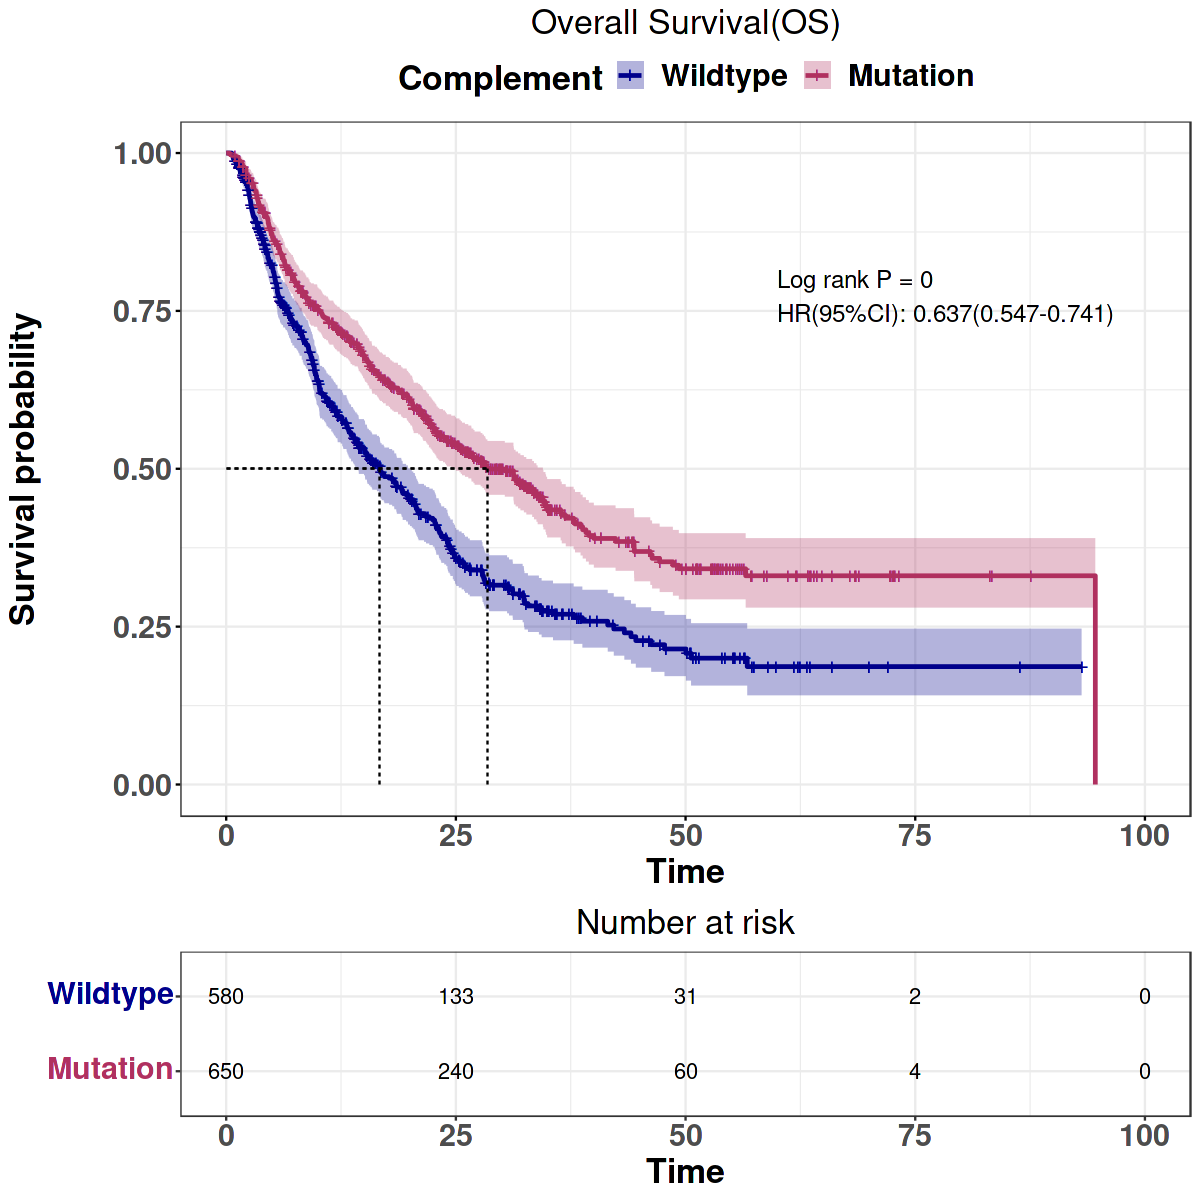

In [126]:
OS_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("OS_TIME" %in% colnames(All[[i]]))){
        tmp_data = All[[i]][,c("OS_TIME","OS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
#         print(i)
#         print(summary(tmp_data$OS_TIME))
        OS_total = rbind(OS_total,tmp_data)

      }
    }

fit <- do.call(survfit, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
data.survdiff <- do.call(survdiff, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
coxres <- do.call(coxph, list(Surv(OS_TIME,OS_STATUS)~groups,data = OS_total))
HR = round(summary(coxres)$conf.int[,c(1,3,4)],3)
      
p1 = ggsurvplot(fit,data = OS_total,
                pval = paste("\n","Log rank P = ",p.val,"\n","HR(95%CI): ",HR[1],"(",HR[2],"-",HR[3],")",sep = ""),
#                 conf.int.style = "step",
                conf.int = TRUE,
                surv.median.line = "hv",
                pval.coord = c(60, 0.8),
                risk.table = T,
                cumevents = F,
                palette = c("darkblue", "maroon"),
                title=paste("Overall Survival(OS)"),
                legend.title="Complement",
                legend.labs = c("Wildtype","Mutation"),
                ggtheme = theme_bw()+theme(plot.title = element_text(hjust = 0.5,size = 20),legend.position = "right",
                                           legend.title = element_text(size = 20,face="bold"),
                                           legend.text = element_text(size=18,face="bold"),
                                           axis.text = element_text(size=18,face="bold"),
                                           axis.title = element_text(size = 20,face="bold"))
)
tmp_table = p1$table + theme(axis.title.y = element_blank())
p1$table = tmp_table
options(repr.plot.height = 10, repr.plot.width = 10)
return(p1)

In [106]:
pdf("Artical_Figure2/Figure 2/Pooled_Analysis_OS.pdf",width = 10,height = 10,onefile = F)
p1
dev.off()

png 
  2

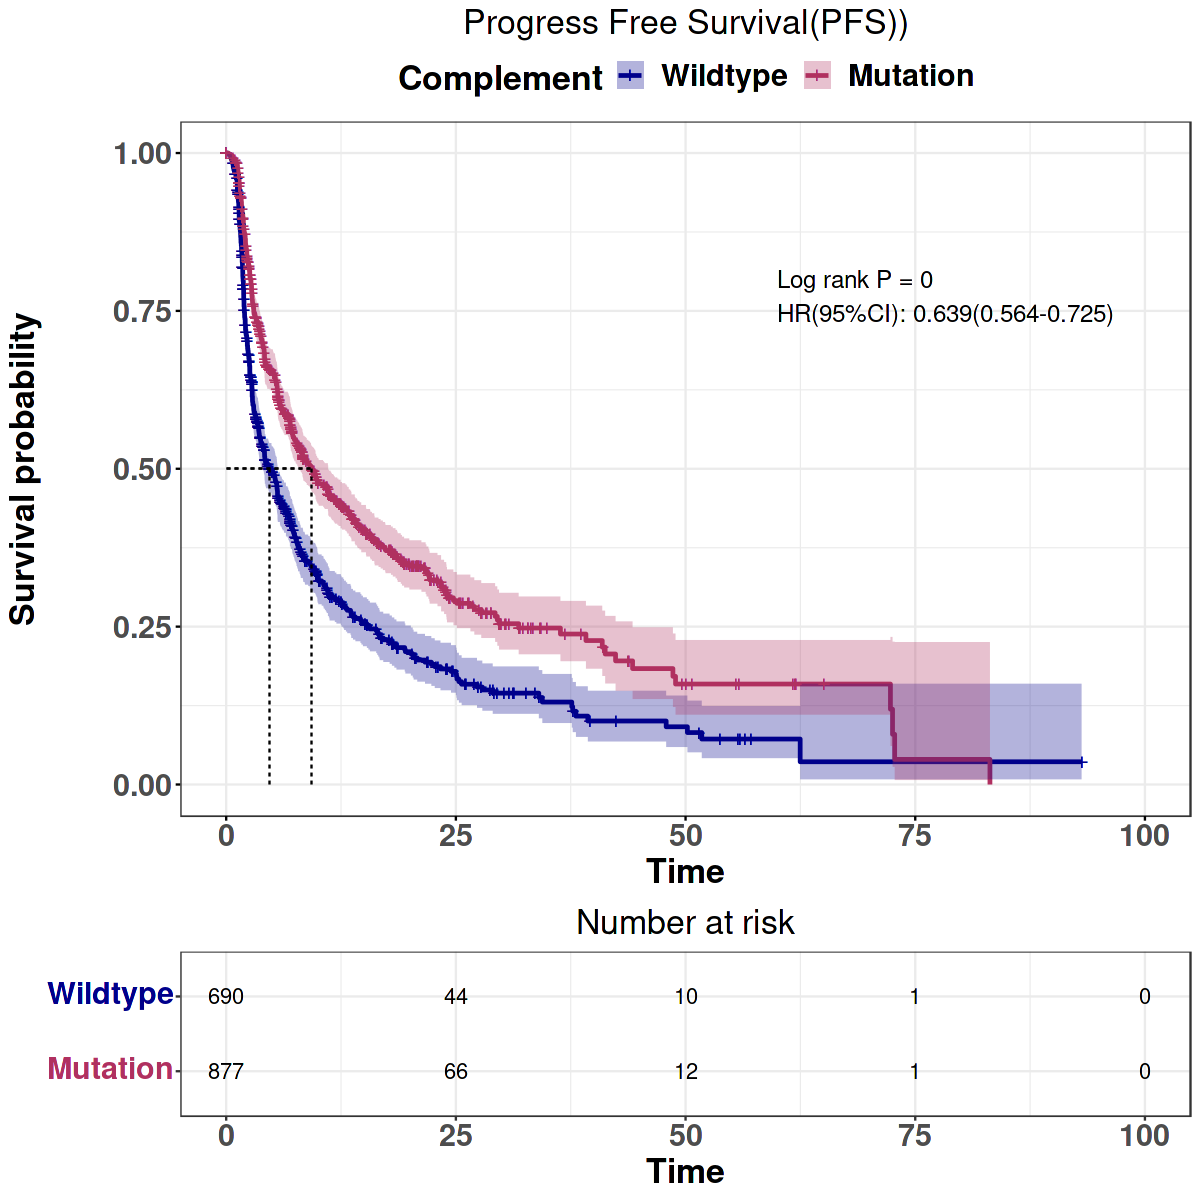

In [127]:
PFS_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
      tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_REGULATION_OF_COMPLEMENT_ACTIVATION",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
      if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("PFS_TIME" %in% colnames(All[[i]]))){
        tmp_data = All[[i]][,c("PFS_TIME","PFS_STATUS")]

        tmp_data$groups = NA
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
        tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
        tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
#         print(i)
#         print(summary(tmp_data$PFS_TIME))
        PFS_total = rbind(PFS_total,tmp_data)

      }
    }

fit <- do.call(survfit, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
data.survdiff <- do.call(survdiff, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
p.val = round(1 - pchisq(data.survdiff$chisq, length(data.survdiff$n) - 1),4)
coxres <- do.call(coxph, list(Surv(PFS_TIME,PFS_STATUS)~groups,data = PFS_total))
HR = round(summary(coxres)$conf.int[,c(1,3,4)],3)

p1 = ggsurvplot(fit,data = PFS_total,
                pval = paste("\n","Log rank P = ",p.val,"\n","HR(95%CI): ",HR[1],"(",HR[2],"-",HR[3],")",sep = ""),
#                 conf.int.style = "step",
                conf.int = TRUE,
                surv.median.line = "hv",
                pval.coord = c(60, 0.8),
                risk.table = T,
                cumevents = F,
                palette = c("darkblue", "maroon"),
                title=paste("Progress Free Survival(PFS))"),
                legend.title="Complement",
                legend.labs = c("Wildtype","Mutation"),
                ggtheme = theme_bw()+theme(plot.title = element_text(hjust = 0.5,size = 20),legend.position = "right",
                                           legend.title = element_text(size = 20,face="bold"),
                                           legend.text = element_text(size=18,face="bold"),
                                           axis.text = element_text(size=18,face="bold"),
                                           axis.title = element_text(size = 20,face="bold"))
)
tmp_table = p1$table + theme(axis.title.y = element_blank())
p1$table = tmp_table
options(repr.plot.height = 10, repr.plot.width = 10)
return(p1)

In [108]:
pdf("Artical_Figure2/Figure 2/Pooled_Analysis_PFS.pdf",width = 10,height = 10,onefile = F)
p1
dev.off()

png 
  2

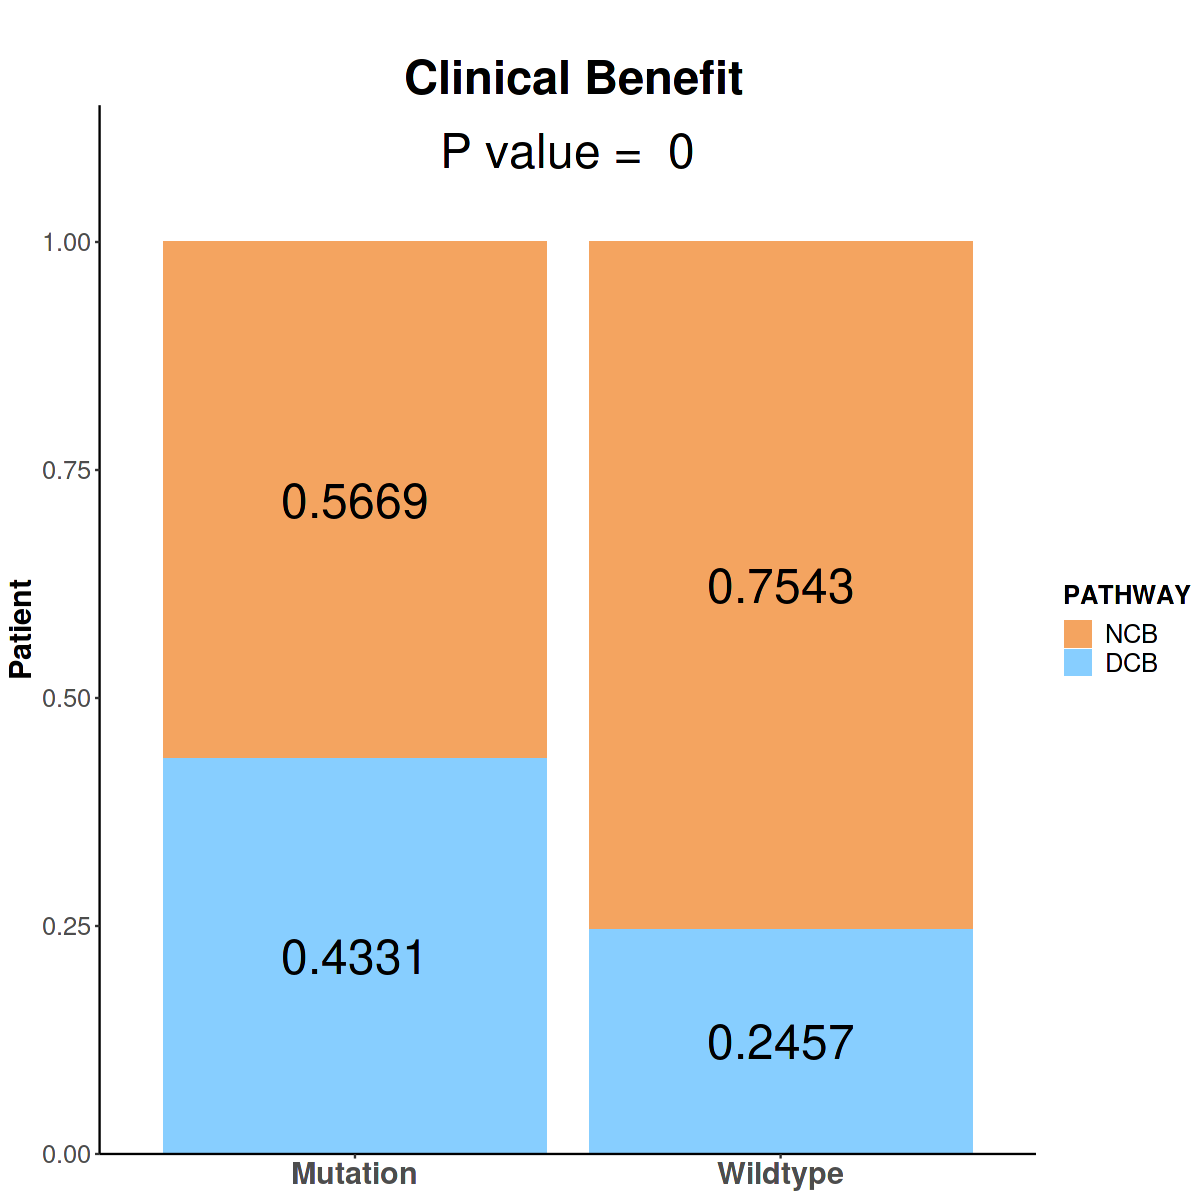

In [128]:
CB_total = vector()
for(i in setdiff(names(All),c("dataset1","dataset3","dataset6"))){
    tmp_cohort = ref_cohort_cal_pm(dataset = All[[i]],pathway = "GOBP_POST_EMBRYONIC_DEVELOPMENT",dataset_mu = datasets_mu[[i]],Mut_type = "All",Wild_type = "Wiltype")
  if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RESPONSE" %in% colnames(All[[i]]))){

    
      
    tmp_data = All[[i]][c("RESPONSE")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
    
  }else if(length(tmp_cohort$mut) != 0 & length(tmp_cohort$wt) != 0 & ("RECIST" %in% colnames(All[[i]])) &
           ! i %in% rownames(datasets_overview)[datasets_overview$RESPONSE + datasets_overview$RECIST == 2]){
      
    
      
    tmp_data = All[[i]][c("RECIST")]
    colnames(tmp_data) = "CB"

    tmp_data$groups = NA
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$mut] = "Mutation"
    tmp_data$groups[rownames(tmp_data) %in% tmp_cohort$wt] = "Wildtype"
#     tmp_data$groups = factor(tmp_data$groups,levels = c("Wildtype","Mutation"))
    tmp_data$CB = ifelse( tmp_data$CB %in% "PD/SD","nonresponse",ifelse( tmp_data$CB %in% "CR/PR","response",NA))
    tmp_data$dataset = i
    CB_total = rbind(CB_total,tmp_data)
  }
}


contingency = table(CB_total$groups,CB_total$CB)
rc = rowSums(contingency)
tmp_ma = as.data.frame.matrix(contingency/rc)

if(sum(contingency)<40){
    pvalue = fisher.test(contingency)$p.value
}else{
    tmp_chi = chisq.test(contingency,correct = F)
    
if(sum(tmp_chi$expected < 1) > 0){
    pvalue = fisher.test(contingency)$p.value
}else if(sum(tmp_chi$expected < 5) > 0){
    pvalue = chisq.test(contingency,correct = TRUE)$p.value
}else{pvalue = chisq.test(contingency,correct = FALSE)$p.value}
    }


values = c(tmp_ma[,1],tmp_ma[,2])
g1 = c("Mutation","Wildtype","Mutation","Wildtype")
g2 = c("NCB","NCB","DCB","DCB")
data = data.frame("Genetype" = g1,"CR_PR_ratio" = values,"response" = g2)
data$response = factor(data$response,levels = c("NCB","DCB"))


      p = ggplot(data = data)+
          ggtitle(paste("\n","Clinical Benefit"))+
          geom_bar(mapping = aes(x = Genetype,y = CR_PR_ratio,fill = response),stat = 'identity', position = 'stack')+
          geom_text(aes(x = Genetype,y = CR_PR_ratio,group = response,label = round(CR_PR_ratio,4)),size = 10,stat = "identity", position = position_stack(0.5))+
          theme_classic()+
          scale_y_continuous(expand = c(0,0),limits = c(0,1.15),breaks = c(0,0.25,0.5,0.75,1))+
          scale_fill_manual(values = c("sandybrown","skyblue1"))+
          annotate("text",x = 1.5,y = 1.1,label = paste("P value = ",round(pvalue,digits = 4)),size = 10)+
          labs(fill = "PATHWAY")+
          ylab("Patient")+
          theme(
            plot.title = element_text(hjust = 0.5,size = 28,face = "bold",margin=margin(0,0,0,0)),
            axis.text.x = element_text(size = 18,face = "bold"),
            axis.title.x.bottom = element_blank(),
            axis.title.y = element_text(size = 18,face = "bold"),
            axis.text.y.left = element_text(size = 15),
            legend.text = element_text(size = 15),
            legend.title = element_text(size = 15,face = "bold"),
            legend.position = "right")
options(repr.plot.height = 10, repr.plot.width = 10)
print(p)

In [110]:
pdf("Artical_Figure2/Figure 2/Pooled_Analysis_CB.pdf",width = 10,height = 10,onefile = F)
p
dev.off()

png 
  2